In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from itertools import combinations

import sys
sys.path.append("../")

import utils_ML as uml

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [3]:
nsaf[meta.PXD_accession == "PXD003790"].notna().sum(axis=1).mean()

2160.3333333333335

In [8]:
nsaf[meta.PXD_accession == "PXD003790"].dropna(axis='columns', how="all")

uniprot_id  A0A096LP55  A0A0J9YWL9  A0A0J9YXQ4  A0A0U1RRL7  A0A1B0GTR0  \
assay_id                                                                 
32440              NaN    0.000025         NaN    0.000343         NaN   
32441         0.000278    0.000025         NaN         NaN         NaN   
32442              NaN         NaN         NaN         NaN         NaN   
32443              NaN         NaN         NaN    0.000324         NaN   
32444              NaN         NaN         NaN         NaN    0.000148   
32445              NaN         NaN         NaN         NaN         NaN   
32446         0.000504         NaN         NaN         NaN         NaN   
32447              NaN         NaN         NaN         NaN         NaN   
32448              NaN         NaN         NaN         NaN         NaN   
32449         0.000264         NaN         NaN         NaN         NaN   
32450              NaN         NaN         NaN    0.000316         NaN   
32451              NaN         NaN    0.000036    0.000652         NaN   

uniprot_id  A0A1B0GTY4  A0A1B0GUJ8  A0A1B0GUS4  A0A2Z4LIS9    A0AVT1  ...  \
assay_id                                                              ...   
32440              NaN         NaN         NaN         NaN  0.000626  ...   
32441              NaN    0.000124         NaN         NaN  0.000600  ...   
32442              NaN         NaN    0.000151         NaN  0.000708  ...   
32443              NaN         NaN    0.000150    0.000079  0.000854  ...   
32444              NaN         NaN    0.000155         NaN  0.000136  ...   
32445              NaN         NaN    0.000159         NaN  0.000140  ...   
32446          0.00013         NaN    0.000149    0.000079  0.000196  ...   
32447              NaN         NaN    0.000152         NaN  0.000244  ...   
32448              NaN         NaN    0.000152         NaN  0.000444  ...   
32449              NaN         NaN    0.000156         NaN  0.000388  ...   
32450              NaN         NaN    0.000146         NaN  0.000405  ...   
32451              NaN         NaN    0.000150         NaN  0.000396  ...   

uniprot_id    Q9Y6N5    Q9Y6V0    Q9Y6V7   Q9Y6W3    Q9Y6W5    Q9Y6X3  \
assay_id                                                                
32440            NaN       NaN       NaN  0.00003  0.000245       NaN   
32441            NaN       NaN       NaN      NaN  0.000101       NaN   
32442            NaN  0.000005  0.000048      NaN  0.000047       NaN   
32443            NaN       NaN  0.000095      NaN  0.000046       NaN   
32444            NaN       NaN       NaN      NaN  0.000096       NaN   
32445            NaN       NaN       NaN  0.00006  0.000148       NaN   
32446       0.000051       NaN       NaN      NaN  0.000184       NaN   
32447            NaN       NaN       NaN      NaN  0.000094       NaN   
32448            NaN       NaN       NaN      NaN  0.000094       NaN   
32449            NaN       NaN       NaN  0.00003  0.000145  0.000039   
32450            NaN       NaN       NaN      NaN  0.000090       NaN   
32451            NaN       NaN       NaN      NaN  0.000047       NaN   

uniprot_id    Q9Y6X9    Q9Y6Y0    Q9Y6Y1    Q9Y6Y8  
assay_id                                            
32440            NaN  0.000190       NaN  0.000317  
32441            NaN  0.000197       NaN  0.000278  
32442            NaN  0.000109       NaN  0.000372  
32443            NaN  0.000036       NaN  0.000345  
32444            NaN  0.000037       NaN  0.000262  
32445            NaN       NaN       NaN  0.000246  
32446            NaN       NaN       NaN  0.000229  
32447       0.000023       NaN       NaN  0.000233  
32448       0.000023  0.000145       NaN  0.000327  
32449            NaN  0.000075  0.000014  0.000312  
32450       0.000022       NaN       NaN  0.000336  
32451       0.000022  0.000036       NaN  0.000417  

[12 rows x 3966 columns]

In [3]:
def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(sample1[i] / sample2[i])
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None, xlims = (-2,2)):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(data = {"fold_change":{}, "index":{}})
    new_df = []
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    
    for index, row in subset.iterrows():
        if index == ref_i:
            new_df.append(row)
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

        new_df.append(row*np.median(fc_list))
    return new_df

([], <a list of 0 Text xticklabel objects>)

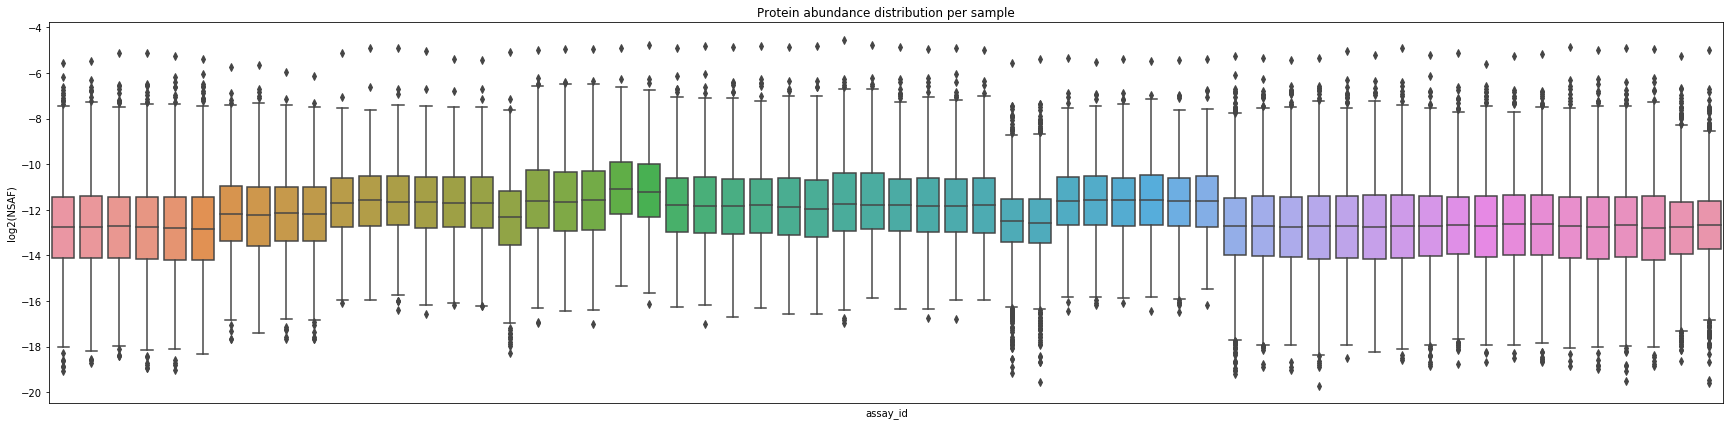

In [107]:
plt.figure(figsize=(30,7))
sns.boxplot(data=np.log2(nsaf_filtered[meta.Group == "HeLa"].T.melt().dropna()), y='value', x="assay_id")
plt.title("Protein abundance distribution per sample")
plt.ylabel("log2(NSAF)")
plt.xticks(ticks=[])

([], <a list of 0 Text xticklabel objects>)

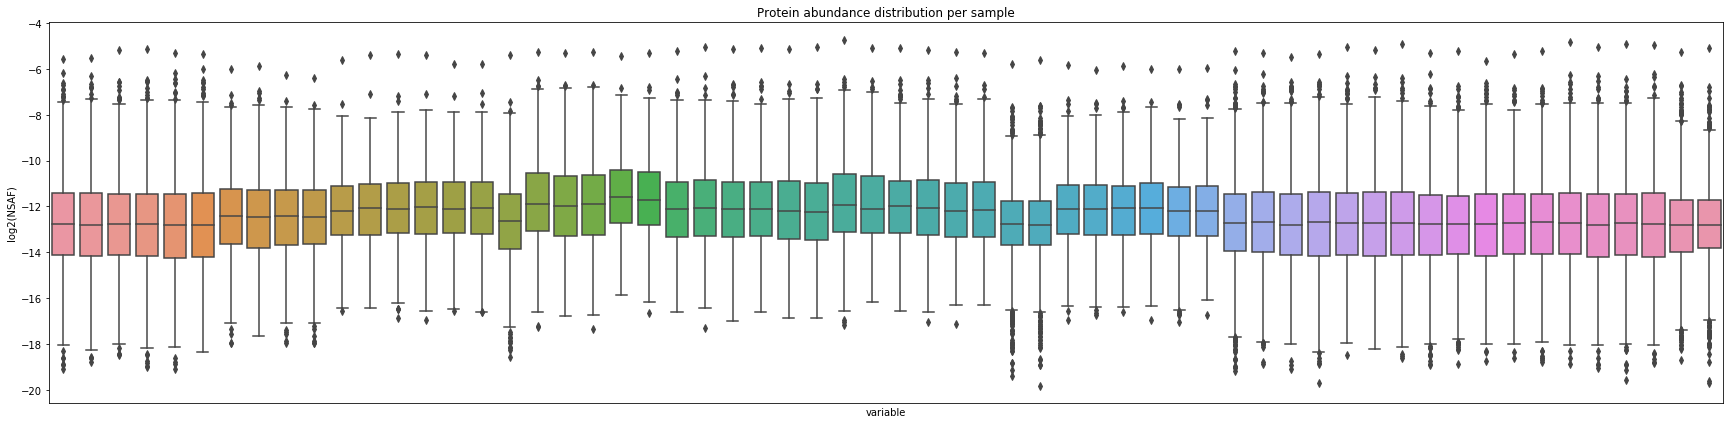

In [105]:
plt.figure(figsize=(30,7))
sns.boxplot(data=np.log2(new_df.replace(0,np.nan).T.melt().dropna()), y='value', x="variable")
plt.title("Protein abundance distribution per sample")
plt.ylabel("log2(NSAF)")
plt.xticks(ticks=[])

In [4]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(sample1[i] / sample2[i])
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None, xlims = (-2,2)):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(data = {"fold_change":{}, "index":{}})
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    for index, row in subset.iterrows():
        if index == ref_i:
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

    if plot_med_fc:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (25,8))
        
        ax1.set_xlim(right= xlims[1], left = xlims[0])    
        ax1.set_title("Fold changes")
        ax2.set_title("median fold changes")
        if color_scheme != None:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = color_scheme, common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = color_scheme,  alpha = .8)
        
        else:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = "tab10",  alpha = .8)
        return
        
    plt.xlim(right= 2, left = -2)    
    sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .5, legend = False)

def calculate_correlations(dataset, assay_ids):
    
    correlation_assays = {pxd :[] for pxd in meta.loc[assay_ids].PXD_accession.unique()}
    across_project_corr = {}
    dataset = dataset
    
    comparisons = combinations(assay_ids, 2)

    for comparison in comparisons:
        id1 = comparison[0]
        id2 = comparison[1]

        comp_df = dataset.loc[[id1,id2], :].T.dropna()

        r = stats.pearsonr(x=comp_df.loc[:,id1], y=comp_df.loc[:,id2])[0]

        pxd1 = meta.loc[id1].PXD_accession
        pxd2 = meta.loc[id2].PXD_accession
        if pxd1 == pxd2:
            correlation_assays[meta.loc[id1].PXD_accession].append(r)
        
        elif str(pxd1)+"-"+str(pxd2) in across_project_corr.keys():
            across_project_corr[str(pxd1)+"-"+str(pxd2)].append(r)

        elif str(pxd2)+"-"+str(pxd1) in across_project_corr.keys():
            across_project_corr[str(pxd2)+"-"+str(pxd1)].append(r)
        else:
            across_project_corr[str(pxd1)+"-"+str(pxd2)] = [r]

    return correlation_assays, across_project_corr


def calculate_correlations_bygroup(scaled_dataset):

    groups = meta.Group.unique()

    within_corr_g = []
    between_corr_g = []
    within_corr_sca_g = []
    between_corr_sca_g = []

    for group in groups:

        within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == group].index)
        within_corr_sca, between_corr_sca = calculate_correlations(scaled_dataset, meta[meta.Group == group].index)

        all_within_corr = []
        for px, x in within_corr.items():
            all_within_corr+=x
            #print(px, np.mean(x))

        all_between_corr = []
        for x in between_corr.values():
            all_between_corr += x

        all_within_corr_sca = []
        for px, x in within_corr_sca.items():
            all_within_corr_sca+=x
            #print(px, np.mean(x))

        all_between_corr_sca = []
        for x in between_corr_sca.values():
            all_between_corr_sca += x

        within_corr_g.append(all_within_corr)
        between_corr_g.append(all_between_corr)
        within_corr_sca_g.append(all_within_corr_sca)
        between_corr_sca_g.append(all_between_corr_sca)

    fig, ax = plt.subplots(2,1, figsize=(30,12))

    ax[0].set_title("Correlations project")
    ax[0].set_ylim((0,1))
    ax[1].set_title("Correlations project (scaled)")
    ax[1].set_ylim((0,1))

    dfs = []
    dfs_sca = []

    for i, g in enumerate(groups):

        all_within = pd.DataFrame(data=within_corr_g[i])
        all_within["Type"] = "Within project"
        all_between = pd.DataFrame(data=between_corr_g[i])
        all_between["Type"] = "Between projects"
        corr_df = pd.concat([all_within,all_between])
        corr_df["Group"] = g
        dfs.append(corr_df)

        all_within_sca = pd.DataFrame(data=within_corr_sca_g[i])
        all_within_sca["Type"] = "Within project"
        all_between_sca = pd.DataFrame(data=between_corr_sca_g[i])
        all_between_sca["Type"] = "Between projects"
        corr_df_sca = pd.concat([all_within_sca,all_between_sca])
        corr_df_sca["Group"] = g
        dfs_sca.append(corr_df_sca)
    
    corr_df_g = pd.concat(dfs)
    corr_df_sca_g = pd.concat(dfs_sca)

    sns.boxplot(data=corr_df_g,x="Group", y=0, hue="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca_g,x="Group", y=0, hue="Type", ax=ax[1])

    return corr_df_g, corr_df_sca

## Filter out very sparse samples

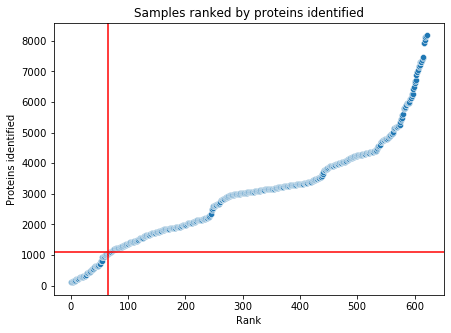

In [16]:
plt.figure(figsize=(7,5))
plt.title("Samples ranked by proteins identified")
plt.xlabel("Rank")
plt.ylabel("Proteins identified")
sns.scatterplot(y=nsaf.notna().sum(axis=1).sort_values(), x=list(range(1,622)))
plt.axhline(1100,c="r")
plt.axvline(621-557, c="r")

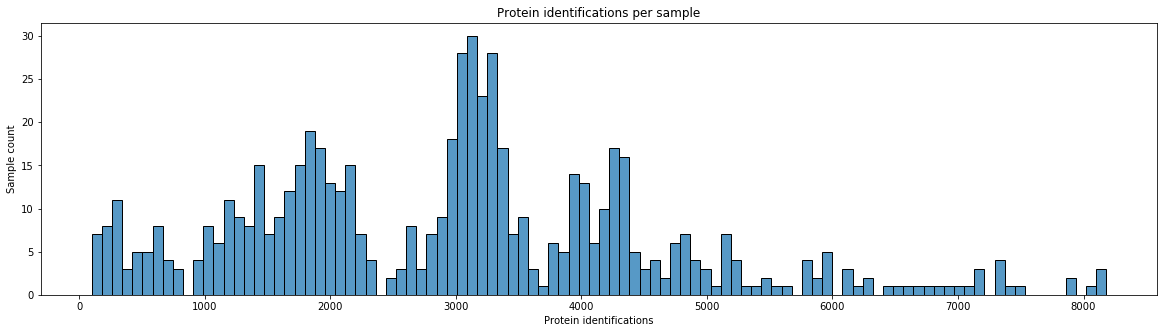

In [4]:
plt.figure(figsize=(20,5))
plt.title("Protein identifications per sample")
plt.ylabel("Sample count")
plt.xlabel("Protein identifications")
sns.histplot(nsaf.notna().sum(axis = 1), bins = 100)

In [5]:
nsaf.notna().sum(axis=1).describe()

count     621.000000
mean     2976.537842
std      1626.165263
min       100.000000
25%      1778.000000
50%      3047.000000
75%      3971.000000
max      8180.000000
dtype: float64

In [10]:
# percentage missing values
nsaf.isna().sum().sum()/ (nsaf.shape[0]*nsaf.shape[1])

0.7948205802584948

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


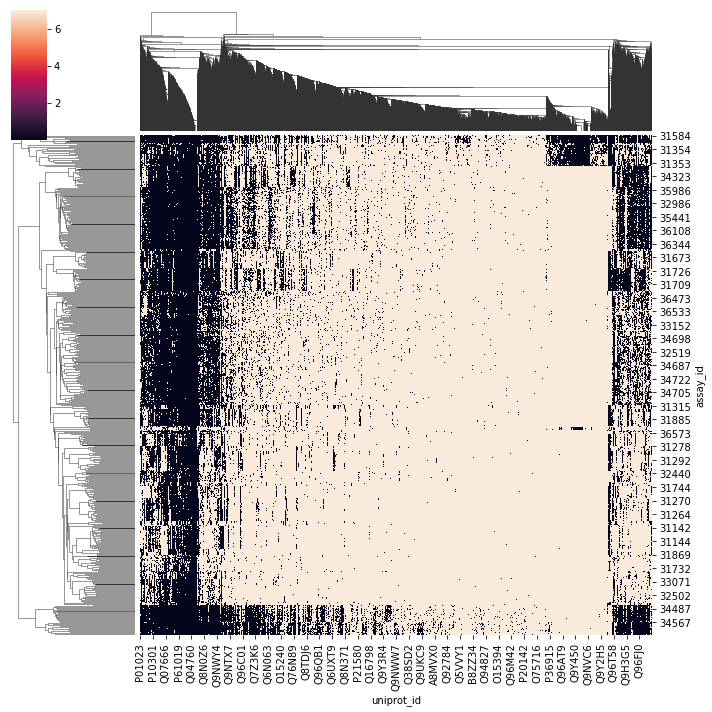

In [269]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf.fillna(7))

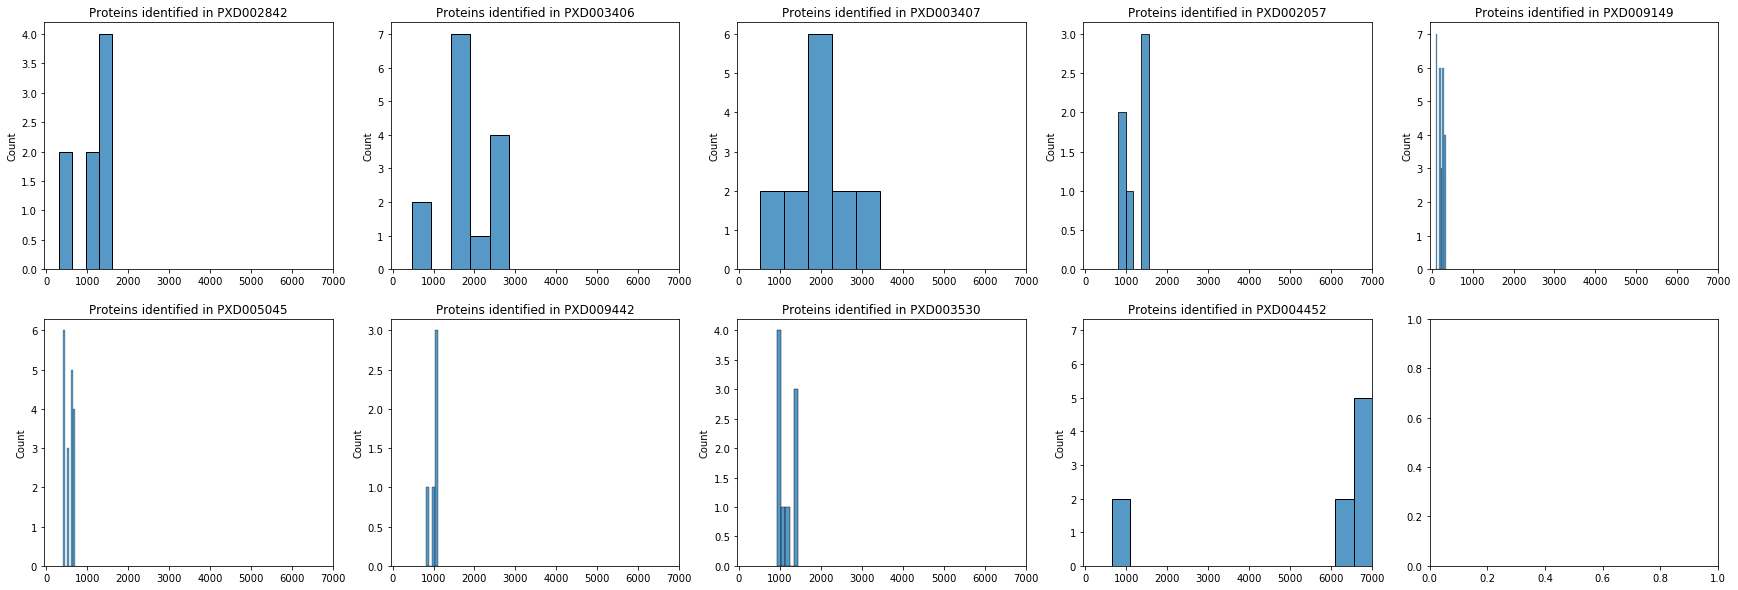

In [7]:
fig, ax = plt.subplots(2,5, figsize= (30,10))
for y, pxd in enumerate(meta.loc[nsaf.index[nsaf.notna().sum(axis=1) <1000], :].PXD_accession.unique()):
    
    if y < 5: 
        x=0
    else:
        y-=5
        x=1
    ax[x,y].set_title(f"Proteins identified in {pxd}")
    ax[x,y].set_xlim(left=-50, right=7000)
    sns.histplot(nsaf.loc[meta.PXD_accession == pxd].notna().sum(axis=1), ax=ax[x,y])

- **PXD002842**: Reported 3721 protein identifications. Here, only 312-1612 protein identifications were found with ionbot_v0.6.2 from 152,961 - 227,169 PSMs (sign_PSM: 31800). Drop the ones <1100
- **PXD003406, PXD003407**: Reported 8370 protein identifications. Here 4800 unique protein identifications were done. Assays reporting < 1100 proteins are dropped. Mean PSMs: 120,000 (sign_PSM: 21000). (ionbot_v0.6.2)
- **PXD002057**: Reported 800 protein identifications. Drop the AZD8931 resistant SKBR3 cells which all have <1100 protein identifications. sign_PSMs: 7500-9000. ionbot_version: v0.8.0
- **PXD009149**: Reported 3377 shared proteins (75% of total --> 4502 total proteins). ionbot_V0.6.0.2 never reaches more than 400 proteins with average sign_PSM: 843. Drop all of them
- **PXD005045**: Reported 1557 total protein identifications. We identify 1352 with ionbotv0.6.2. Average PSM (48398) with avg sign_PSM: 7897. No sample identified >700 proteins. Drop all of them.
- **PXD009442**: Reported +-2000 protein identifications per sample, however, only 1 proteotypic peptide was used to identify a protein. Here, >2 are needed and resulted in +- 1000 protein identifications per sample. Avg sign_PSM: 13311 (ionbotV0.6.2). Only keep the untreated cell. (assay_id 31702 with 1119 protein identifications)
- **PXD003530**: From 190,000-77,000 PSMs, (30,000-15,000 sign_PSM), only 950-1500 proteins were identified were >800 were identified in all samples. Keep only the ones with >1100 identifications.
- **PXD004452**: Only 2 assays identified <1100 proteins. For these, fractions are probably missing as most other identified >6000 proteins. Drop them.

In [3]:
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf_filtered = nsaf.loc[~nsaf.index.isin(drop_assays)]

meta_filtered = meta[meta.index.isin(nsaf_filtered.index)]
print(meta_filtered.PXD_accession.nunique(), "projects and", meta_filtered.shape[0], "proteomes")
meta = meta_filtered.reset_index()
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")
meta.sort_index(inplace=True)

44 projects and 557 proteomes


In [10]:
meta.cell_line.value_counts()

CRC         65
HeLa        60
MCF7        43
A431        24
SKNBE2      24
            ..
M14          1
KM12         1
RXF-393      1
NCI-H460     1
A375         1
Name: cell_line, Length: 79, dtype: int64

In [9]:
meta.Group.nunique()

28

In [10]:
meta.Group.unique()

array(['HCC', 'Neuroblastoma', 'SCC', 'HEK293', 'Ductal_breast',
       'Lymphoid_leukemia', 'HUVEC', 'CRC', 'Myeloid_leukemia',
       'glioblastoma', 'Lung', 'PC3', 'OV_endometrioid', 'HeLa', 'iPSC',
       'Skin_cancer', 'DOV13', 'OVCA433', 'OVISE', 'IOSE7576',
       'ovarian_cystadenocarcinoma', 'IOSE397', 'ME180', 'HGSOC',
       'MCF10F', 'RXF-393', 'U251', 'hESC'], dtype=object)

<Figure size 720x720 with 0 Axes>

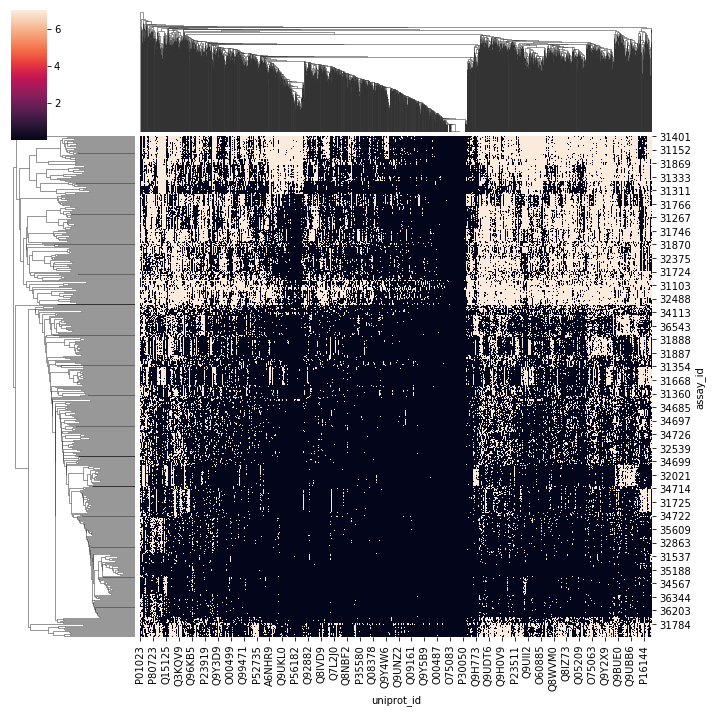

In [270]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf_filtered.fillna(7))

In [6]:
# percentage missing values
nsaf_filtered.isna().sum().sum()/ (nsaf_filtered.shape[0]*nsaf_filtered.shape[1])

0.775211595368001

In [4]:
cell_tissue_map = {"cell_line":[], "tissue_type":[]}

for i, row in meta.loc[:,["cell_line", "tissue_type"]].iterrows():
    cell, tissue = row
    if cell not in cell_tissue_map["cell_line"]:
        cell_tissue_map["cell_line"].append(cell)
        cell_tissue_map["tissue_type"].append(tissue)
cell_tissue_map = pd.DataFrame(cell_tissue_map)

lut = {}
colors = sns.color_palette("deep") + sns.color_palette("bright")
for x in meta.tissue_type.unique():
    lut[x] = colors[len(lut)]

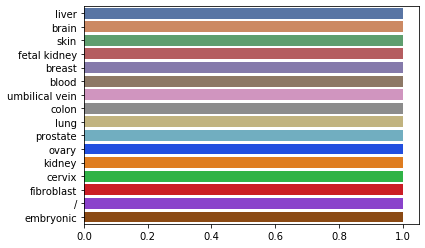

In [14]:
sns.barplot(x=[1]*16, y= list(lut.keys()), palette=list(lut.values()))

In [23]:
cols=[]
for cell_line in meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts().index:
    cols.append(lut[meta[meta.cell_line == cell_line].tissue_type.unique()[0]])

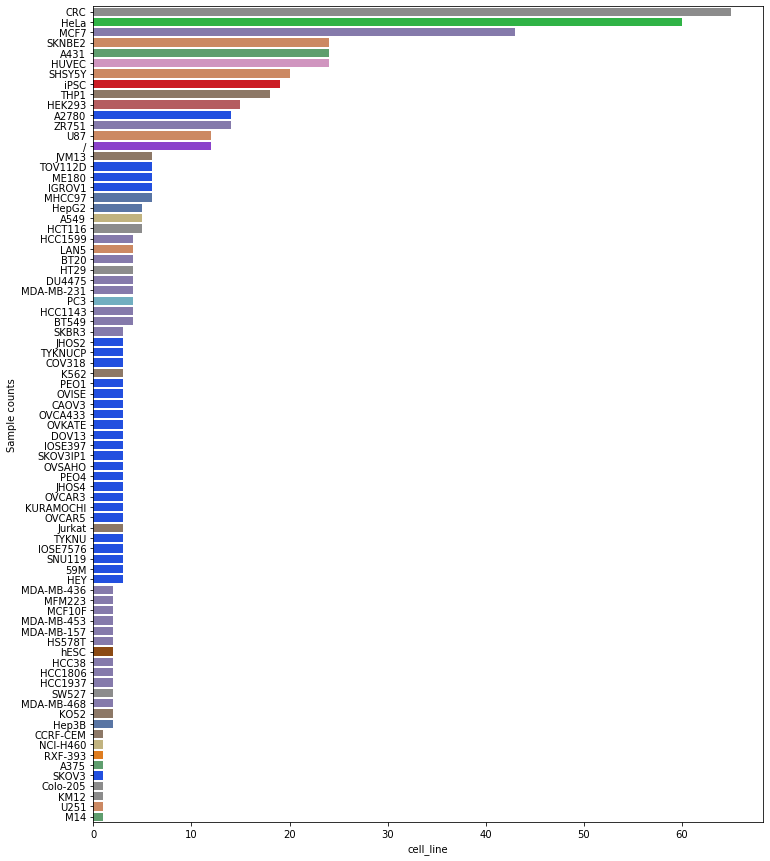

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,15))
plt.ylabel("Sample counts")
sns.barplot(x=meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts(), y = meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts().index, palette=cols)

In [4]:
# Only select groups with >= 10 samples
apc = meta.Group.value_counts(sort = True)
apc=apc[apc>=10]

meta = meta[meta.Group.isin(apc.index)]
nsaf = nsaf[nsaf.index.isin(meta.index)]

meta.sort_index(inplace=True)
nsaf.sort_index(inplace=True)
nsaf = nsaf.dropna(how="all", axis=1)

print(meta.shape, nsaf.shape)

(518, 20) (518, 14506)


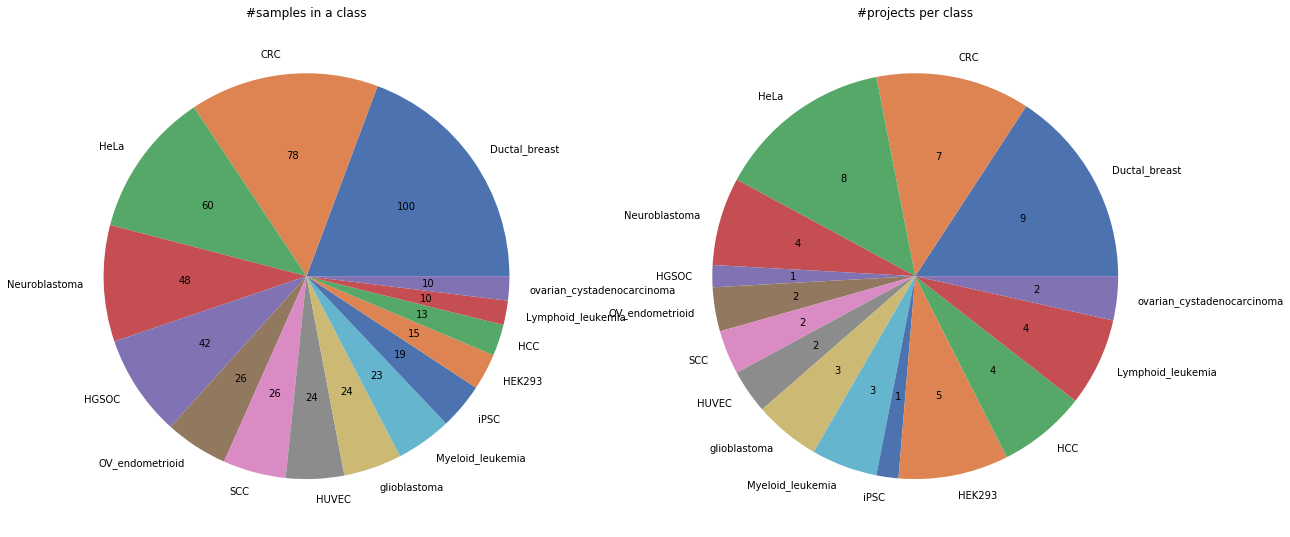

In [11]:
apc = meta.Group.value_counts(sort = True)
label_order = apc.index
ppc = meta.groupby("Group", sort = False).nunique().PXD_accession[label_order]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

plt.subplot(121)
plt.title("#samples in a class")
_ = plt.pie(apc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct= lambda p: '{:.0f}'.format(p*sum(apc.values)/100))

plt.subplot(122)
plt.title(r"#projects per class")
_ = plt.pie(ppc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct = lambda p: '{:.0f}'.format(p*sum(ppc.values)/100))

---

## How are missing values distributed?

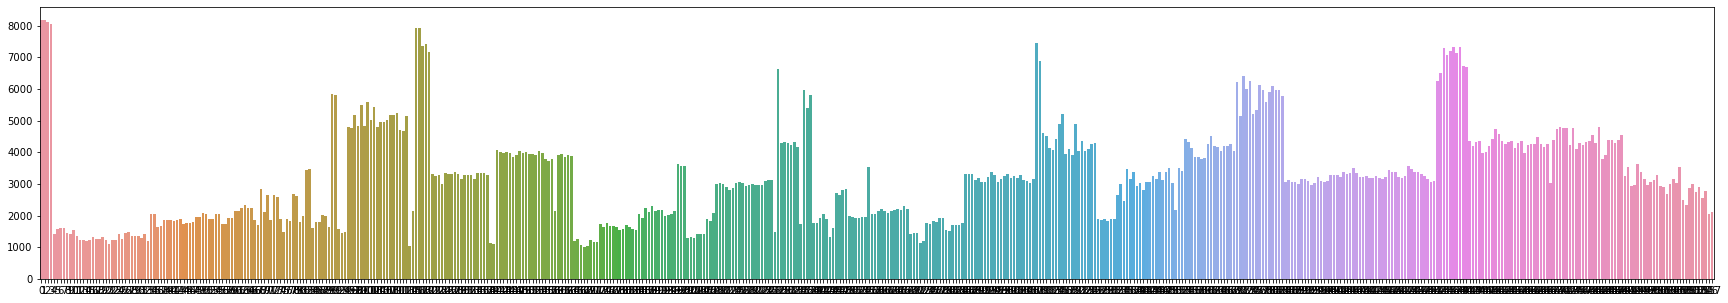

In [46]:
# Protein identification landscape
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf))), y=nsaf.notna().sum(axis=1))

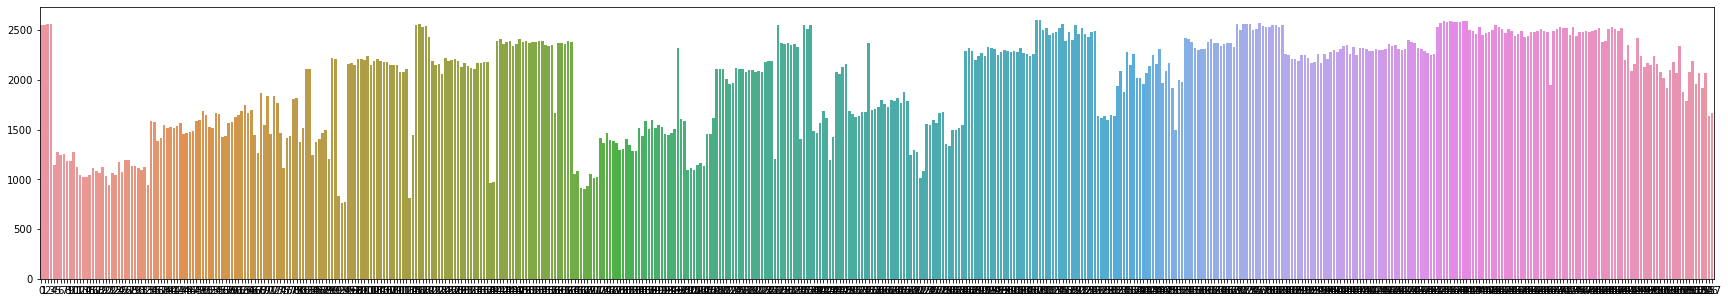

In [8]:
nsaf_filtered = uml.FilterByOccurence(.5).fit_transform(nsaf)

plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered))), y=nsaf_filtered.notna().sum(axis=1))

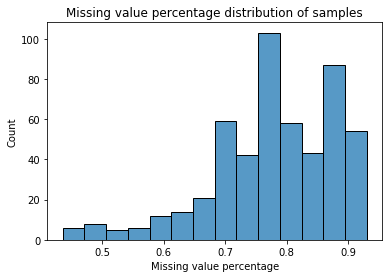

In [39]:
plt.figure()
plt.title("Missing value percentage distribution of samples")
plt.xlabel("Missing value percentage")
sns.histplot(nsaf.isna().sum(axis=1) / 14506)

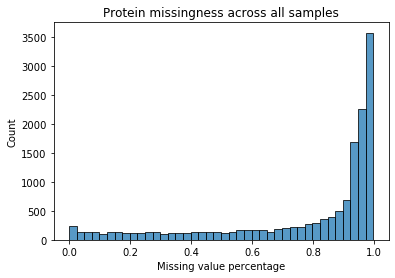

In [43]:
plt.title("Protein missingness across all samples")
plt.xlabel("Missing value percentage")
sns.histplot(nsaf.isna().sum(axis=0)/518)

In [23]:
print((nsaf.isna().sum(axis=1)/14506).max(), (nsaf.isna().sum(axis=1)/14506).min(), (nsaf.isna().sum(axis=1)/14506).mean())

0.9301668275196471 0.4360954087963601 0.7777753527098626


In [26]:
nsaf_filtered_50 = uml.FilterByOccurence(.5).fit_transform(nsaf)
print((nsaf_filtered_50.isna().sum(axis=1)/2615).max(), (nsaf_filtered_50.isna().sum(axis=1)/2615).min(), (nsaf_filtered_50.isna().sum(axis=1)/2615).mean())

0.7093690248565966 0.004206500956022944 0.24054054054054055


In [27]:
nsaf.isna().sum().sum() / (nsaf.shape[0]*nsaf.shape[1])

0.7777753527098625

In [28]:
nsaf_filtered_50.isna().sum().sum() / (nsaf_filtered_50.shape[0]*nsaf_filtered_50.shape[1])

0.24054054054054055

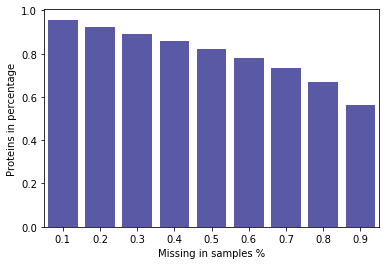

In [59]:
# X-axis: Protein absent in more than x% of all samples
# Y-axis: What fraction of the total uniquely identified proteins
# is absent in > X% of samples.

protein_missingness = []
for x in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    protein_missingness.append(((nsaf.isna().sum(axis=0)/518) > x).sum()/14506)

plt.xlabel('Missing in samples %')
plt.ylabel("Proteins in percentage")
sns.barplot(x=[.1,.2,.3,.4,.5,.6,.7,.8,.9], y=protein_missingness, color="b", saturation=.3)

In [6]:
lut = {}
for x in meta[meta.Group == "HeLa"].PXD_accession.unique():
    lut[x] = sns.color_palette("deep")[len(lut)]
cols = meta[meta.Group == "HeLa"].PXD_accession.apply(lambda x: lut[x])

In [40]:
print((nsaf.isna().sum(axis=1) / 14506).max(), (nsaf.isna().sum(axis=1) / 14506).min())

0.9301668275196471 0.4360954087963601


In [7]:
colors=sns.color_palette("bright")+sns.color_palette("pastel")
colors=colors[:15]

In [8]:
groups = meta.Group
lut_group = dict(zip(groups.unique(), colors))
row_colors = groups.map(lut_group)

In [82]:
from matplotlib.patches import Patch

<Figure size 720x720 with 0 Axes>

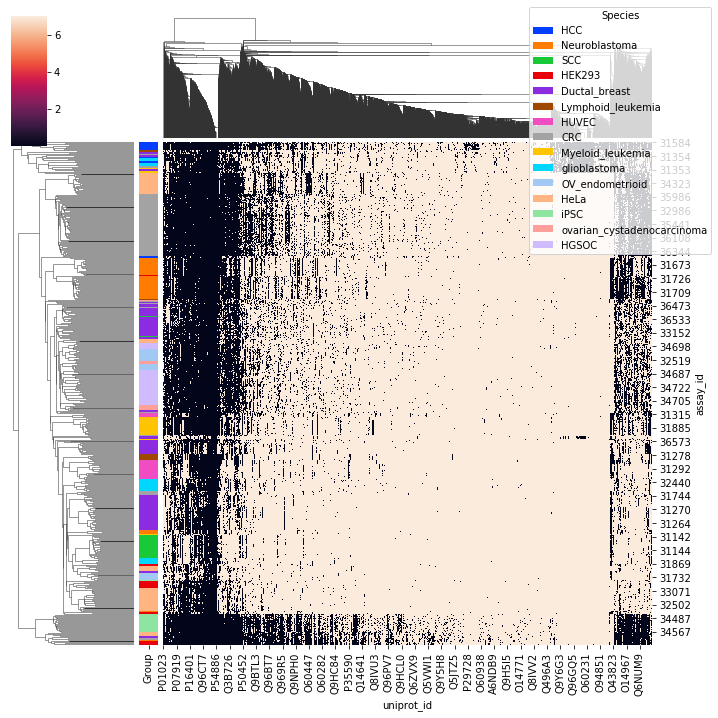

In [87]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf.fillna(7), row_colors=row_colors)

handles = [Patch(facecolor=lut_group[name]) for name in lut_group]
plt.legend(handles, lut_group, title='Group',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

<Figure size 720x720 with 0 Axes>

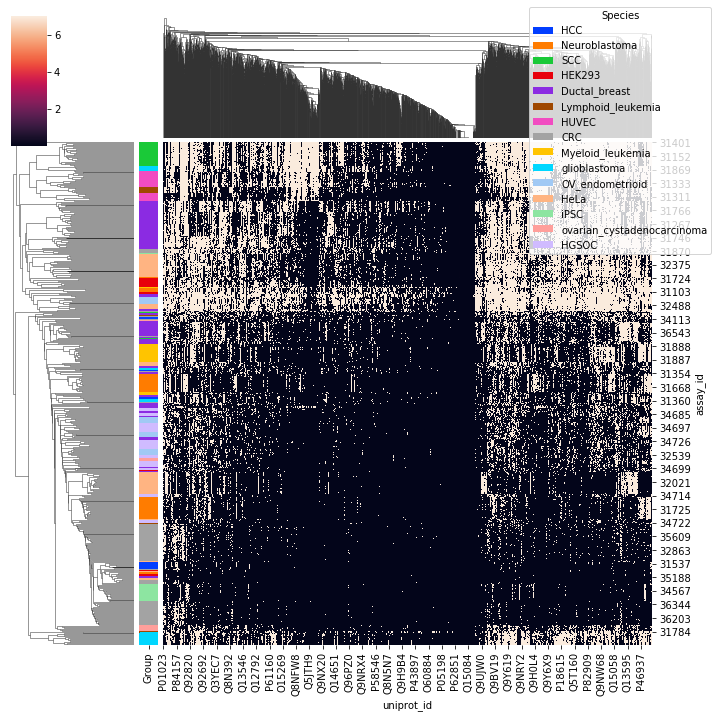

In [88]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf_filtered.fillna(7), row_colors=row_colors)

handles = [Patch(facecolor=lut_group[name]) for name in lut_group]
plt.legend(handles, lut_group, title='Species',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [5]:
# percentage missing values
print(nsaf.isna().sum().sum() / (nsaf_filtered.shape[0]*nsaf_filtered.shape[1]))

nsaf_filtered = uml.FilterByOccurence(.5).fit_transform(nsaf)

print(nsaf_filtered.isna().sum().sum()/ (nsaf_filtered.shape[0]*nsaf_filtered.shape[1]))

0.7232672545006751
0.24054054054054055


In [48]:
# percentage missing values
nsaf_filtered.isna().sum().sum()/ (nsaf_filtered.shape[0]*nsaf_filtered.shape[1])

0.24054054054054055

In [60]:
print((nsaf_filtered.isna().sum(axis=1) / 2615).max(), (nsaf_filtered.isna().sum(axis=1) / 2615).min())

0.7093690248565966 0.004206500956022944


In [23]:
filtered_90 = uml.FilterByOccurence(.9).fit_transform(nsaf_filtered)

In [54]:
print(filtered_90.shape)

(518, 636)


In [ ]:
palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values

In [9]:
mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

## Does different levels of missingness affect NSAF?

([], <a list of 0 Text xticklabel objects>)

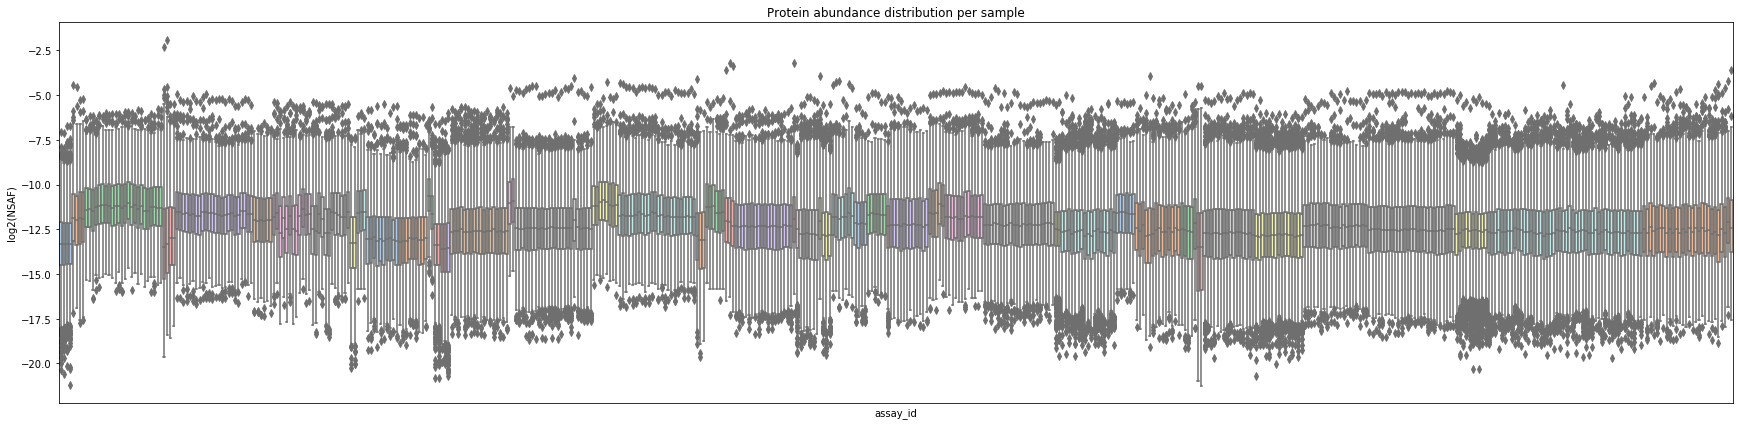

In [23]:
plt.figure(figsize=(30,7))
sns.boxplot(data=np.log2(nsaf_filtered.T.melt().dropna()), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
plt.title("Protein abundance distribution per sample")
plt.ylabel("log2(NSAF)")
plt.xticks(ticks=[])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Min log2(NSAF)')

<Figure size 504x504 with 0 Axes>

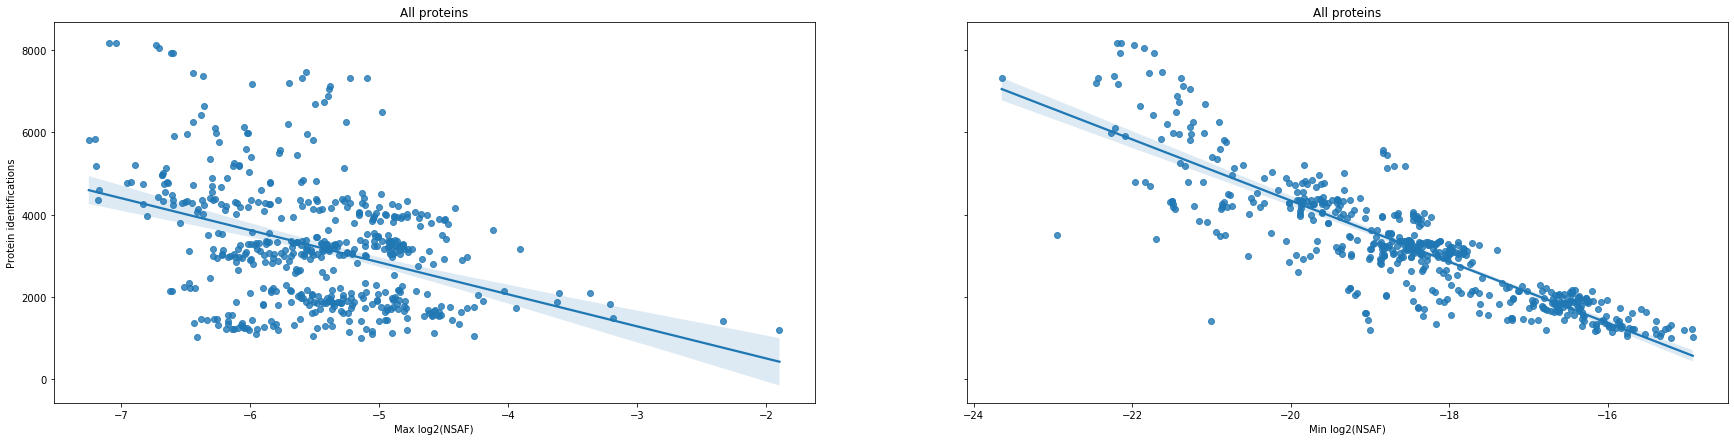

In [12]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots(1,2,figsize=(30,7), sharey=True)
sns.regplot(np.log2(nsaf).max(axis=1), nsaf.notna().sum(axis=1), ax=ax[0])
sns.regplot(np.log2(nsaf).min(axis=1), nsaf.notna().sum(axis=1), ax=ax[1])
plt.title("Median NSAF in relation to protein identifications")
ax[0].set_title("All proteins")
ax[1].set_title("All proteins")

ax[0].set_ylabel("Protein identifications")
ax[0].set_xlabel("Max log2(NSAF)")
ax[1].set_xlabel("Min log2(NSAF)")

In [21]:
from scipy.stats import spearmanr

# Filtered
print("Filtered")
max_corr = spearmanr(np.log2(nsaf).max(axis=1), nsaf.notna().sum(axis=1))
print("Max| Correlation: {:.2f}, p-value: {}".format(max_corr[0], max_corr[1]))
min_corr = spearmanr(np.log2(nsaf).min(axis=1), nsaf.notna().sum(axis=1))
print("Min| Correlation: {:.2f}, p-value: {}".format(min_corr[0], min_corr[1]))
median_corr = spearmanr(np.log2(nsaf).median(axis=1), nsaf.notna().sum(axis=1))
print("Median| Correlation: {:.2f}, p-value: {}".format(median_corr[0], median_corr[1]))

# Unfiltered
print("Unfiltered")
print("Filtered")
max_corr = spearmanr(np.log2(nsaf_filtered).max(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Max| Correlation: {:.2f}, p-value: {}".format(max_corr[0], max_corr[1]))
min_corr = spearmanr(np.log2(nsaf_filtered).min(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Min| Correlation: {:.2f}, p-value: {}".format(min_corr[0], min_corr[1]))
median_corr = spearmanr(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Median| Correlation: {:.2f}, p-value: {}".format(median_corr[0], median_corr[1]))

Filtered
Max| Correlation: -0.31, p-value: 3.0440324751322634e-13
Min| Correlation: -0.87, p-value: 4.750999932377996e-157
Median| Correlation: -0.93, p-value: 2.6317758788199555e-229
Unfiltered
Filtered
Max| Correlation: -0.25, p-value: 8.942195148414576e-09
Min| Correlation: -0.82, p-value: 8.517416975408614e-129
Median| Correlation: -0.75, p-value: 2.282335341792519e-94


In [24]:
print("90%")

median_corr = spearmanr(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Median| Correlation: {:.2f}, p-value: {}".format(median_corr[0], median_corr[1]))

90%
Median| Correlation: -0.55, p-value: 5.623249219796805e-43


In [ ]:
print("top 100")
print("Filtered")
max_corr = spearmanr(np.log2(nsaf_filtered).max(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Max| Correlation: {:.2f}, p-value: {}".format(max_corr[0], max_corr[1]))
min_corr = spearmanr(np.log2(nsaf_filtered).min(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Min| Correlation: {:.2f}, p-value: {}".format(min_corr[0], min_corr[1]))
median_corr = spearmanr(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1))
print("Median| Correlation: {:.2f}, p-value: {}".format(median_corr[0], median_corr[1]))

In [14]:
spearmanr(np.log2(nsaf_filtered).max(axis=1), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.24923054648367338, pvalue=8.942195148414576e-09)

In [15]:
spearmanr(np.log2(nsaf_filtered).min(axis=1), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.8229289507530458, pvalue=8.517416975408614e-129)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Median log2(NSAF)')

<Figure size 504x504 with 0 Axes>

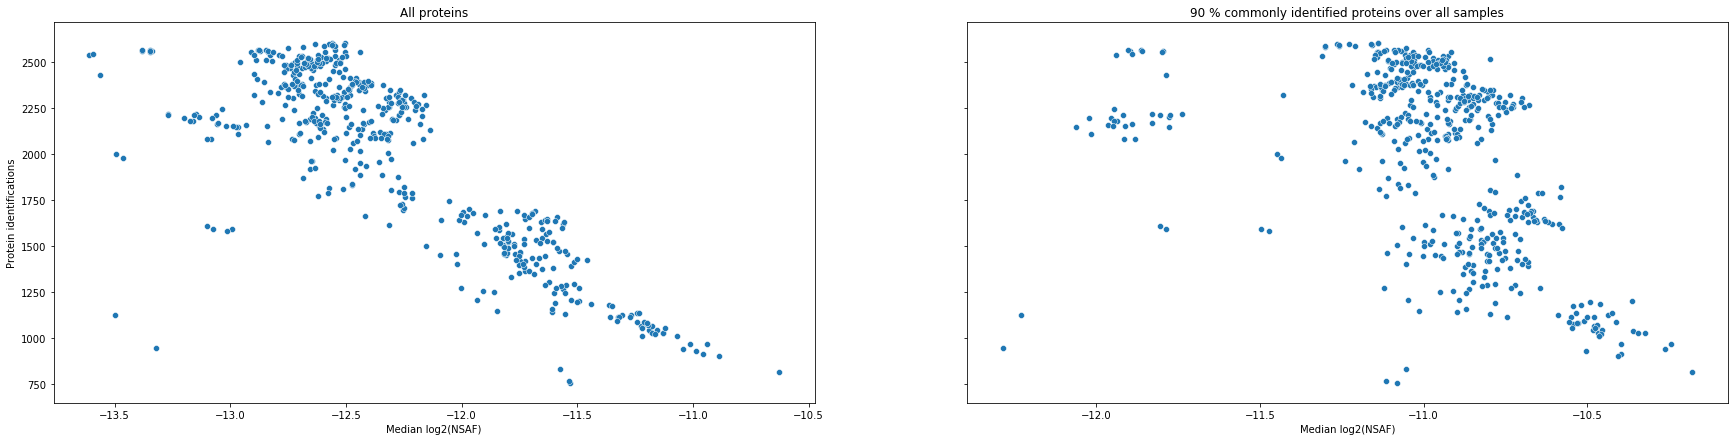

In [30]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots(1,2,figsize=(30,7), sharey=True)
sns.scatterplot(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])
plt.title("Median NSAF in relation to protein identifications")
ax[0].set_title("All proteins")
ax[1].set_title("90 % commonly identified proteins over all samples")

ax[0].set_ylabel("Protein identifications")
ax[1].set_xlabel("Median log2(NSAF)")
ax[0].set_xlabel("Median log2(NSAF)")

In [35]:
import scipy.stats
stats.pearsonr(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1))
stats.pearsonr(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))

(-0.4548155347128965, 8.261783205350072e-28)

In [41]:
filtered_100 = uml.FilterByOccurence(1).fit_transform(nsaf_filtered)

In [43]:
stats.spearmanr(np.log2(nsaf_filtered).loc[:, filtered_100.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.4102446684787211, pvalue=1.9038336843273984e-22)

In [45]:
filtered_90.shape

(518, 636)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


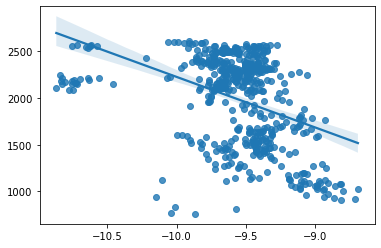

In [44]:
sns.regplot(np.log2(nsaf_filtered).loc[:, filtered_100.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))

In [37]:
stats.spearmanr(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.5538487094130862, pvalue=5.623249219796805e-43)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


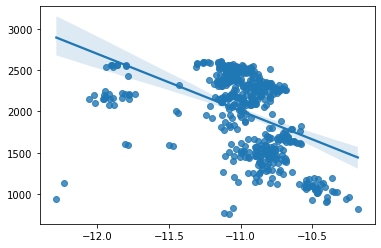

In [36]:
sns.regplot(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))

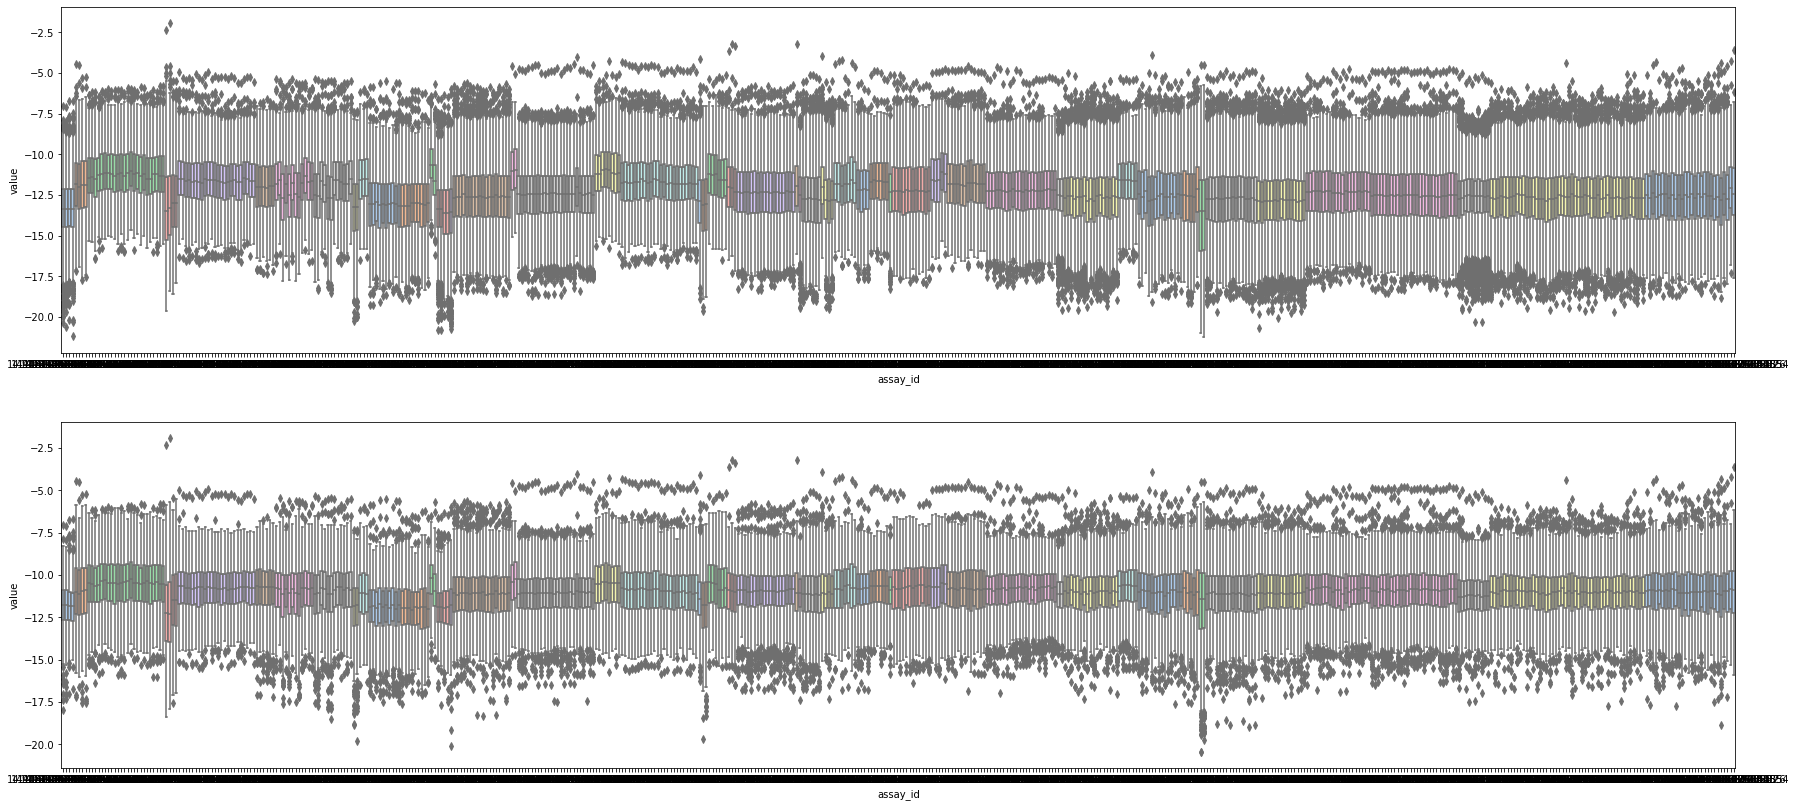

In [52]:
fig, ax = plt.subplots(2,1,figsize=(30,14))

sns.boxplot(data=np.log2(nsaf_filtered.T.melt().dropna()), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

sns.boxplot(data=np.log2(filtered_90.T.melt().dropna()), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


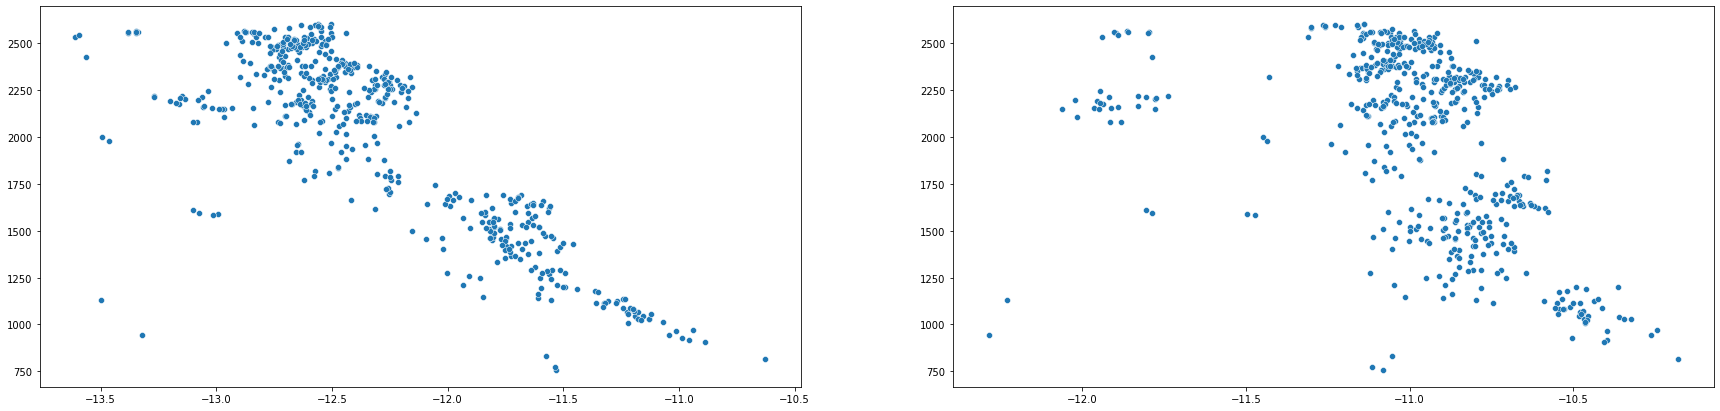

In [124]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


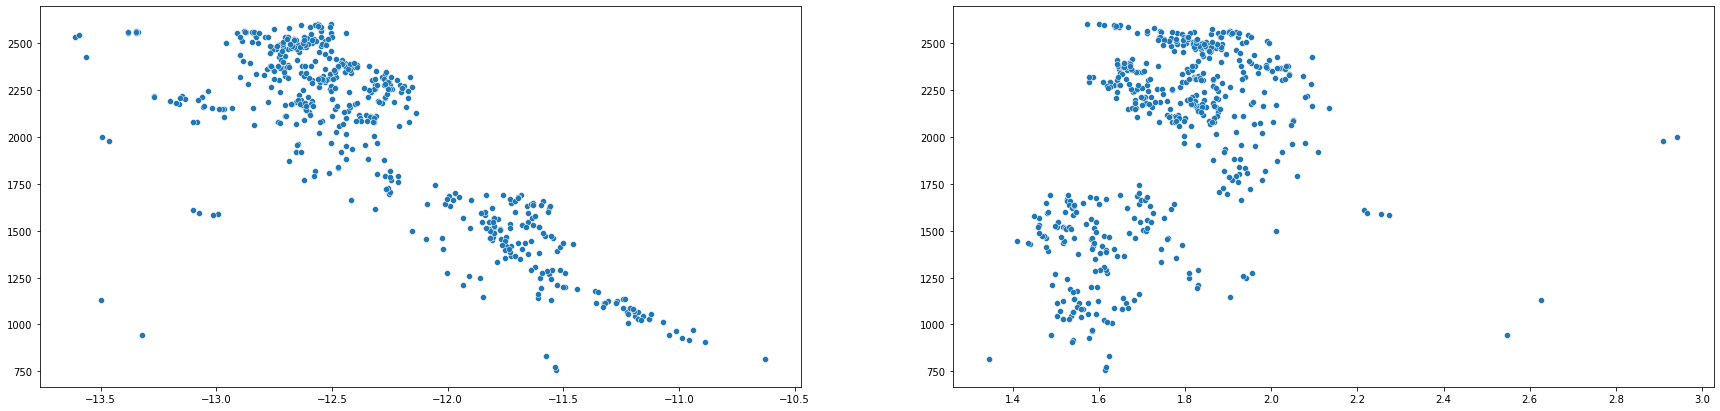

In [77]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(np.log2(nsaf_filtered).std(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

In [129]:
ranked_90 = nsaf_filtered.fillna(0).rank(axis=1, method="min")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


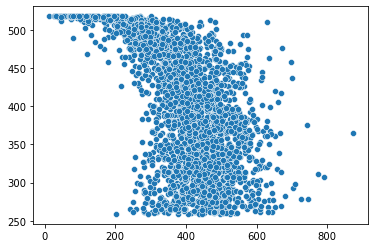

In [131]:
sns.scatterplot(ranked_90.replace(1,np.nan).std().sort_values(), nsaf_filtered.notna().sum())

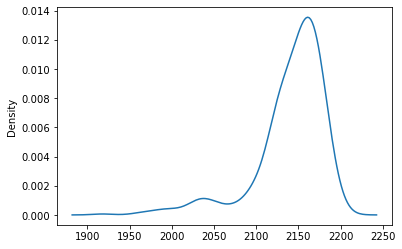

In [124]:
sns.kdeplot(ranked_90.median(axis=1))

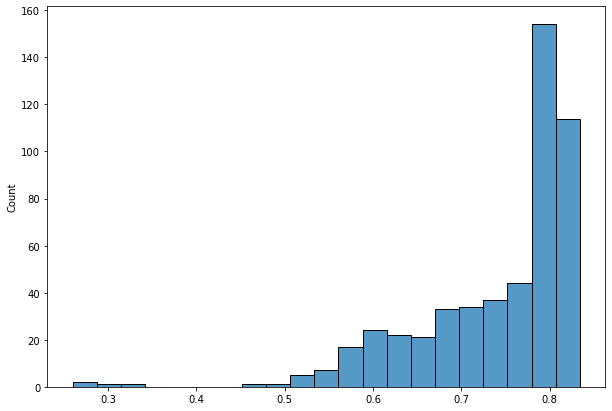

In [31]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

# Most of the selected proteins (90% identification rate) are the most abundant ones in the sample
plt.figure(figsize=(10,7))
sns.histplot(ranked_df.loc[:,filtered_90.columns].median(axis=1))

In [59]:
print(ranked_df.index[ranked_df.loc[:,filtered_90.columns].median(axis=1)<.4])
meta[ranked_df.loc[:,filtered_90.columns].median(axis=1)<.4]

Int64Index([31345, 31347, 31349, 31376], dtype='int64', name='assay_id')


project_id                   filename  cell_id cell_line  \
assay_id                                                             
31345           1826     130327_o2_02_hu_P1_2hr      562     SKBR3   
31347           1826     130327_o2_04_hu_P2_2hr      562     SKBR3   
31349           1826     130327_o2_06_hu_P3_2hr      562     SKBR3   
31376           1829  160116_K052_OffLRP_RP_f02      569      KO52   

                   disease treatment tissue_type sub_cell  organ_id  \
assay_id                                                              
31345       adenocarcinoma         /      breast        /       NaN   
31347       adenocarcinoma         /      breast        /       NaN   
31349       adenocarcinoma         /      breast        /       NaN   
31376     myeloid leukemia         /       blood        /       NaN   

         PXD_accession  all_PSM  sign_PSM  peptides  proteins experiment_type  \
assay_id                                                                        
31345        PXD002057     9453      8718      7501      1593     in-solution   
31347        PXD002057     8124      7517      6444      1464     in-solution   
31349        PXD002057     8309      7697      6630      1502     in-solution   
31376        PXD008381    23390       448       172       131     in-solution   

                   instrument      pmid  pool_id ionbot_version  \
assay_id                                                          
31345              Q-exactive  26883193        0  IONBOT_v0.8.0   
31347              Q-exactive  26883193        0  IONBOT_v0.8.0   
31349              Q-exactive  26883193        0  IONBOT_v0.8.0   
31376     Orbitrap Fusion ETD  30295032        1  IONBOT_v0.6.2   

                     Group  
assay_id                    
31345        Ductal_breast  
31347        Ductal_breast  
31349        Ductal_breast  
31376     Myeloid_leukemia

In [39]:
filtered_90.shape[1]

636

Text(0.5, 1.0, '100 most abundant proteins in each sample')

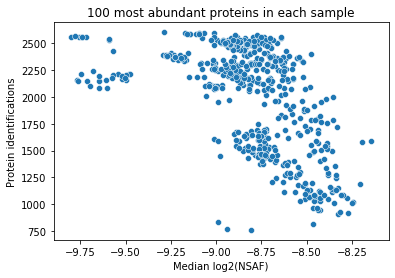

In [25]:
top_100_abundance = {}
top_prots = []
for i, row in np.log2(nsaf_filtered).iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_prots += list(row.dropna().sort_values(ascending=False).index[:100])

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("100 most abundant proteins in each sample")

In [39]:
nsaf.idxmax(axis=1).value_counts()

P62805    304
P09382     45
P31949     30
P30041     27
P62328     15
P04406     14
P10809     11
P00558     11
P14174      8
P60903      6
P63313      6
P07148      6
P60174      6
Q562R1      5
P08670      5
P25398      4
P26447      3
P23528      2
P04792      2
P16401      1
P25815      1
P30101      1
P08238      1
P01275      1
P30044      1
P31947      1
P05783      1
dtype: int64

In [27]:
stats.spearmanr(pd.DataFrame(top_100_abundance).median(axis=0), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.5655225856190466, pvalue=4.062913903567535e-45)

In [23]:
most_abundant_prots = list(set(top_prots))

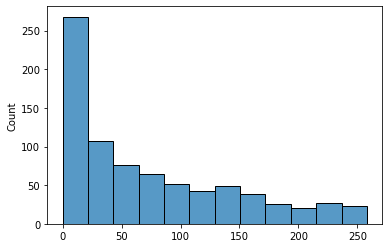

In [12]:
sns.histplot(nsaf_filtered.loc[:,most_abundant_prots].isna().sum())

In [24]:
len(most_abundant_prots)

792

## Perform equalise medians normalisation

In [46]:
med_std = pd.DataFrame(index=nsaf_filtered.index)
med_std["med"] = np.log2(filtered_90).median(axis=1)
med_std["std_"] = np.log2(filtered_90).std(axis=1)
scaled_nsaf = {}
for i, row in np.log2(nsaf_filtered).iterrows():
    scaled_nsaf[i] = (np.array(row) - med_std.loc[i,"med"]) / med_std.loc[i,"std_"]

scaled_nsaf = pd.DataFrame(scaled_nsaf, index=nsaf_filtered.columns).T

Text(0.5, 1.0, '100 most abundant proteins in each sample (equalize medians)')

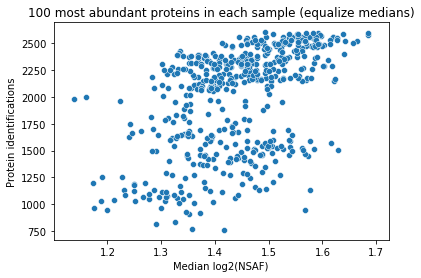

In [21]:
top_100_abundance = {}
for i, row in scaled_nsaf.iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("100 most abundant proteins in each sample (equalize medians)")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log2
  """Entry point for launching an IPython kernel.
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Subset (792): union of 100 most abundant proteins in each sample\nEqualize medians')

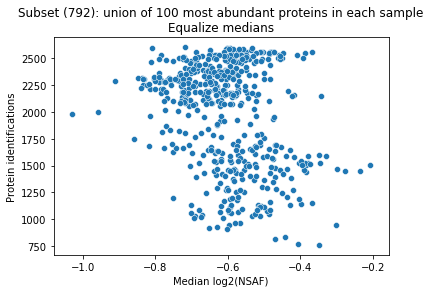

In [27]:
sns.scatterplot(np.log2(scaled_nsaf.loc[:,most_abundant_prots]).median(axis=1), nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median NSAF")
plt.title("Subset (792): union of 100 most abundant proteins in each sample\nEqualize medians")

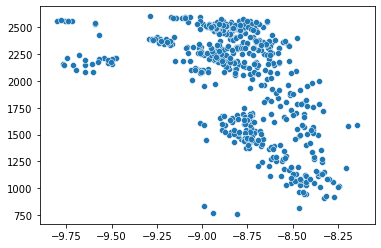

In [16]:
top_100_abundance = {}
for i, row in np.log2(nsaf_filtered).iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))

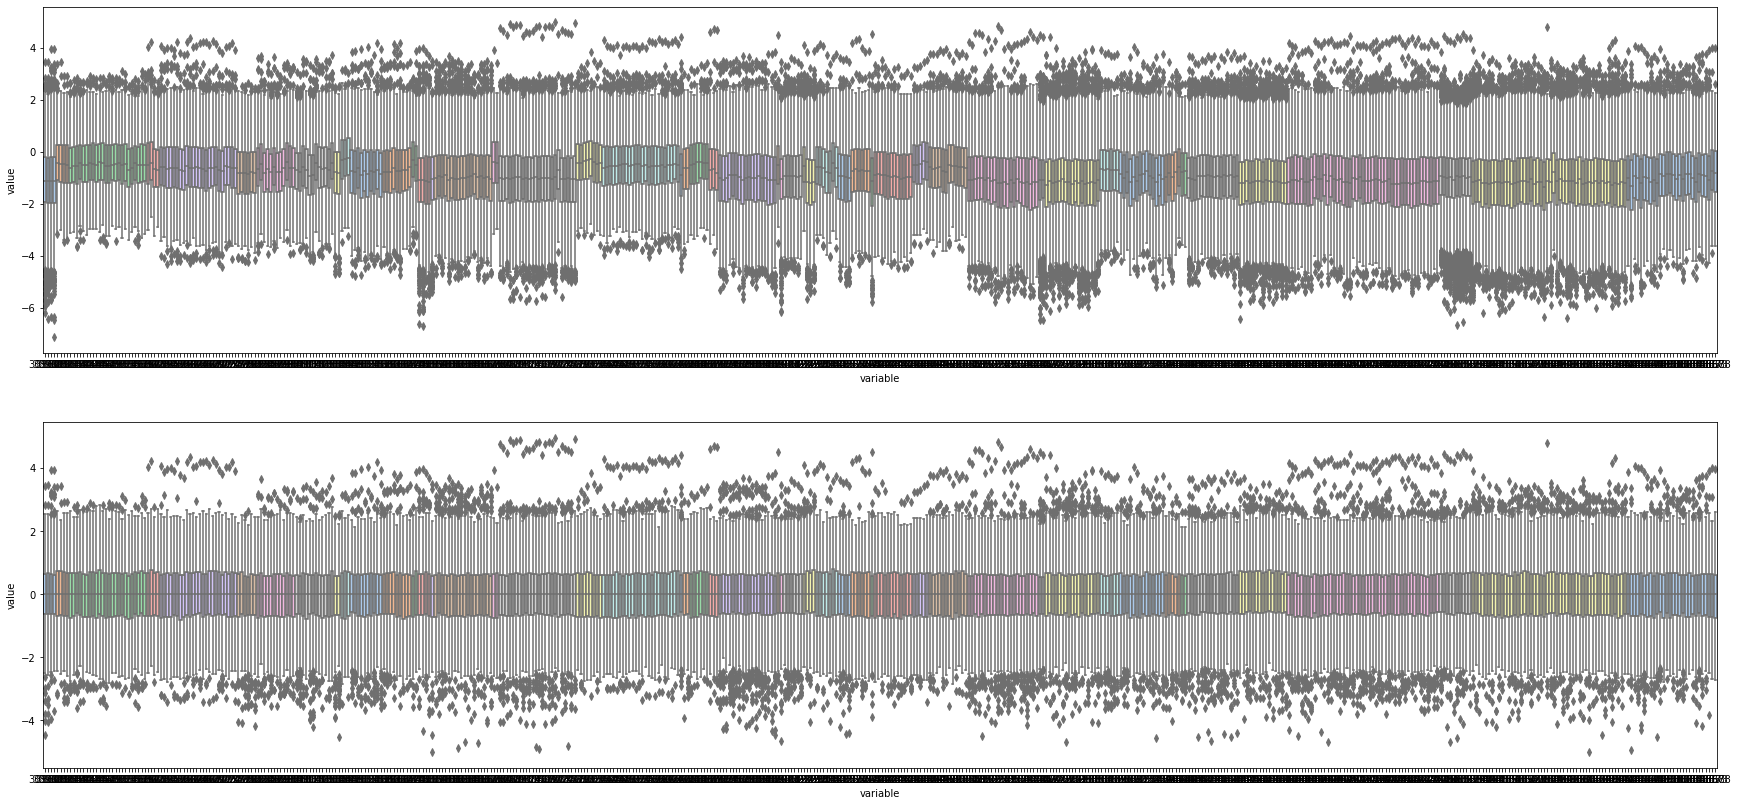

In [110]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=scaled_nsaf.T.melt().dropna(), y='value', x="variable", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=scaled_nsaf.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="variable", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Median log2(NSAF)')

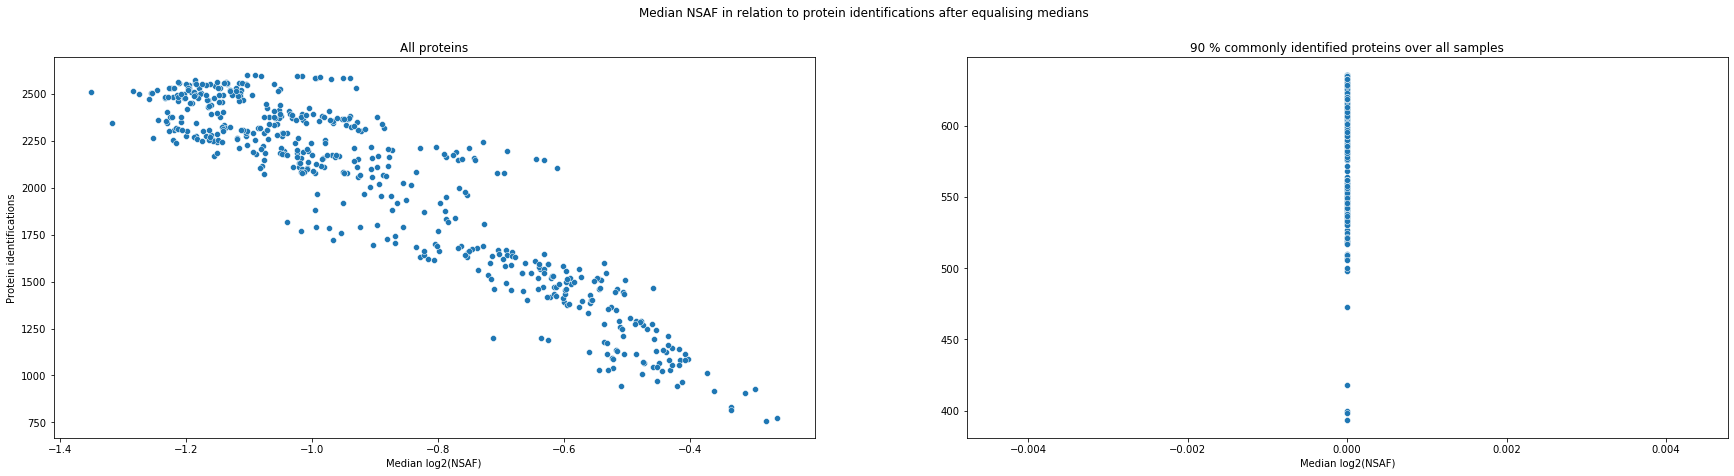

In [87]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
fig.suptitle("Median NSAF in relation to protein identifications after equalising medians")
sns.scatterplot(scaled_nsaf.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(scaled_nsaf.loc[:, filtered_90.columns].median(axis=1), scaled_nsaf.loc[:, filtered_90.columns].notna().sum(axis=1), ax=ax[1])

ax[0].set_title("All proteins")
ax[1].set_title("90 % commonly identified proteins over all samples")

ax[0].set_ylabel("Protein identifications")
ax[1].set_xlabel("Median log2(NSAF)")
ax[0].set_xlabel("Median log2(NSAF)")

In [57]:
# Hela samples from different projects
nsaf_filtered.loc[[32003,32009,33066]].notna().sum(axis=1)

assay_id
32003    2368
32009    2365
33066    1637
dtype: int64

In [15]:
not_na_cols = nsaf_filtered.loc[[32003,32009],:].dropna(how="any", axis=1).columns

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    0.980190  Within project    HCC
 1    0.816349  Within project    HCC
 2    0.813129  Within project    HCC
 3    0.805534  Within project    HCC
 4    0.804413  Within project    HCC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    0.873757  Within project  HGSOC
 1    0.875513  Within project  HGSOC
 2    0.788131  Within project  HGSOC
 3    0.778475  Within project  HGSOC
 4    0.790197  Within project  HGSOC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [861 rows x 3 columns])

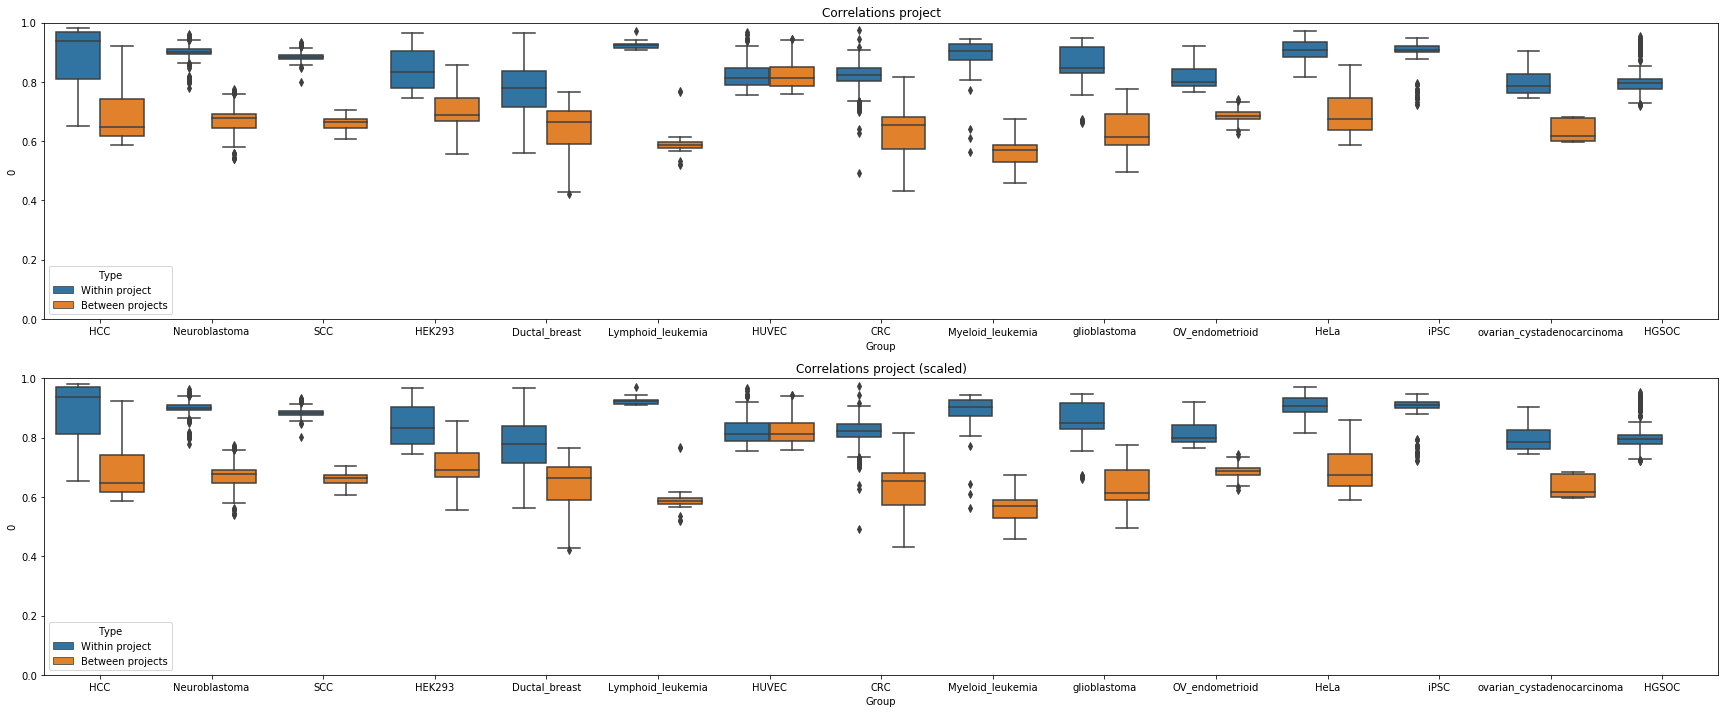

In [145]:
calculate_correlations_bygroup(scaled_nsaf)

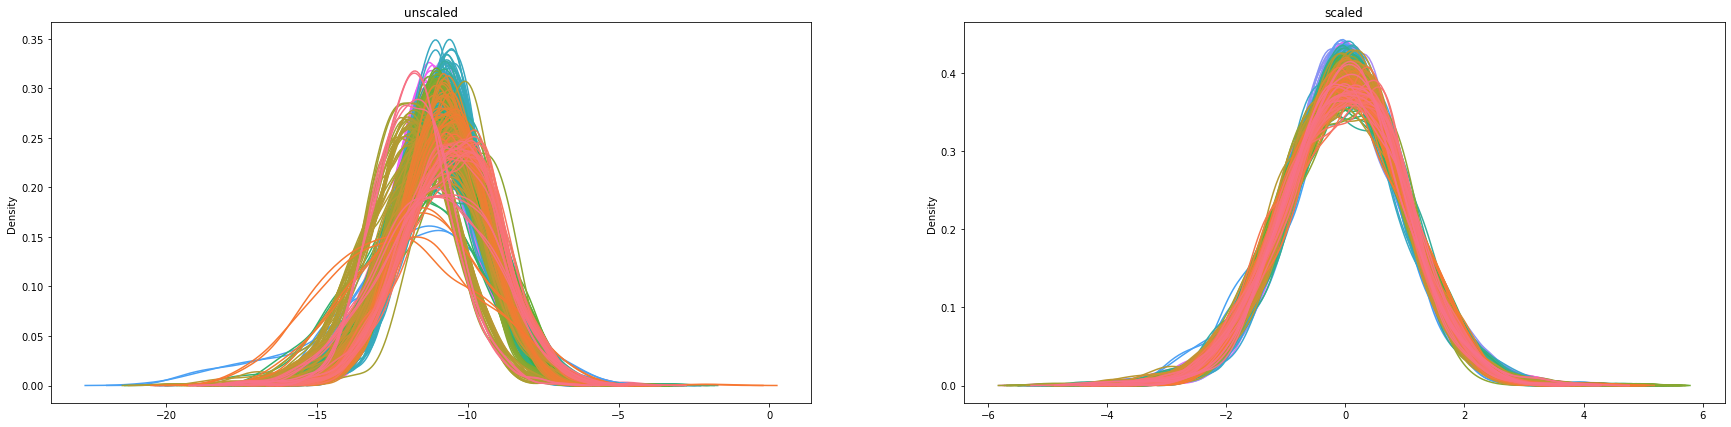

In [82]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('unscaled')
sns.kdeplot(data=np.log2(nsaf_filtered.loc[:, filtered_90.columns]).transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("scaled")
sns.kdeplot(data=scaled_nsaf.loc[:, filtered_90.columns].transpose(), legend = False, common_norm=False, ax =ax[1])

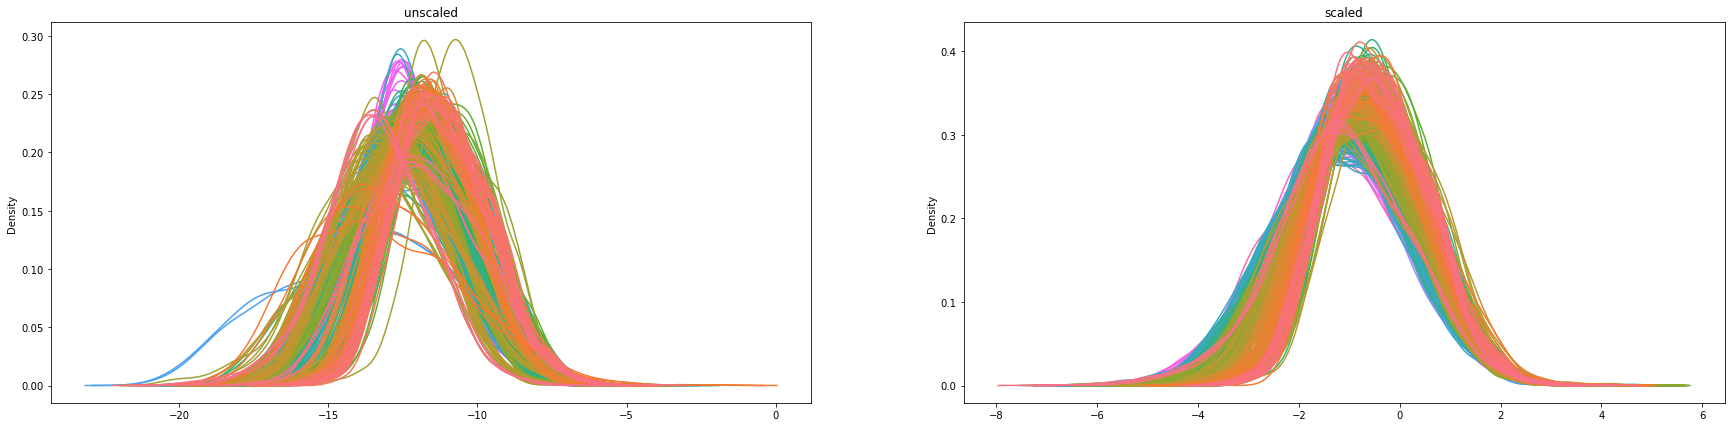

In [81]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('unscaled')
sns.kdeplot(data=np.log2(nsaf_filtered).transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("scaled")
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, common_norm=False, ax =ax[1])

---

# Quantile normalization

In [47]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

In [48]:
sorted_arrays = []
for i, row in np.log2(nsaf_filtered).iterrows():
    
    # Sorts the row from smallest to biggest and putting the nans at the back
    row = np.sort(np.array(row))
    sorted_arrays.append(row)
sorted_df = pd.DataFrame(sorted_arrays)

In [49]:
rank_mean = sorted_df.mean().sort_values()
rank_median = sorted_df.median().sort_values()

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


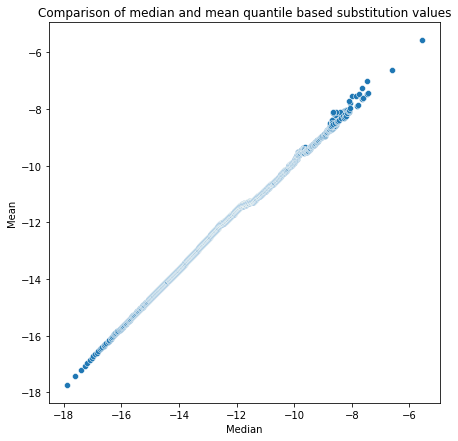

In [72]:
plt.figure(figsize=(7,7))
plt.xlabel("Median")
plt.ylabel("Mean")
#plt.ylim((-.001,.01))
#plt.xlim((-.001, 0.01))
plt.title("Comparison of median and mean quantile based substitution values")
sns.scatterplot(x=rank_median.dropna(),
                y=rank_mean.dropna())
#plt.plot([0,.01], [0,.01], color='r')

In [50]:
rank_median.rename(columns={"Rank_substitution": "Median"}, inplace=True)
rank_mean.name = "Mean"

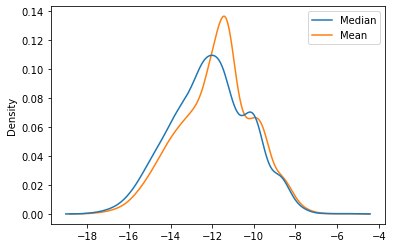

In [130]:
sns.kdeplot(data=pd.concat([rank_median, rank_mean], axis=1))

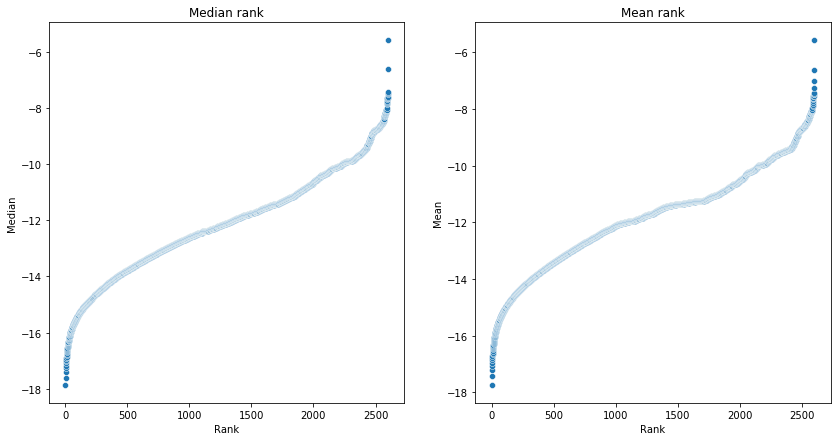

In [73]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
#ax[0].set_ylim((-.001, 0.01))
#ax[1].set_ylim((-.001, 0.01))
ax[0].set_title("Median rank")
ax[1].set_title("Mean rank")

ax[0].set_ylabel("Median")
ax[1].set_ylabel("Mean")

ax[0].set_xlabel("Rank")
ax[1].set_xlabel("Rank")

sns.scatterplot(x=list(range(len(rank_median.dropna()))), y=rank_median.dropna(), ax=ax[0])
sns.scatterplot(x=list(range(len(rank_mean.dropna()))), y=rank_mean.dropna(), ax=ax[1])

In [51]:
rank_median = pd.DataFrame(rank_median.dropna(), columns=["Rank_substitution"])
rank_median["index"] = list(range(len(rank_median), 0,-1))
rank_median = rank_median.set_index("index")
rank_mapper = {float(x):rank_median.loc[x].values[0] for x in range(1,len(rank_median)+1)}
rank_median

Rank_substitution
index                   
2604          -17.876127
2603          -17.608116
2602          -17.415085
2601          -17.272425
2600          -17.183880
...                  ...
5              -7.487611
4              -7.464297
3              -7.437607
2              -6.616180
1              -5.565813

[2604 rows x 1 columns]

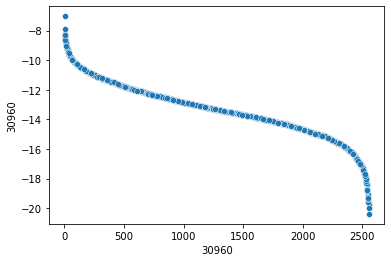

In [66]:
sns.scatterplot(x=nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False).iloc[0,:], y=np.log2(nsaf_filtered.iloc[0,:]))

In [53]:
ranked_df = nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False)

In [52]:
import math
def replace_values(x):
    if np.isnan(x):
        return np.nan
    elif x not in rank_mapper.keys():
        return np.mean([rank_mapper[math.ceil(x)], rank_mapper[math.ceil(x)-1]])
    else:
        return rank_mapper[x]

In [54]:
quantile_normalized_df = ranked_df.applymap(lambda x: replace_values(x))

In [55]:
quantile_normalized_df.max(axis=1)

assay_id
30960   -5.565813
30961   -5.565813
31008   -5.565813
31009   -5.565813
31102   -5.565813
           ...   
36558   -5.565813
36563   -5.565813
36568   -5.565813
36573   -5.565813
36578   -5.565813
Length: 518, dtype: float64

In [48]:
pd.DataFrame(top_100_abundance).median(axis=0).sort_values()

31766   -8.545695
33070   -8.545695
31648   -8.543901
33071   -8.543901
31275   -8.543901
           ...   
31889   -8.541445
32357   -8.541445
33067   -8.541445
32342   -8.540782
32502   -8.530679
Length: 518, dtype: float64

Text(0.5, 1.0, '100 most abundant proteins in each sample (Quantile normalised)')

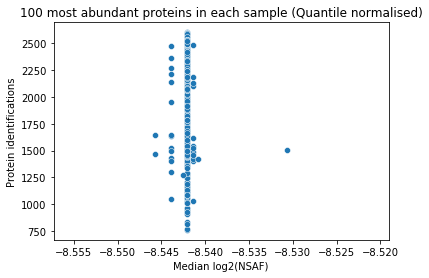

In [56]:
top_100_abundance = {}
top_prots = []
for i, row in quantile_normalized_df.iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_prots += list(row.dropna().sort_values(ascending=False).index[:100])

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("100 most abundant proteins in each sample (Quantile normalised)")

In [57]:
stats.spearmanr(pd.DataFrame(top_100_abundance).median(axis=0), nsaf_filtered.notna().sum(axis=1))

SpearmanrResult(correlation=-0.0015128550541095582, pvalue=0.9725989834929158)

Text(0.5, 1.0, 'Subset (792): union of 100 most abundant proteins in each sample')

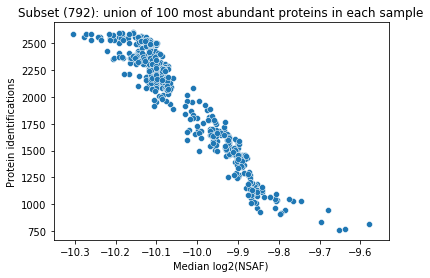

In [55]:
sns.scatterplot(x=quantile_normalized_df.loc[:,most_abundant_prots].median(axis=1), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("Subset (792): union of 100 most abundant proteins in each sample")

In [ ]:
sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))

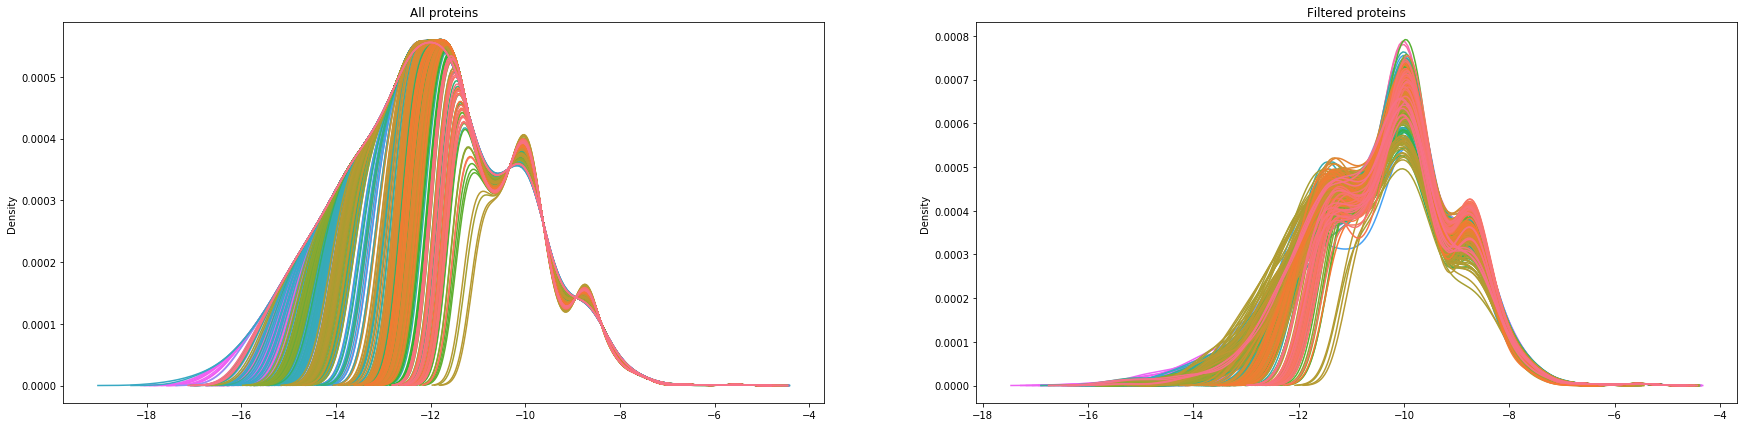

In [118]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=quantile_normalized_df.transpose(), legend = False, common_norm=True, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=quantile_normalized_df.loc[:, filtered_90.columns].transpose(), legend = False, common_norm=True, ax =ax[1])

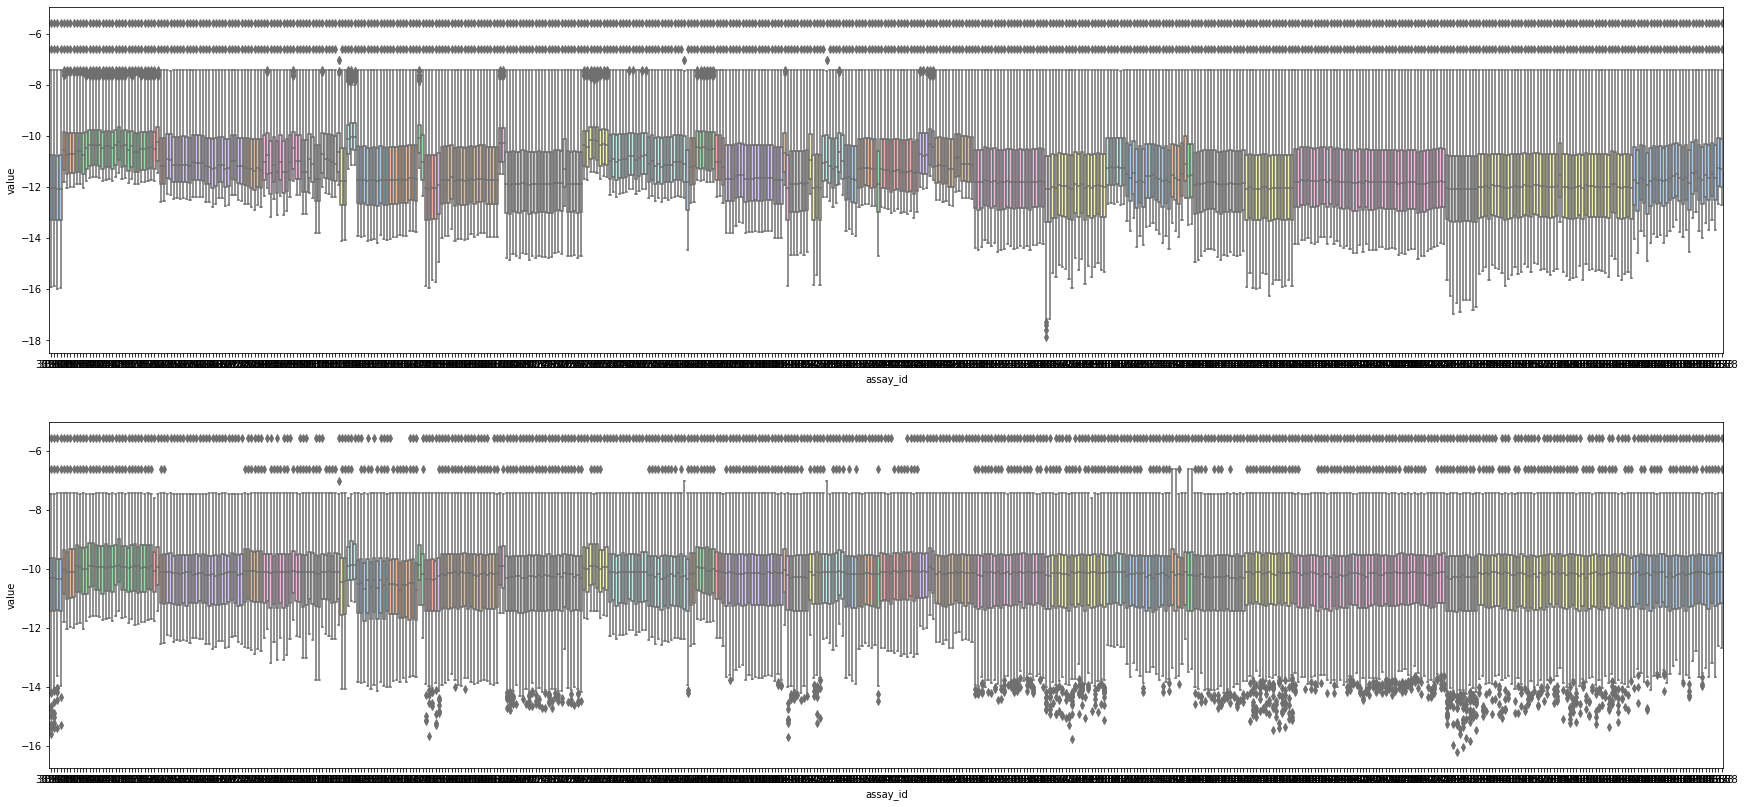

In [111]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=quantile_normalized_df.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=quantile_normalized_df.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

In [8]:
meta.iloc[[0,1,20]]

project_id          filename  cell_id cell_line  \
assay_id                                                    
30960           1815            3B10-1      545     Hep3B   
30961           1815            3B10-2      545     Hep3B   
31150           1819  A431_1uM_DON_1_1      554      A431   

                               disease       treatment tissue_type sub_cell  \
assay_id                                                                      
30960         hepatocellular carcinoma               /       liver        /   
30961         hepatocellular carcinoma               /       liver        /   
31150     Skin squamous cell carcinoma  deoxynivalenol        skin        /   

          organ_id PXD_accession  all_PSM  sign_PSM  peptides  proteins  \
assay_id                                                                  
30960          NaN     PXD000533    11014     10578      9705      2401   
30961          NaN     PXD000533    11530     11036     10104      2449   
31150          NaN     PXD008996    80722     15812      5327      1241   

         experiment_type  instrument      pmid  pool_id ionbot_version Group  
assay_id                                                                      
30960        in-solution  Q-exactive  24328083        1  IONBOT_v0.8.0   HCC  
30961        in-solution  Q-exactive  24328083        2  IONBOT_v0.8.0   HCC  
31150             in-gel  Q-exactive  30054545        0  IONBOT_v0.6.2   SCC

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


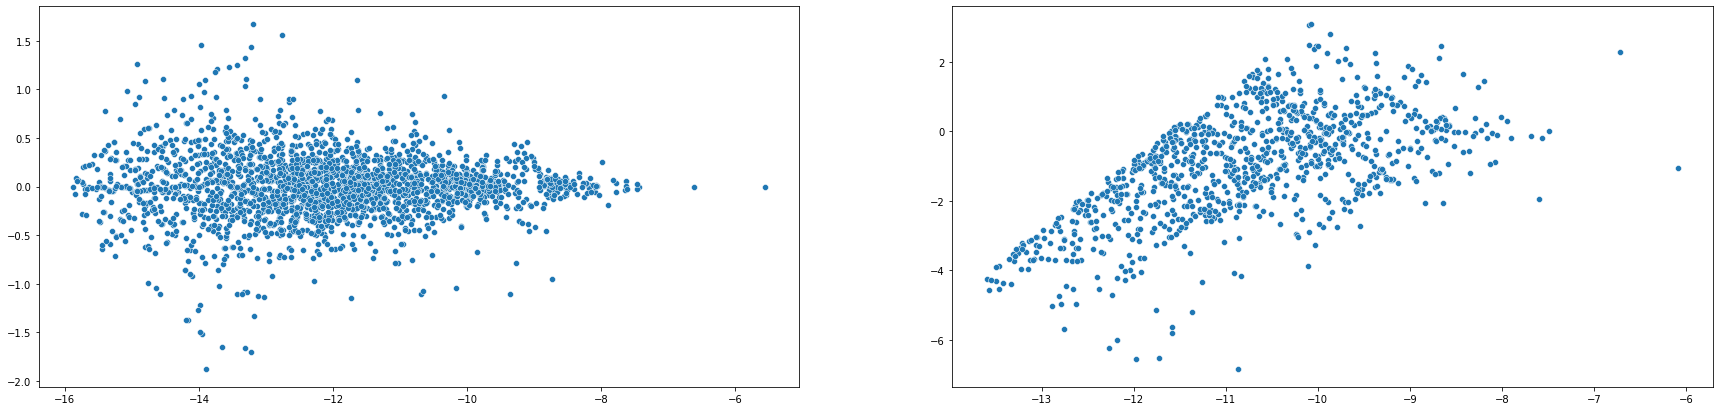

In [116]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(quantile_normalized_df.iloc[[0,1],:].mean(axis=0), quantile_normalized_df.iloc[0,:].subtract(quantile_normalized_df.iloc[1,:]), ax=ax[0])
sns.scatterplot(quantile_normalized_df.iloc[[0,20],:].mean(axis=0), quantile_normalized_df.iloc[0,:].subtract(quantile_normalized_df.iloc[20,:]), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Median log2(NSAF)')

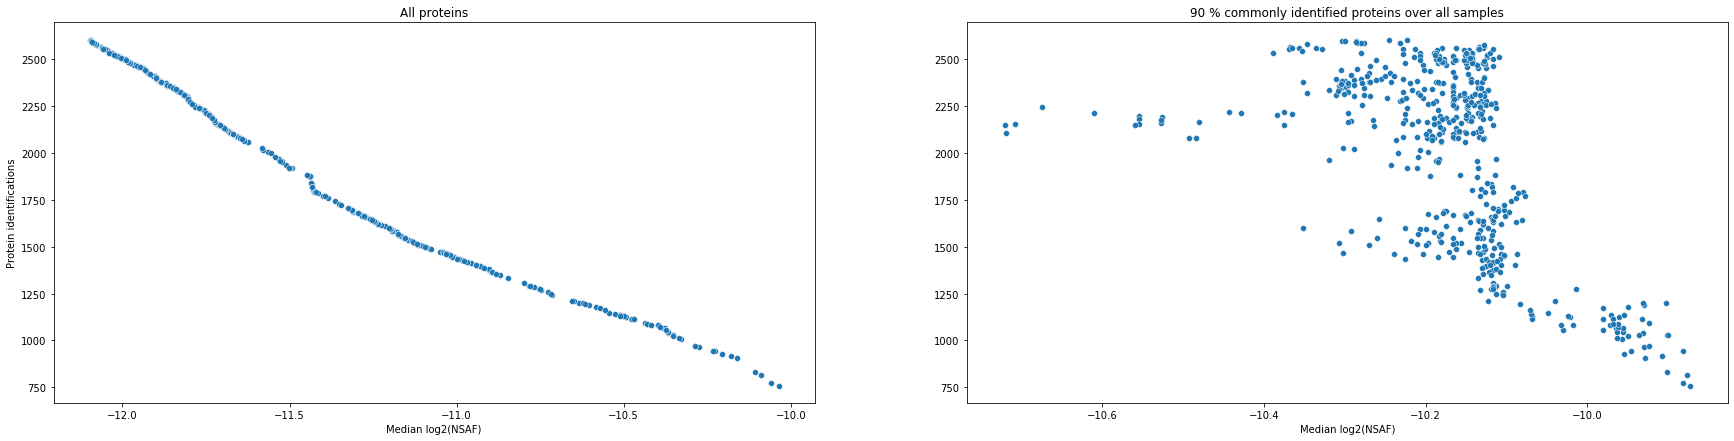

In [17]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(quantile_normalized_df.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(quantile_normalized_df.loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

plt.title("Median NSAF in relation to protein identifications")
ax[0].set_title("All proteins")
ax[1].set_title("90 % commonly identified proteins over all samples")

ax[0].set_ylabel("Protein identifications")
ax[1].set_xlabel("Median log2(NSAF)")
ax[0].set_xlabel("Median log2(NSAF)")

In [84]:
quantile_normalized_df.to_csv("quantile_norm_NSAF_50.csv")

In [85]:
from itertools import combinations

In [36]:
def calculate_correlations_bygroup(scaled_dataset):

    groups = meta.Group.unique()

    within_corr_g = []
    between_corr_g = []
    within_corr_sca_g = []
    between_corr_sca_g = []

    for group in groups:

        within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == group].index)
        within_corr_sca, between_corr_sca = calculate_correlations(scaled_dataset, meta[meta.Group == group].index)

        all_within_corr = []
        for px, x in within_corr.items():
            all_within_corr+=x
            #print(px, np.mean(x))

        all_between_corr = []
        for x in between_corr.values():
            all_between_corr += x

        all_within_corr_sca = []
        for px, x in within_corr_sca.items():
            all_within_corr_sca+=x
            #print(px, np.mean(x))

        all_between_corr_sca = []
        for x in between_corr_sca.values():
            all_between_corr_sca += x

        within_corr_g.append(all_within_corr)
        between_corr_g.append(all_between_corr)
        within_corr_sca_g.append(all_within_corr_sca)
        between_corr_sca_g.append(all_between_corr_sca)

    fig, ax = plt.subplots(2,1, figsize=(30,12))

    ax[0].set_title("Correlations project")
    ax[0].set_ylim((0,1))
    ax[1].set_title("Correlations project (scaled)")
    ax[1].set_ylim((0,1))

    dfs = []
    dfs_sca = []

    for i, g in enumerate(groups):

        all_within = pd.DataFrame(data=within_corr_g[i])
        all_within["Type"] = "Within project"
        all_between = pd.DataFrame(data=between_corr_g[i])
        all_between["Type"] = "Between projects"
        corr_df = pd.concat([all_within,all_between])
        corr_df["Group"] = g
        dfs.append(corr_df)

        all_within_sca = pd.DataFrame(data=within_corr_sca_g[i])
        all_within_sca["Type"] = "Within project"
        all_between_sca = pd.DataFrame(data=between_corr_sca_g[i])
        all_between_sca["Type"] = "Between projects"
        corr_df_sca = pd.concat([all_within_sca,all_between_sca])
        corr_df_sca["Group"] = g
        dfs_sca.append(corr_df_sca)
    
    corr_df_g = pd.concat(dfs)
    corr_df_sca_g = pd.concat(dfs_sca)

    sns.boxplot(data=corr_df_g,x="Group", y=0, hue="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca_g,x="Group", y=0, hue="Type", ax=ax[1])

    return corr_df_g, corr_df_sca

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



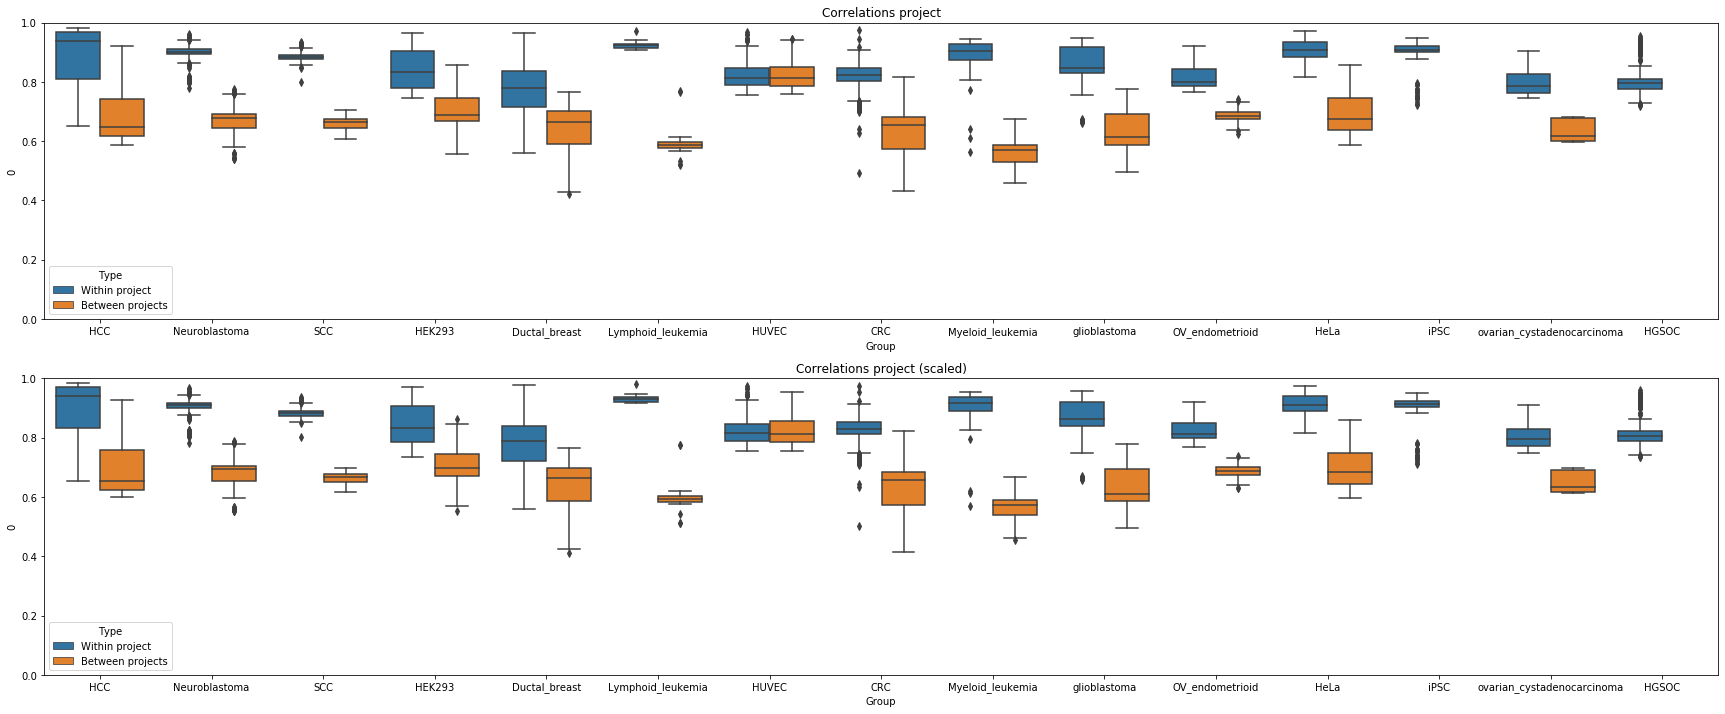

In [144]:
corr_df_quant, corr_df_scaled_quant = calculate_correlations_bygroup(quantile_normalized_df)

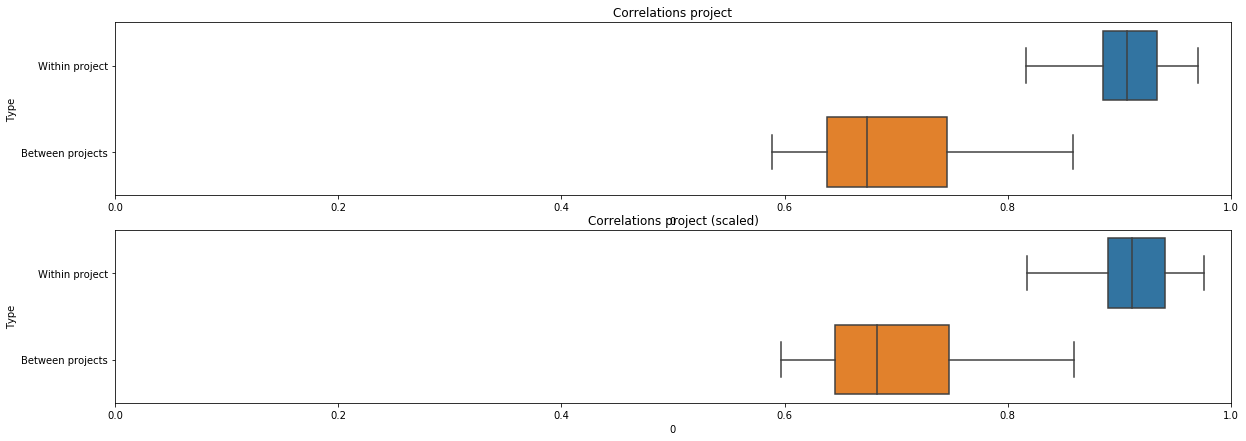

In [90]:
calculate_correlations_bygroup("HeLa", quantile_normalized_df)

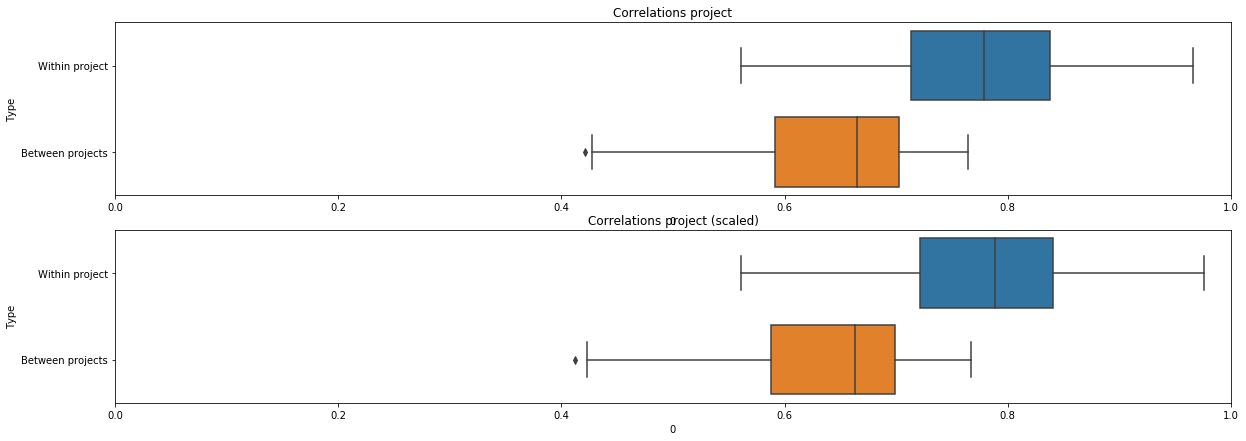

In [91]:
calculate_correlations_bygroup("Ductal_breast", quantile_normalized_df)

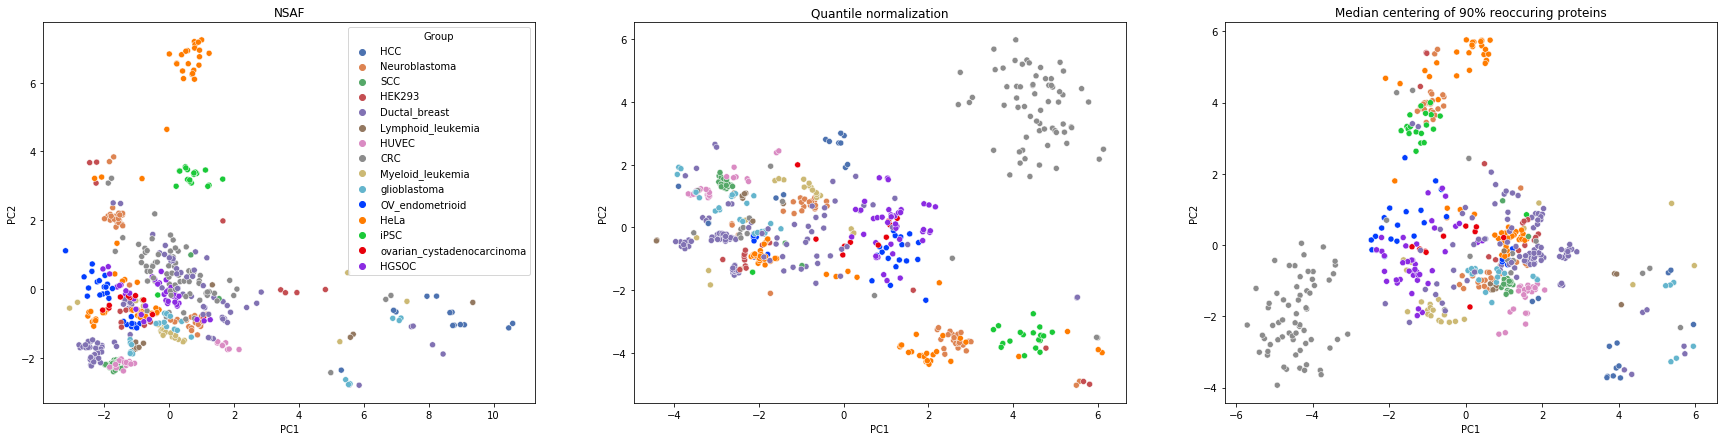

In [71]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1.fit(np.log2(nsaf_filtered))
X1 = imputer1.transform(np.log2(nsaf_filtered))
X1 = scaler.fit_transform(X1)

imputer2 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer2.fit(quantile_normalized_df)
X2 = imputer2.transform(quantile_normalized_df)
X2 = scaler.fit_transform(X2)

imputer3 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer3.fit(scaled_nsaf)
X3 = imputer3.transform(scaled_nsaf)
X3 = scaler.fit_transform(X3)

fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = PCA(n_components=2).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], ax=ax[0])

embedding = PCA(n_components=2).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1])

embedding = PCA(n_components=2).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[2])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

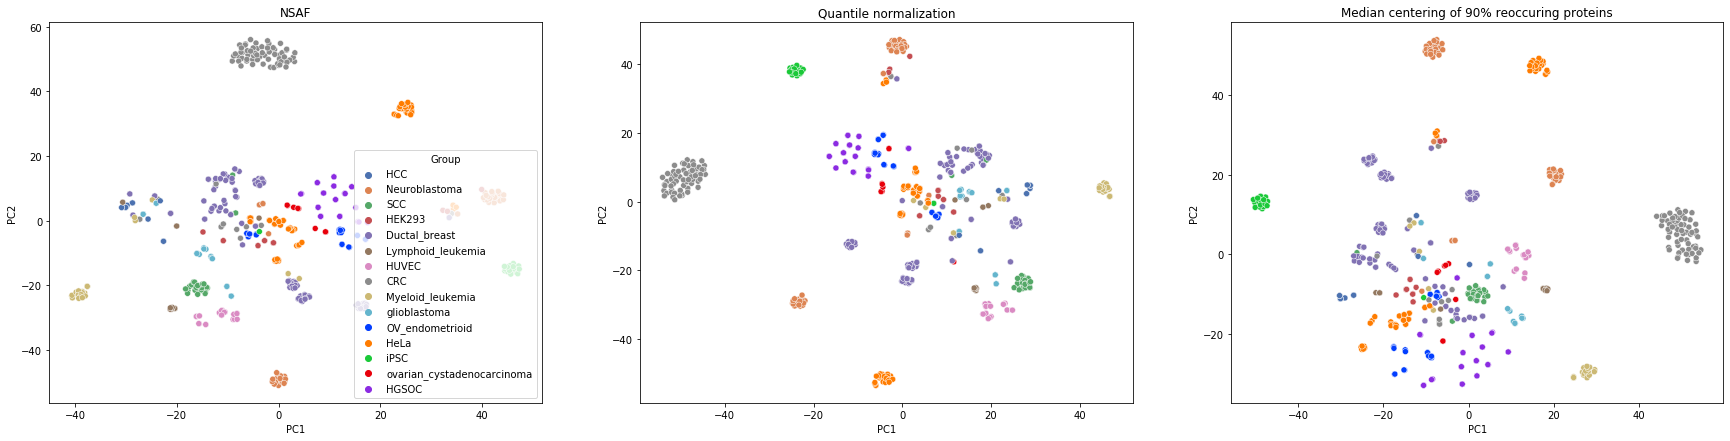

In [72]:
fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = TSNE(perplexity=20).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], ax=ax[0])

embedding = TSNE(perplexity=20).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1])

embedding = TSNE(perplexity=20).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[2])

# Pycombat

In [58]:
from combat.pycombat import pycombat

In [63]:
combat_df = pycombat(pd.DataFrame(X1).T, meta.Group.tolist())
combat_df = combat_df.T

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:158: RuntimeWarning: invalid value encountered in true_divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in true_divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [20]:
missing_value_mask = nsaf_filtered.isna()
data_combat = combat_df.where(~missing_value_mask, other=np.nan)

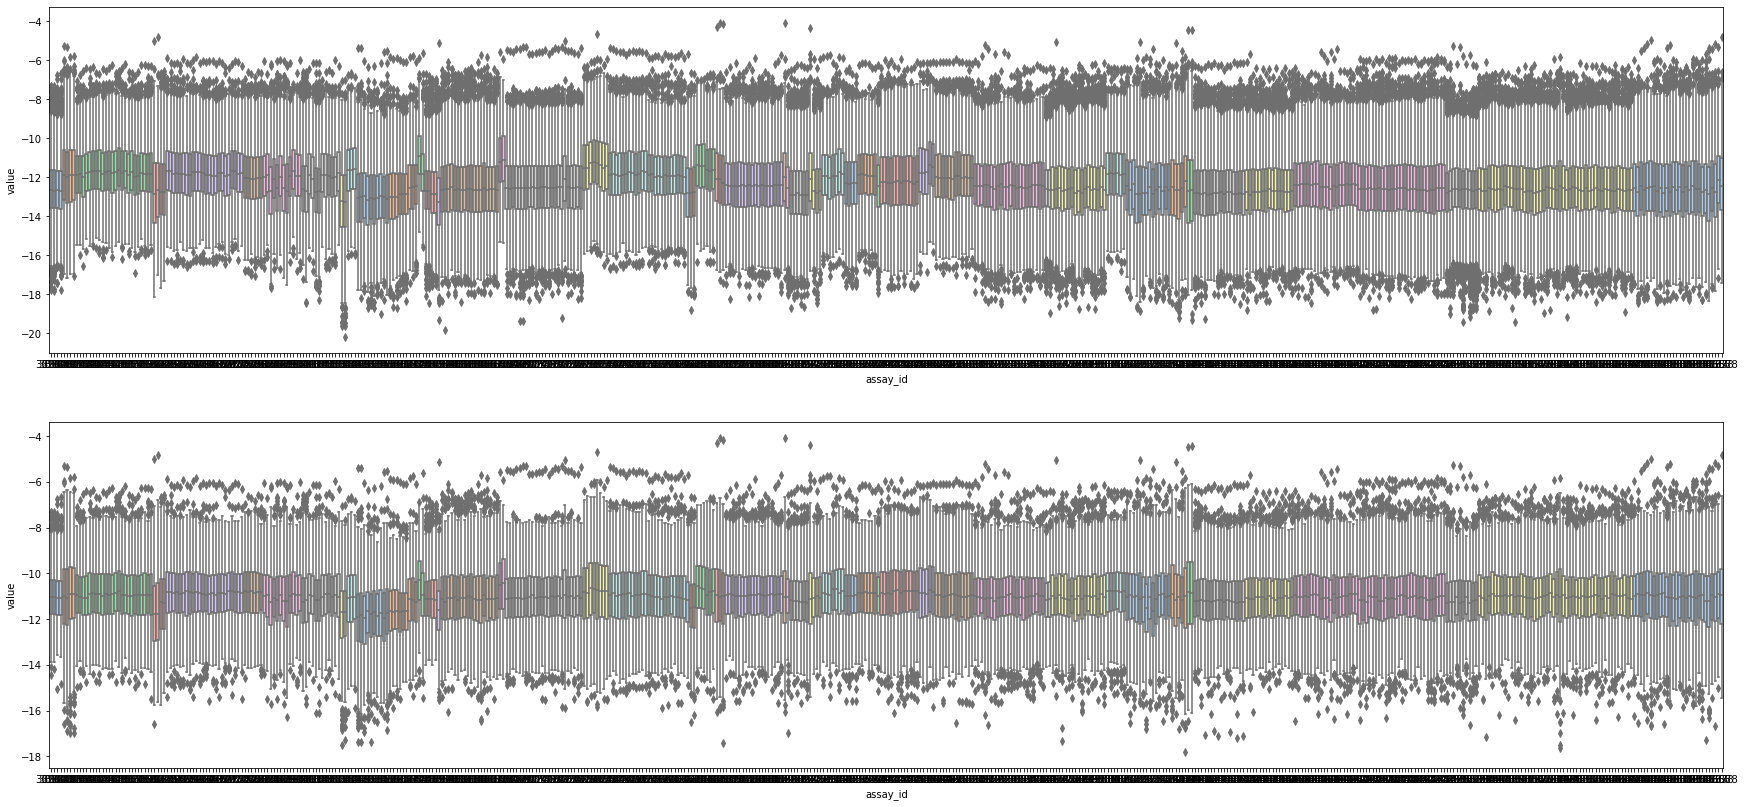

In [26]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=data_combat.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=data_combat.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

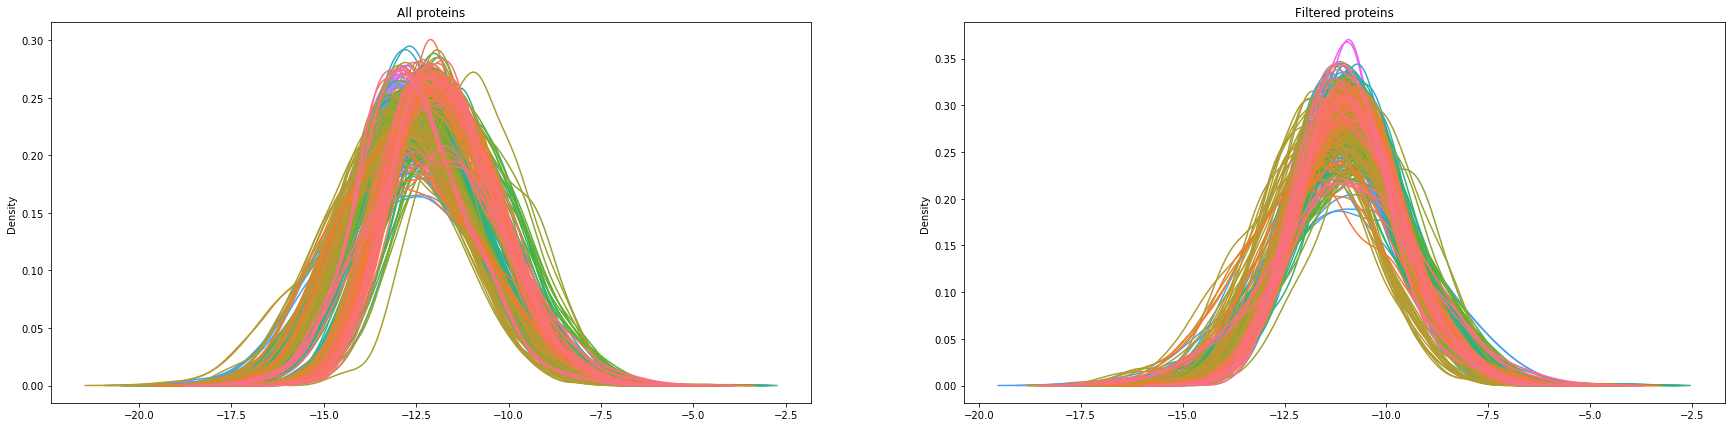

In [31]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=data_combat.transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=data_combat.loc[:, filtered_90.columns].transpose(), legend = False, common_norm=False, ax =ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Median log2(NSAF)')

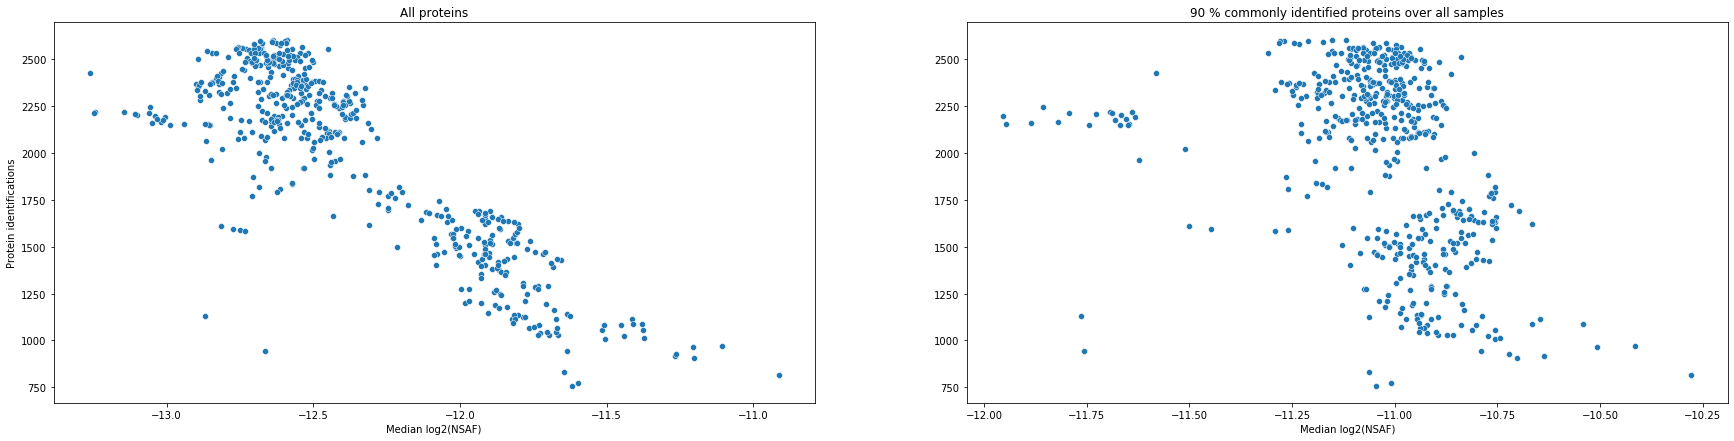

In [27]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(data_combat.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(data_combat.loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

plt.title("Median NSAF in relation to protein identifications")
ax[0].set_title("All proteins")
ax[1].set_title("90 % commonly identified proteins over all samples")

ax[0].set_ylabel("Protein identifications")
ax[1].set_xlabel("Median log2(NSAF)")
ax[0].set_xlabel("Median log2(NSAF)")

Text(0.5, 1.0, '100 most abundant proteins in each sample (ComBat normalised)')

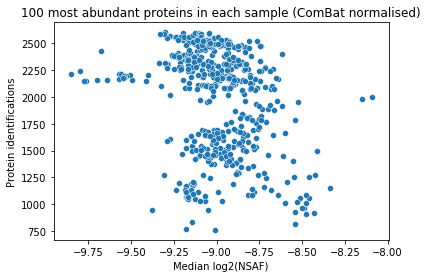

In [29]:
top_100_abundance = {}
top_prots = []
for i, row in data_combat.iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_prots += list(row.dropna().sort_values(ascending=False).index[:100])

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("100 most abundant proteins in each sample (ComBat normalised)")

In [64]:
combat_df = combat_df.set_index(nsaf_filtered.index)
combat_df = combat_df.dropna()

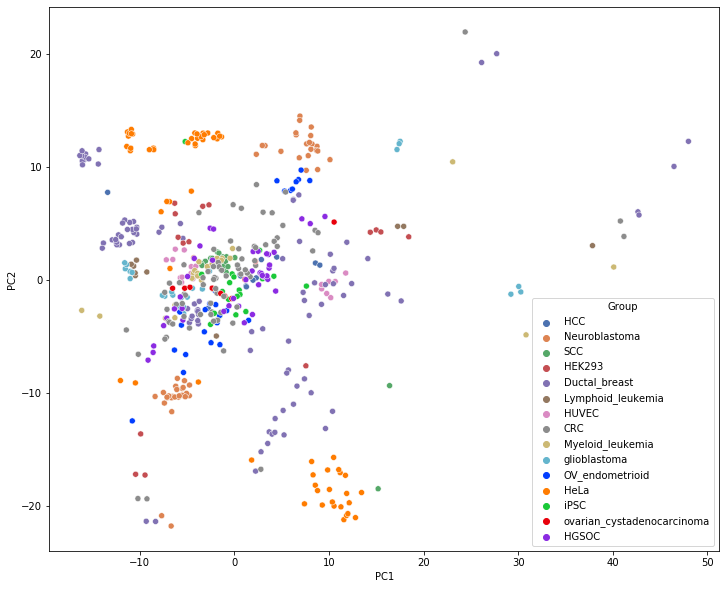

In [104]:
embedding = PCA(n_components=2).fit_transform(combat_df)

plt.figure(figsize=(12,10))
sns.scatterplot(data=pd.DataFrame(embedding, index= combat_df.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.loc[combat_df.index, "Group"], palette=colors[:15])

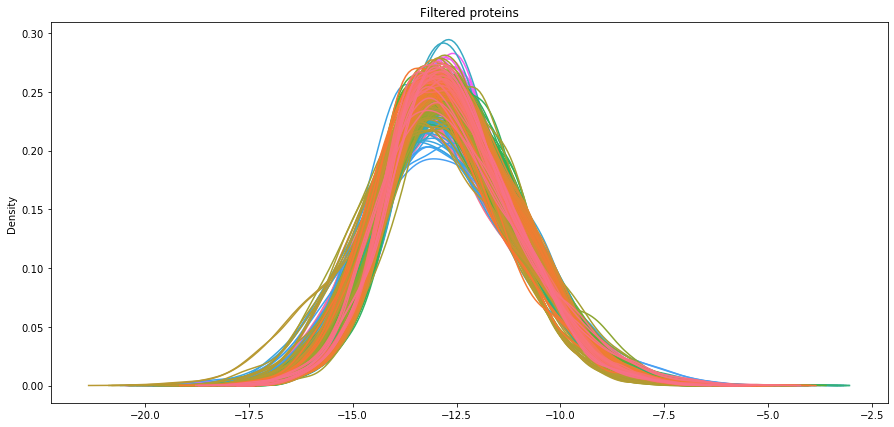

In [106]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.set_title('Filtered proteins')
sns.kdeplot(data=data_combat.transpose(), legend = False, common_norm=False, ax =ax)

Text(0.5, 1.0, '100 most abundant proteins in each sample (ComBat)')

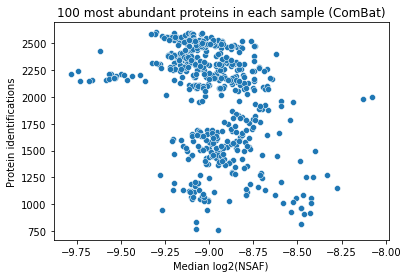

In [66]:
top_100_abundance = {}
top_prots = []
for i, row in combat_df.iterrows():
    top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_prots += list(row.dropna().sort_values(ascending=False).index[:100])

sns.scatterplot(x=pd.DataFrame(top_100_abundance).median(axis=0), y=nsaf_filtered.notna().sum(axis=1))
plt.ylabel("Protein identifications")
plt.xlabel("Median log2(NSAF)")
plt.title("100 most abundant proteins in each sample (ComBat)")

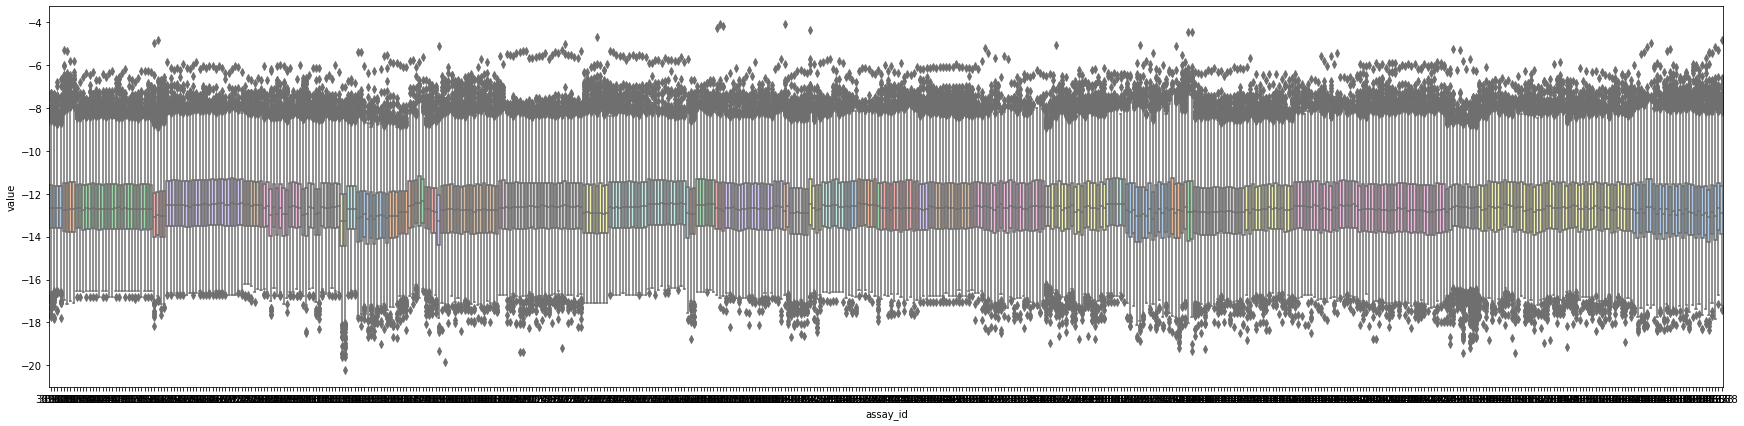

In [32]:
fig, ax = plt.subplots(1,1,figsize=(30,7))
sns.boxplot(data=combat_df.T.melt().dropna(), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values ,ax=ax)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


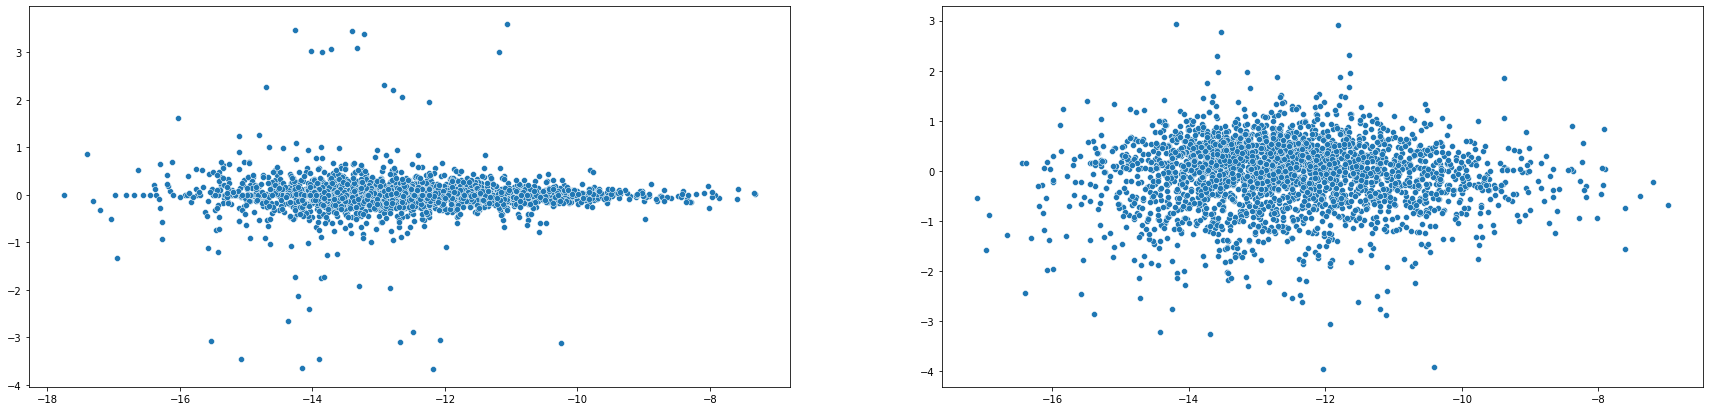

In [51]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(combat_df.iloc[[0,1],:].mean(axis=0), combat_df.iloc[0,:].subtract(combat_df.iloc[1,:]), ax=ax[0])
sns.scatterplot(combat_df.iloc[[0,20],:].mean(axis=0), combat_df.iloc[0,:].subtract(combat_df.iloc[20,:]), ax=ax[1])

In [129]:
combat_df = combat_df.rename(columns={i: nsaf_filtered.columns[i] for i in range(2615)})

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


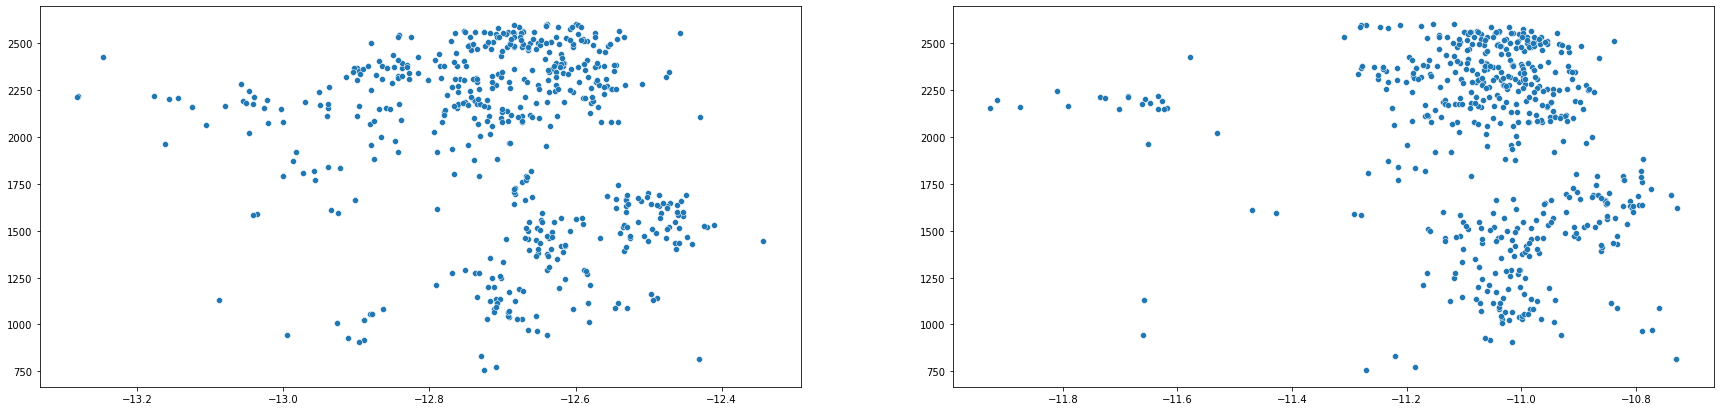

In [130]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(combat_df.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(combat_df.loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    0.980190  Within project    HCC
 1    0.816349  Within project    HCC
 2    0.813129  Within project    HCC
 3    0.805534  Within project    HCC
 4    0.804413  Within project    HCC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    0.867947  Within project  HGSOC
 1    0.869680  Within project  HGSOC
 2    0.779302  Within project  HGSOC
 3    0.770513  Within project  HGSOC
 4    0.784941  Within project  HGSOC
 ..        ...             ...    ...
 856  0.801253  Within project  HGSOC
 857  0.794005  Within project  HGSOC
 858  0.946554  Within project  HGSOC
 859  0.942977  Within project  HGSOC
 860  0.953996  Within project  HGSOC
 
 [861 rows x 3 columns])

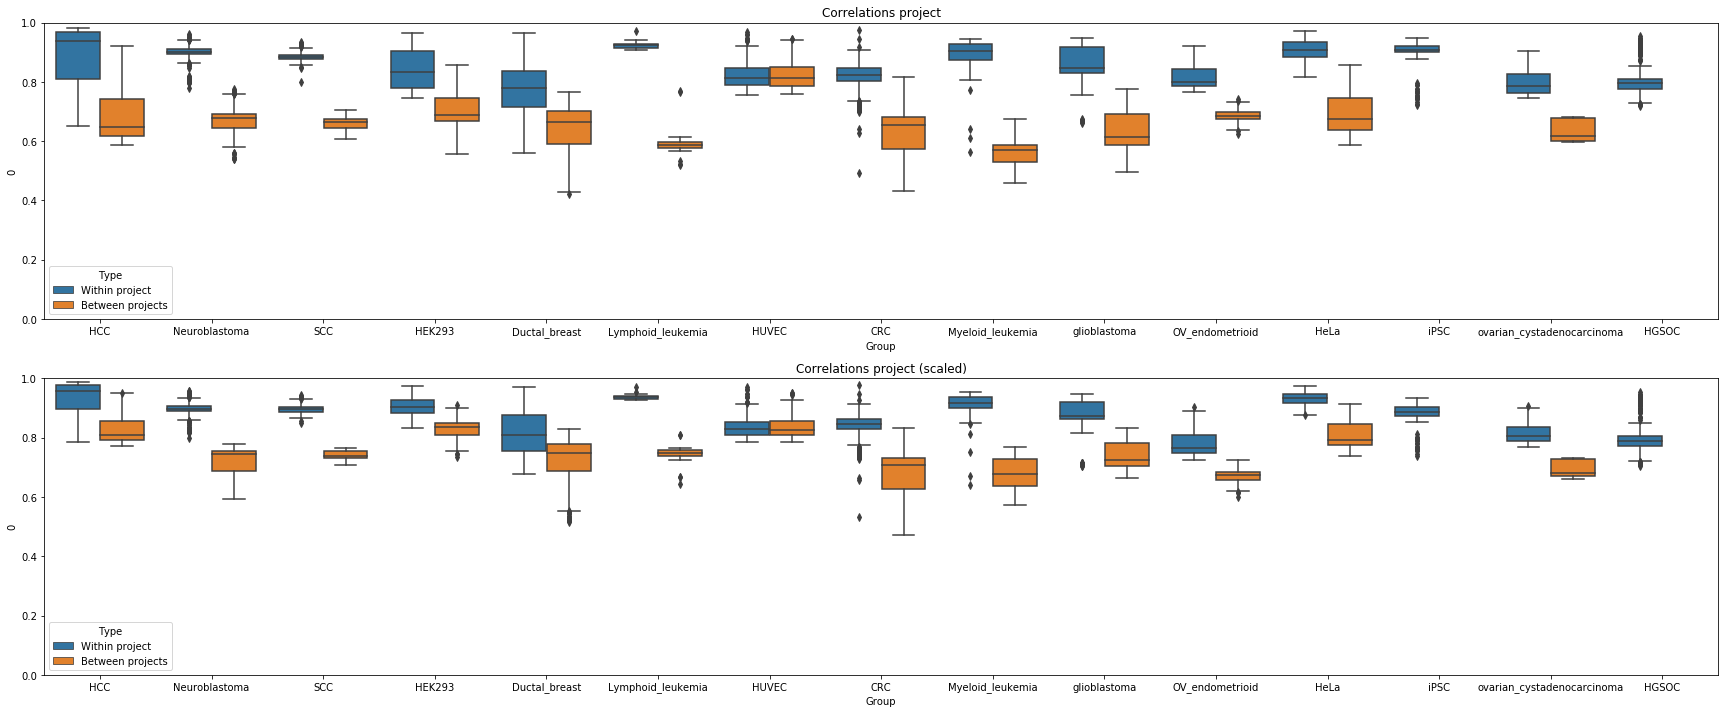

In [38]:
calculate_correlations_bygroup(data_combat)

In [74]:
combat_df_mm = MinMaxScaler().fit_transform(combat_df)

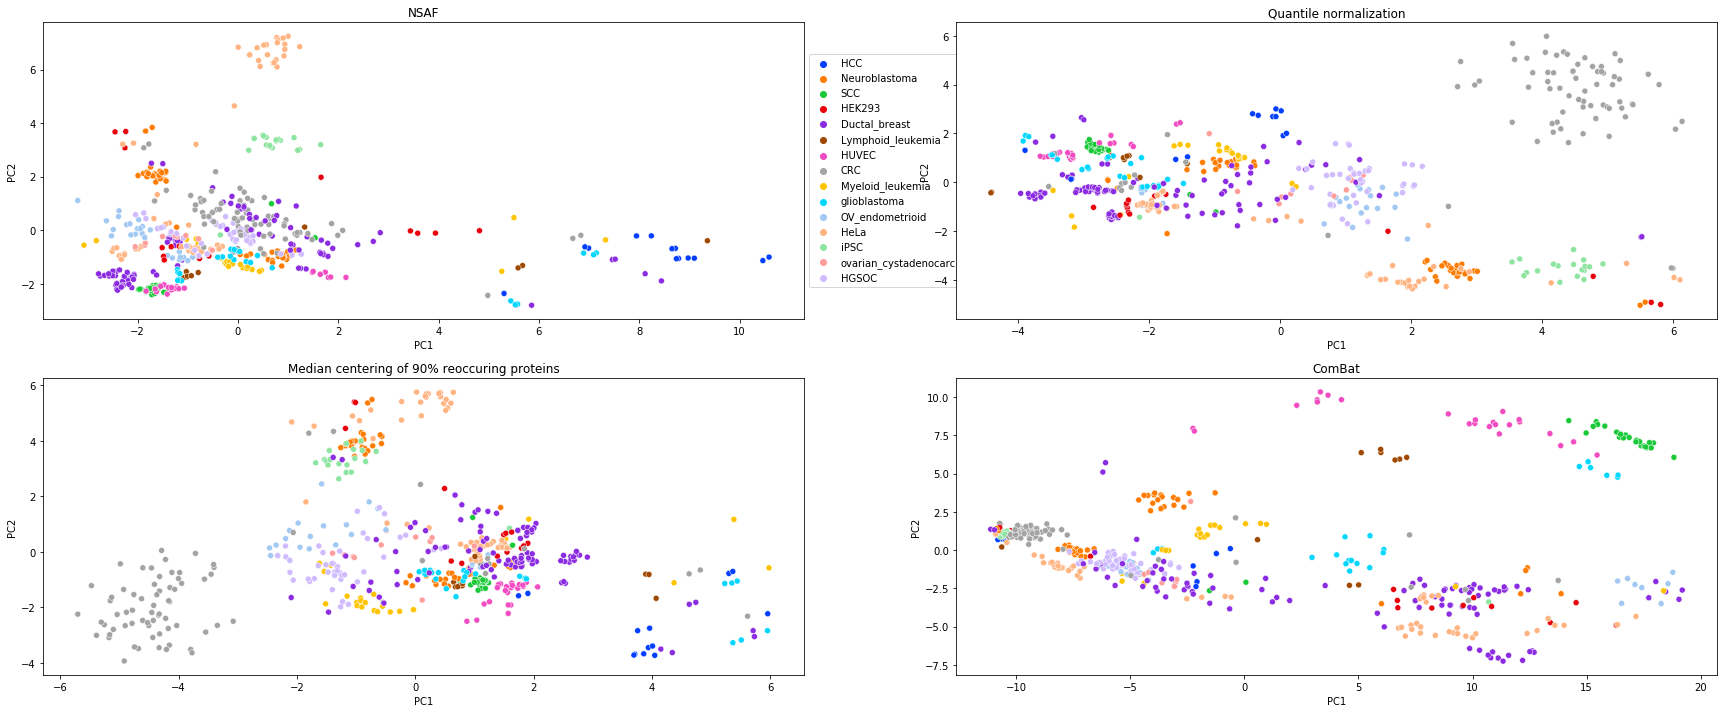

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1.fit(np.log2(nsaf_filtered))
X1 = imputer1.transform(np.log2(nsaf_filtered))
X1 = scaler.fit_transform(X1)

imputer2 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer2.fit(quantile_normalized_df)
X2 = imputer2.transform(quantile_normalized_df)
X2 = scaler.fit_transform(X2)

imputer3 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer3.fit(scaled_nsaf)
X3 = imputer3.transform(scaled_nsaf)
X3 = scaler.fit_transform(X3)

imputer4 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer4.fit(data_combat)
X4 = imputer3.transform(data_combat)
X4 = scaler.fit_transform(X4)

fig, ax = plt.subplots(2,2,figsize=(30,12))

ax[0,0].set_title("NSAF")
ax[0,1].set_title("Quantile normalization")
ax[1,0].set_title("Median centering of 90% reoccuring proteins")
ax[1,1].set_title("ComBat")

embedding = PCA(n_components=2).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], ax=ax[0,0])
ax[0,0].legend(loc='lower left', bbox_to_anchor=(1, 0.5))
embedding = PCA(n_components=2).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[0,1])

embedding = PCA(n_components=2).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1,0])

embedding = PCA(n_components=2).fit_transform(X4)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1,1])

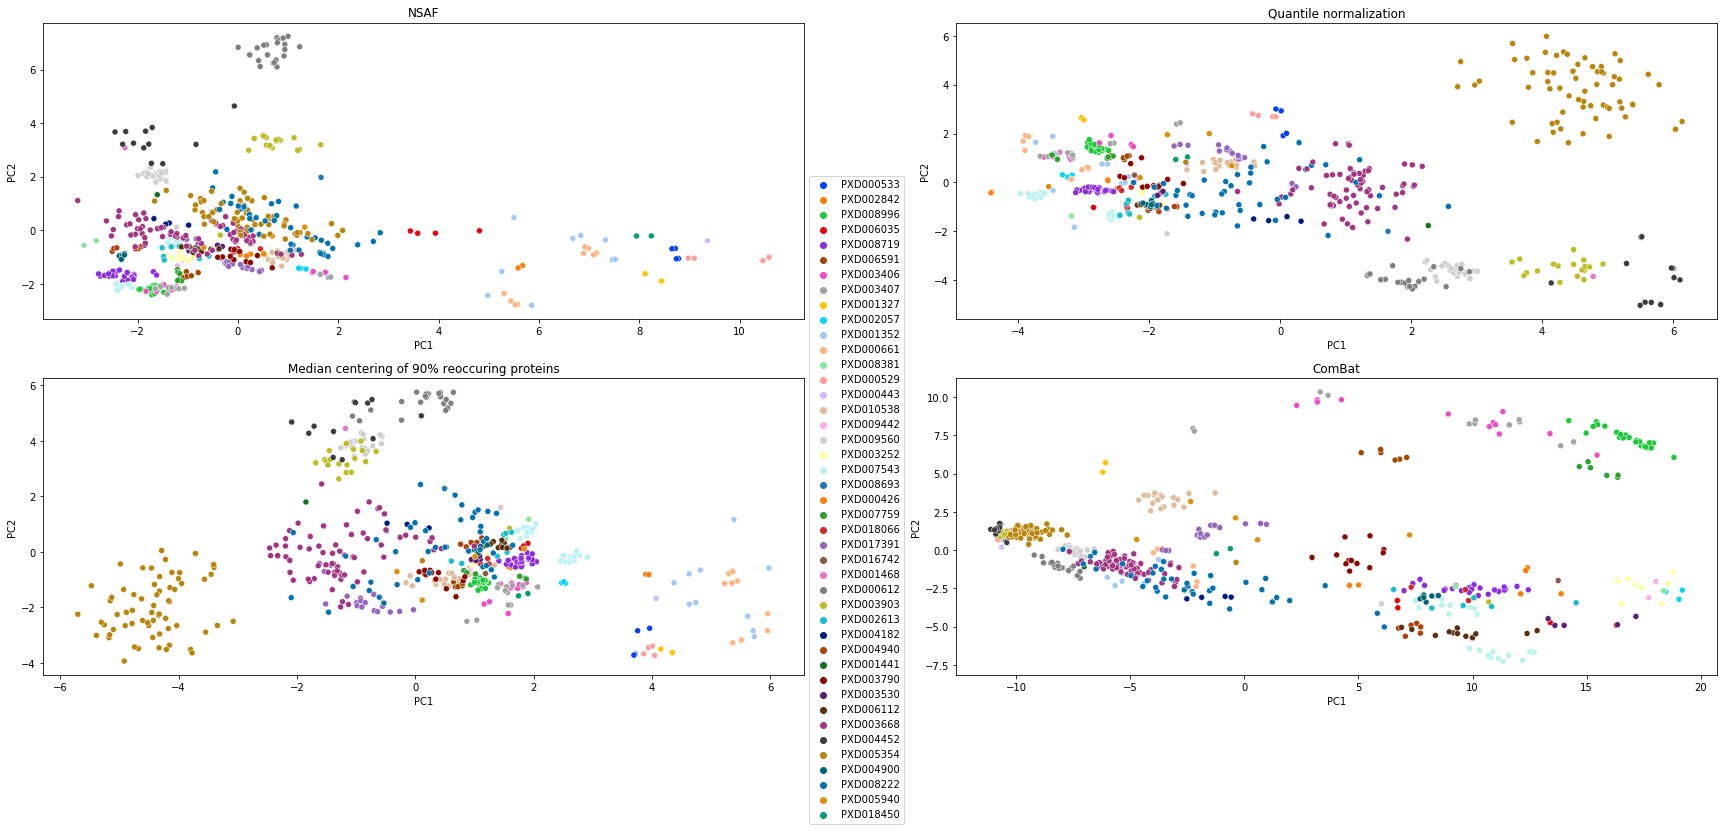

In [50]:
fig, ax = plt.subplots(2,2,figsize=(30,12))

ax[0,0].set_title("NSAF")
ax[0,1].set_title("Quantile normalization")
ax[1,0].set_title("Median centering of 90% reoccuring proteins")
ax[1,1].set_title("ComBat")

colors = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors = colors[:43]
embedding = PCA(n_components=2).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.PXD_accession, palette=colors[:43], ax=ax[0,0])
ax[0,0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

embedding = PCA(n_components=2).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[0,1])

embedding = PCA(n_components=2).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[1,0])

embedding = PCA(n_components=2).fit_transform(X4)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[1,1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

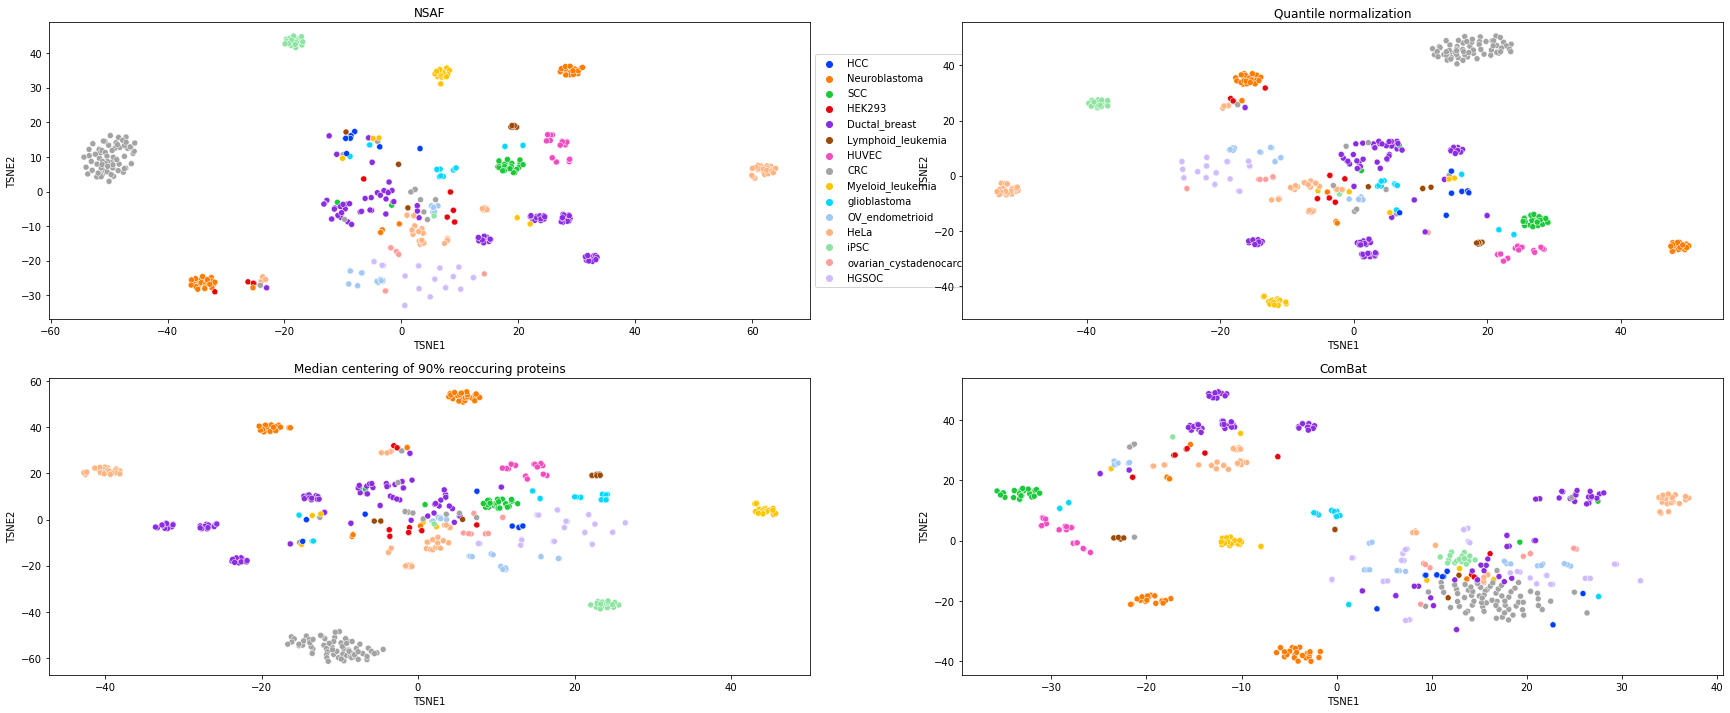

In [54]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1.fit(np.log2(nsaf_filtered))
X1 = imputer1.transform(np.log2(nsaf_filtered))
X1 = scaler.fit_transform(X1)

imputer2 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer2.fit(quantile_normalized_df)
X2 = imputer2.transform(quantile_normalized_df)
X2 = scaler.fit_transform(X2)

imputer3 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer3.fit(scaled_nsaf)
X3 = imputer3.transform(scaled_nsaf)
X3 = scaler.fit_transform(X3)

imputer4 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer4.fit(data_combat)
X4 = imputer3.transform(data_combat)
X4 = scaler.fit_transform(X4)

fig, ax = plt.subplots(2,2,figsize=(30,12))

ax[0,0].set_title("NSAF")
ax[0,1].set_title("Quantile normalization")
ax[1,0].set_title("Median centering of 90% reoccuring proteins")
ax[1,1].set_title("ComBat")

embedding1 = TSNE(perplexity=20).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding1, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.Group, palette=colors[:15], ax=ax[0,0])
ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
embedding2 = TSNE(perplexity=20).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding2, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[0,1])

embedding3 = TSNE(perplexity=20).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding3, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1,0])

embedding4 = TSNE(perplexity=20).fit_transform(X4)
sns.scatterplot(data=pd.DataFrame(embedding4, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1,1])

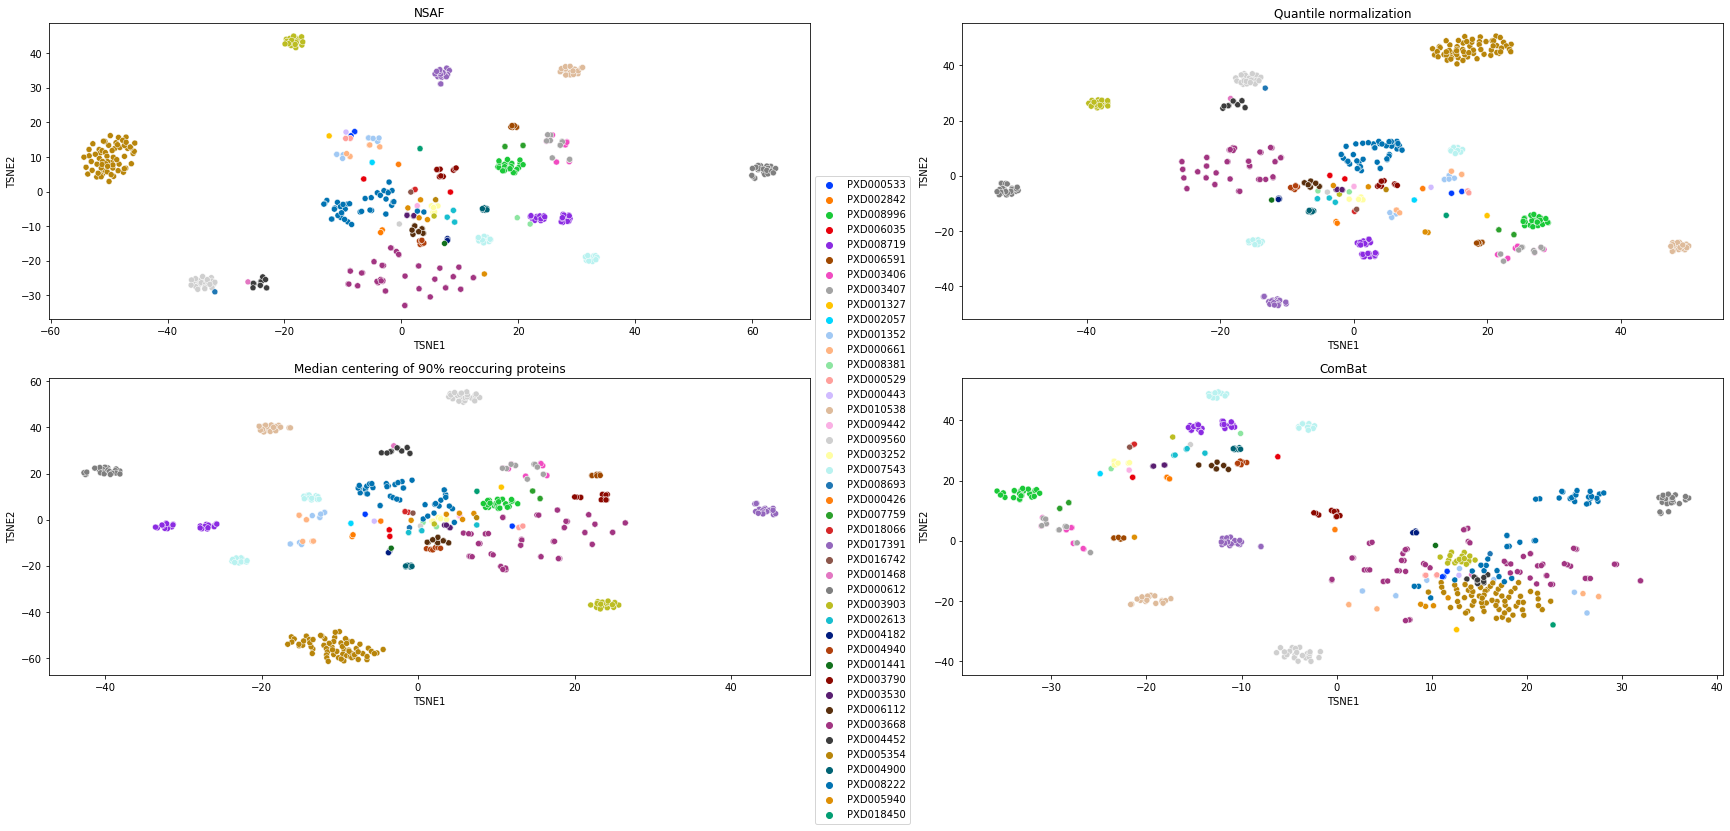

In [55]:
fig, ax = plt.subplots(2,2,figsize=(30,12))

ax[0,0].set_title("NSAF")
ax[0,1].set_title("Quantile normalization")
ax[1,0].set_title("Median centering of 90% reoccuring proteins")
ax[1,1].set_title("ComBat")

colors = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors = colors[:43]

sns.scatterplot(data=pd.DataFrame(embedding1, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.PXD_accession, palette=colors[:43], ax=ax[0,0])
ax[0,0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

sns.scatterplot(data=pd.DataFrame(embedding2, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[0,1])

sns.scatterplot(data=pd.DataFrame(embedding3, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[1,0])

sns.scatterplot(data=pd.DataFrame(embedding4, index= nsaf_filtered.index,columns=["TSNE1", "TSNE2"]), x="TSNE1", y="TSNE2", hue=meta.PXD_accession, palette=colors[:43], legend=False, ax=ax[1,1])

Text(0.5, 0, 'Number of principal components')

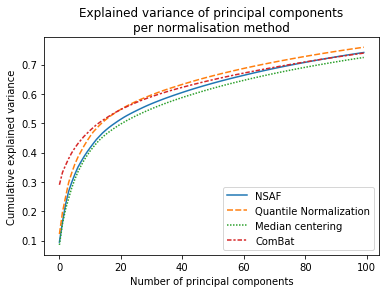

In [57]:
pc1 = PCA(n_components = 100)
pc2 = PCA(n_components = 100)
pc3 = PCA(n_components = 100)
pc4 = PCA(n_components = 100)

embedding = pc1.fit_transform(X1)
embedding = pc2.fit_transform(X2)
embedding = pc3.fit_transform(X3)
embedding = pc4.fit_transform(X4)


sns.lineplot(data=pd.DataFrame({"NSAF": np.cumsum(pc1.explained_variance_ratio_),
            "Quantile Normalization": np.cumsum(pc2.explained_variance_ratio_),
            "Median centering": np.cumsum(pc3.explained_variance_ratio_),
            "ComBat": np.cumsum(pc4.explained_variance_ratio_)}))

plt.title("Explained variance of principal components\nper normalisation method")
plt.ylabel("Cumulative explained variance")
plt.xlabel("Number of principal components")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Explained variance')

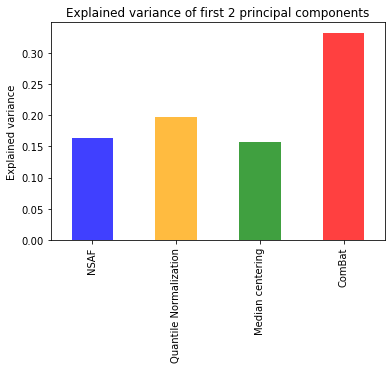

In [65]:
pd.DataFrame({"NSAF": np.cumsum(pc1.explained_variance_ratio_),
            "Quantile Normalization": np.cumsum(pc2.explained_variance_ratio_),
            "Median centering": np.cumsum(pc3.explained_variance_ratio_),
            "ComBat": np.cumsum(pc4.explained_variance_ratio_)}).loc[1].plot("bar", color=["b", "orange", "g", "r"], alpha=.75)
plt.title("Explained variance of first 2 principal components")
plt.ylabel("Explained variance")

In [ ]:
sns.lineplot(data=pd.DataFrame({"NSAF": np.cumsum(pc1.explained_variance_ratio_),
            "Quantile Normalization": np.cumsum(pc2.explained_variance_ratio_),
            "Median centering": np.cumsum(pc3.explained_variance_ratio_),
            "ComBat": np.cumsum(pc4.explained_variance_ratio_)}))

In [147]:
combat_df.to_csv("combat_NSAF_50.csv")
quantile_normalized_df.to_csv("quantile_norm_NSAF_50.csv")
scaled_nsaf.to_csv("median_scaling_50.csv")
nsaf_filtered.to_csv("NSAF_50.csv")

In [272]:
nsaf_filtered.to_csv("NSAF_50.csv")

In [14]:
combat_df = pd.read_csv("combat_NSAF_50.csv", index_col = "assay_id")
quantile_normalized_df = pd.read_csv("quantile_norm_NSAF_50.csv", index_col = "assay_id")
scaled_nsaf = pd.read_csv("median_scaling_50.csv", index_col = "Unnamed: 0")
nsaf_filtered = pd.read_csv("NSAF_50.csv", index_col = "assay_id")
nsaf_filtered = np.log2(nsaf_filtered)

In [15]:
missing_value_mask = nsaf_filtered.isna()
combat_df = combat_df.where(~missing_value_mask, other=np.nan)

---

Correlations 90% commonly identified and 100 most abundant proteins versus protein identifications

In [ ]:
len(filtered_90.columns)

636

[]

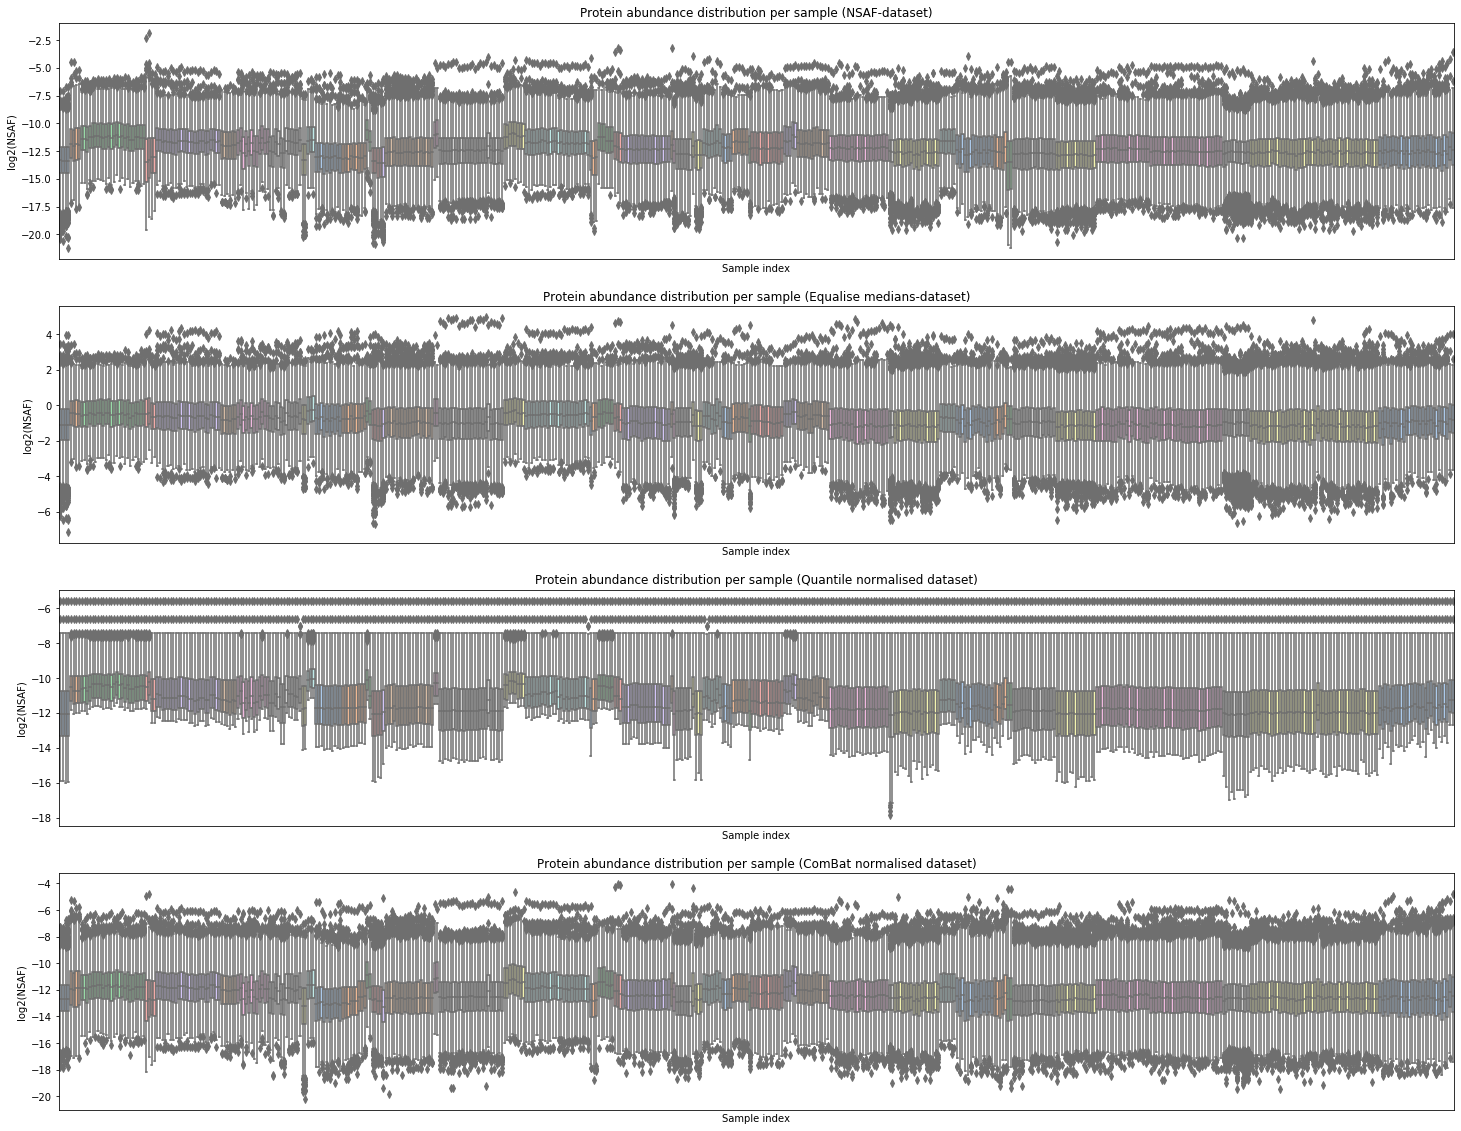

In [23]:
fig,ax=plt.subplots(4,1, figsize=(25,20))
sns.boxplot(data=nsaf_filtered.T.melt().dropna(), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values, ax=ax[0])
ax[0].set_title("Protein abundance distribution per sample (NSAF-dataset)")
ax[0].set_ylabel("log2(NSAF)")
ax[0].set_xlabel("Sample index")
ax[0].set_xticks(ticks=[])

sns.boxplot(data=scaled_nsaf.T.melt().dropna(), y='value', x="variable", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values, ax=ax[1])
ax[1].set_title("Protein abundance distribution per sample (Equalise medians-dataset)")
ax[1].set_ylabel("log2(NSAF)")
ax[1].set_xlabel("Sample index")
ax[1].set_xticks(ticks=[])

sns.boxplot(data=quantile_normalized_df.T.melt().dropna(), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values, ax=ax[2])
ax[2].set_title("Protein abundance distribution per sample (Quantile normalised dataset)")
ax[2].set_ylabel("log2(NSAF)")
ax[2].set_xlabel("Sample index")
ax[2].set_xticks(ticks=[])

sns.boxplot(data=combat_df.T.melt().dropna(), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values, ax=ax[3])
ax[3].set_title("Protein abundance distribution per sample (ComBat normalised dataset)")
ax[3].set_ylabel("log2(NSAF)")
ax[3].set_xlabel("Sample index")
ax[3].set_xticks(ticks=[])

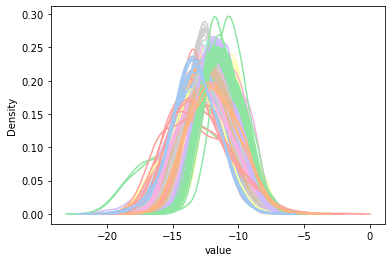

In [40]:
sns.kdeplot(data=nsaf_filtered.transpose().melt(), x="value", hue="assay_id", legend = False, common_norm=False, palette=meta.PXD_accession.apply(lambda x: mapper[x]).values.tolist())

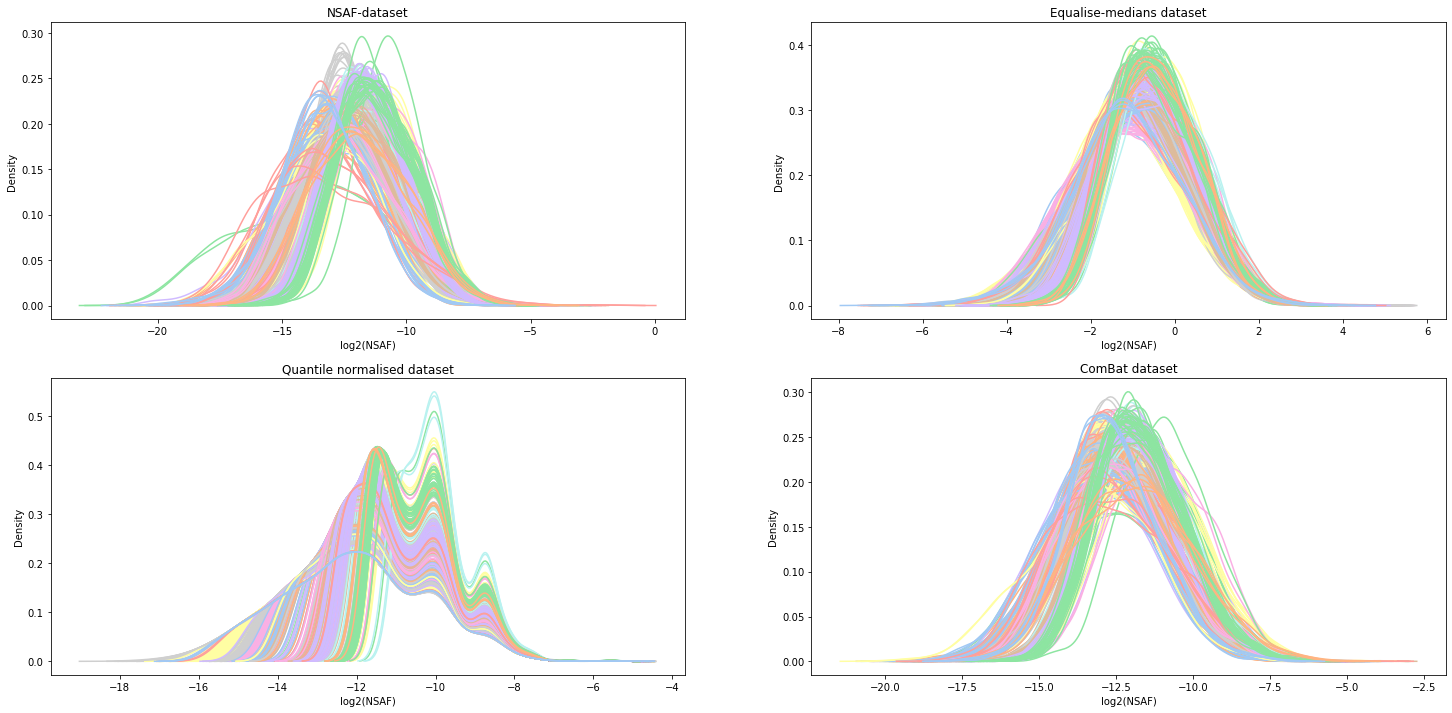

In [42]:
fig, ax = plt.subplots(2,2, figsize=(25,12))

ax[0,0].set_title('NSAF-dataset')
ax[0,0].set_xlabel("log2(NSAF)")
sns.kdeplot(data=nsaf_filtered.transpose().melt(),  x="value", hue="assay_id",legend = False, common_norm=False, ax =ax[0,0] , palette=meta.PXD_accession.apply(lambda x: mapper[x]).values.tolist())

ax[0,1].set_title("Equalise-medians dataset")
ax[0,1].set_xlabel("log2(NSAF)")
sns.kdeplot(data=scaled_nsaf.transpose().melt(),  x="value", hue="variable", legend = False, common_norm=False, ax =ax[0,1] , palette=meta.PXD_accession.apply(lambda x: mapper[x]).values.tolist())

ax[1,0].set_title("Quantile normalised dataset")
ax[1,0].set_xlabel("log2(NSAF)")
sns.kdeplot(data=quantile_normalized_df.transpose().melt(),  x="value", hue="assay_id", legend = False, common_norm=False, ax =ax[1,0] , palette=meta.PXD_accession.apply(lambda x: mapper[x]).values.tolist())

ax[1,1].set_title("ComBat dataset")
ax[1,1].set_xlabel("log2(NSAF)")
sns.kdeplot(data=combat_df.transpose().melt(),  x="value", hue="assay_id", legend = False, common_norm=False, ax =ax[1,1] , palette=meta.PXD_accession.apply(lambda x: mapper[x]).values.tolist())

In [ ]:
annot_norm = "NSAF Quantile Median ComBat".split()
datasets = [nsaf_filtered, quantile_normalized_df, scaled_nsaf, combat_df]

top_100 = []
top_100_abundance = {}

for dataset in datasets:
    for i, row in dataset.iterrows():
        top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_100.append(pd.DataFrame(top_100_abundance).median(axis=0))

for i in range(4):
    corr_90 = stats.spearmanr(datasets[i].loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))
    corr_top100 = stats.spearmanr(top_100[i], nsaf_filtered.notna().sum(axis=1))
    print(annot_norm[i])
    print("Corr 90%: r={:.2f}; p-val={}".format(corr_90[0], corr_90[1]))
    print("Corr top 100: r={:.2f}; p-val={}".format(corr_top100[0], corr_top100[1]))
    print()

NSAF
Corr 90%: r=-0.55; p-val=5.623249219796805e-43
Corr top 100: r=-0.57; p-val=4.062913903567535e-45

Quantile
Corr 90%: r=-0.54; p-val=1.4105331551128036e-40
Corr top 100: r=-0.04; p-val=0.34403853143046714

Median
Corr 90%: r=-0.03; p-val=0.50935201401574
Corr top 100: r=0.52; p-val=7.1703046155690925e-37

ComBat
Corr 90%: r=-0.48; p-val=1.2438575596359491e-30
Corr top 100: r=-0.33; p-val=2.887130554771309e-14



In [ ]:
annot_norm = "NSAF Quantile Median ComBat".split()
datasets = [nsaf_filtered, quantile_normalized_df, scaled_nsaf, combat_df]

top_100 = []
top_100_abundance = {}

for dataset in datasets:
    for i, row in dataset.iterrows():
        top_100_abundance[i] = np.sort(np.array(row.dropna()))[-100::]
    top_100.append(pd.DataFrame(top_100_abundance).median(axis=0))

for i in range(4):
    corr_90 = stats.pearsonr(datasets[i].loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1))
    corr_top100 = stats.pearsonr(top_100[i], nsaf_filtered.notna().sum(axis=1))
    print(annot_norm[i])
    print("Corr 90%: r={:.2f}; p-val={}".format(corr_90[0], corr_90[1]))
    print("Corr top 100: r={:.2f}; p-val={}".format(corr_top100[0], corr_top100[1]))
    print()

NSAF
Corr 90%: r=-0.45; p-val=8.261783205350072e-28
Corr top 100: r=-0.54; p-val=1.3621591846641e-40

Quantile
Corr 90%: r=-0.56; p-val=2.954777463178525e-43
Corr top 100: r=0.00; p-val=0.9946724746074382

Median
Corr 90%: r=-0.02; p-val=0.6313092113507504
Corr top 100: r=0.49; p-val=5.927958482982623e-32

ComBat
Corr 90%: r=-0.37; p-val=1.9906884354830682e-18
Corr top 100: r=-0.31; p-val=4.708447411305331e-13



---

# Which proteins are least variable?

Idea: normalise on least variable proteins

In [ ]:
lowest_std = np.log2(nsaf_filtered).std().sort_values().reset_index()
lowest_std_quant = quantile_normalized_df.std().sort_values().reset_index()
lowest_std_med = scaled_nsaf.std().sort_values().reset_index()
lowest_std_combat = combat_df.std().sort_values().reset_index()

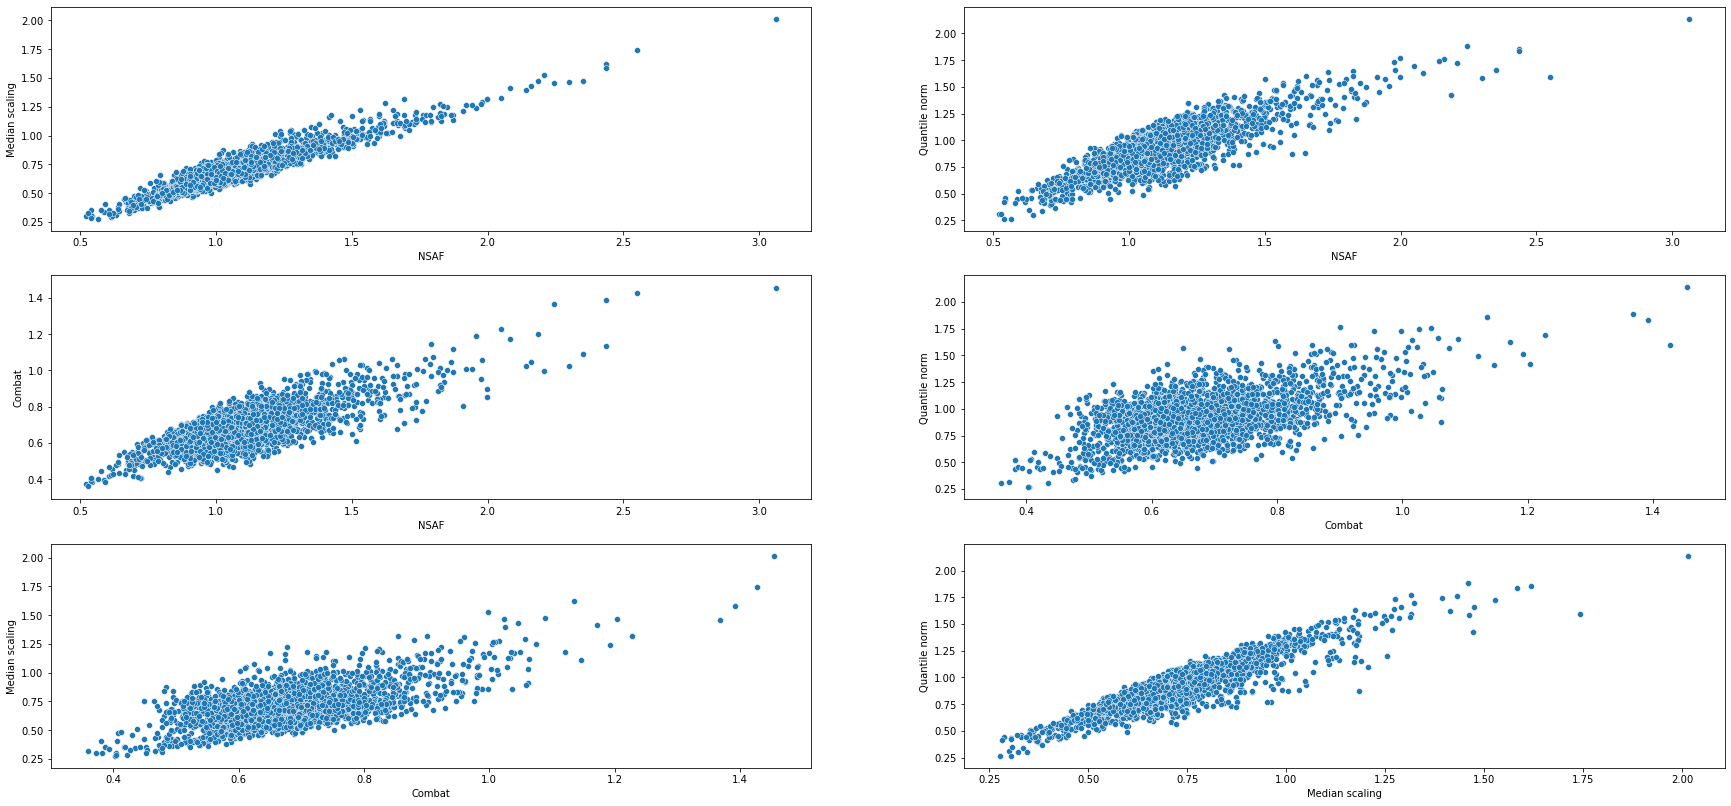

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(30,14))

scaled_std = scaled_nsaf.std()
quantile_std = quantile_normalized_df.std()
combat_std = combat_df.std()
nsaf_std = np.log2(nsaf_filtered).std()

ax[0][0].set_ylabel("Median scaling")
ax[1][0].set_ylabel("Combat")
ax[2][0].set_ylabel("Median scaling")

ax[0][0].set_xlabel("NSAF")
ax[1][0].set_xlabel("NSAF")
ax[2][0].set_xlabel("Combat")

ax[0][1].set_ylabel("Quantile norm")
ax[1][1].set_ylabel("Quantile norm")
ax[2][1].set_ylabel("Quantile norm")

ax[0][1].set_xlabel("NSAF")
ax[1][1].set_xlabel("Combat")
ax[2][1].set_xlabel("Median scaling")

sns.scatterplot(x=nsaf_std, y=scaled_std, ax=ax[0][0])
sns.scatterplot(x=nsaf_std, y=combat_std, ax=ax[1][0])
sns.scatterplot(x=combat_std, y=scaled_std, ax=ax[2][0])

sns.scatterplot(x=nsaf_std, y=quantile_std, ax=ax[0][1])
sns.scatterplot(x=combat_std, y=quantile_std, ax=ax[1][1])
sns.scatterplot(x=scaled_std, y=quantile_std, ax=ax[2][1])

<BarContainer object of 6 artists>

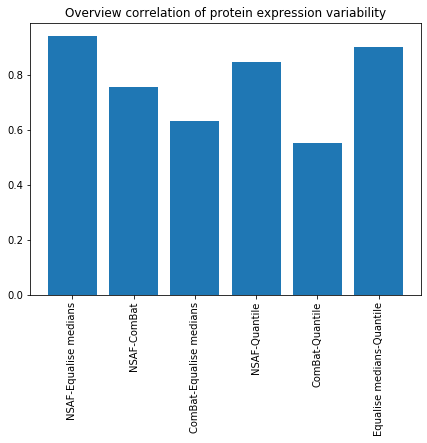

In [ ]:
pearson_corr = [stats.pearsonr(x=nsaf_std, y=scaled_std)[0], 
                stats.pearsonr(x=nsaf_std, y=combat_std)[0],
                stats.pearsonr(x=combat_std, y=scaled_std)[0],
                stats.pearsonr(x=nsaf_std, y=quantile_std)[0],
                stats.pearsonr(x=combat_std, y=quantile_std)[0],
                stats.pearsonr(x=scaled_std, y=quantile_std)[0]]

annot = ["NSAF-Equalise medians",
         "NSAF-ComBat",
         "ComBat-Equalise medians",
         "NSAF-Quantile",
         "ComBat-Quantile",
         "Equalise medians-Quantile"]

plt.figure(figsize=(7,5))
plt.title("Overview correlation of protein expression variability")
plt.xticks(rotation=90)
plt.bar(x=annot, height=pearson_corr)

In [ ]:
pearson_corr = [stats.pearsonr(x=nsaf_std, y=scaled_std)[0], 
                stats.pearsonr(x=nsaf_std, y=combat_std)[0],
                stats.pearsonr(x=combat_std, y=scaled_std)[0],
                stats.pearsonr(x=nsaf_std, y=quantile_std)[0],
                stats.pearsonr(x=combat_std, y=quantile_std)[0],
                stats.pearsonr(x=scaled_std, y=quantile_std)[0]]

annot = ["NSAF-Equalise medians",
         "NSAF-ComBat",
         "ComBat-Equalise medians",
         "NSAF-Quantile",
         "ComBat-Quantile",
         "Equalise medians-Quantile"]


print("NSAF-Equalise medians: \t\t", stats.pearsonr(x=nsaf_std, y=scaled_std)[0])
print("NSAF-ComBat:\t\t\t", stats.pearsonr(x=nsaf_std, y=combat_std)[0])
print("ComBat-Equalise medians:\t", stats.pearsonr(x=combat_std, y=scaled_std)[0])

print("NSAF-Quantile:\t\t\t",stats.pearsonr(x=nsaf_std, y=quantile_std)[0])
print("ComBat-Quantile:\t\t", stats.pearsonr(x=combat_std, y=quantile_std)[0])
print("Equalise medians-Quantile:\t", stats.pearsonr(x=scaled_std, y=quantile_std)[0])

NSAF-Equalise medians: 		 0.9431552155257721
NSAF-ComBat:			 0.7572926884232143
ComBat-Equalise medians:	 0.633680309171159
NSAF-Quantile:			 0.8466744475391829
ComBat-Quantile:		 0.5515533460855198
Equalise medians-Quantile:	 0.9014925804814105


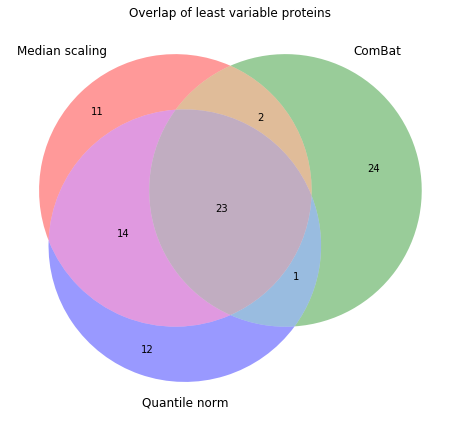

In [ ]:
import matplotlib_venn as venn

fig, ax = plt.subplots(1,1, figsize= (8,8), facecolor = "white")
ax.set_title("Overlap of least variable proteins")
venn.venn3([set(lowest_std_med[:50]["uniprot_id"]), set(lowest_std_combat[:50]["index"]), set(lowest_std_quant[:50]["uniprot_id"])], ["Median scaling", "ComBat", "Quantile norm"])

In [ ]:
common_least_variable = set(lowest_std_med[:50]["uniprot_id"]).intersection(set(lowest_std_combat[:50]["index"])).intersection(set(lowest_std_quant[:50]["uniprot_id"]))

In [ ]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

import json
with open("../ML/GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

connection succesfull


In [ ]:
uniprot_description.loc[list(common_least_variable)]

description
uniprot_id                                                   
P13639                                   Elongation factor 2 
P53618                                 Coatomer subunit beta 
P49915                  GMP synthase [glutamine-hydrolyzing] 
Q9Y3I0                      RNA-splicing ligase RtcB homolog 
P50990                     T-complex protein 1 subunit theta 
O00231       26S proteasome non-ATPase regulatory subunit 11 
P52907               F-actin-capping protein subunit alpha-1 
Q8WUM4           Programmed cell death 6-interacting protein 
P13010            X-ray repair cross-complementing protein 5 
P54136                    Arginine--tRNA ligase, cytoplasmic 
P23526                                Adenosylhomocysteinase 
Q14152      Eukaryotic translation initiation factor 3 sub...
P42704      Leucine-rich PPR motif-containing protein, mit...
P50991                     T-complex protein 1 subunit delta 
Q7KZF4      Staphylococcal nuclease domain-containing prot...
P07900                       Heat shock protein HSP 90-alpha 
Q9UHB9             Signal recognition particle subunit SRP68 
P55060                                            Exportin-2 
P53396                                  ATP-citrate synthase 
Q99832                       T-complex protein 1 subunit eta 
Q15691      Microtubule-associated protein RP/EB family me...
P12004                    Proliferating cell nuclear antigen 
P49411                   Elongation factor Tu, mitochondrial

In [ ]:
GO_low_variable_prot = {}

for i, prot in enumerate(lowest_std.uniprot_id):
    for go in uniprot_go_function[prot]:
        if go not in GO_low_variable_prot.keys():
            GO_low_variable_prot[go] = np.array([1])
        else:
            GO_low_variable_prot[go] += 1
    if i == 9:
        break

mapper = {}
for go in GO_low_variable_prot.keys():
    if go in GO_description.index:
        mapper[go] = GO_description.loc[go].annotation_label

GO_low_variable_prot = pd.DataFrame(data=GO_low_variable_prot)
GO_low_variable_prot.T.rename(index=mapper).sort_values(by=0,ascending=False)[:10]

0
protein binding                          10
RNA binding                               6
ATP binding                               5
ATP hydrolysis activity                   4
ATP-dependent protein folding chaperone   3
ubiquitin protein ligase binding          3
unfolded protein binding                  3
protein folding chaperone                 3
cadherin binding                          2
endonuclease activity                     1

In [ ]:
for x in common_least_variable:
    print(x)

P13639
P53618
P49915
Q9Y3I0
P50990
O00231
P52907
Q8WUM4
P13010
P54136
P23526
Q14152
P42704
P50991
Q7KZF4
P07900
Q9UHB9
P55060
P53396
Q99832
Q15691
P12004
P49411


In [ ]:
# settings: Minimum required interaction score: .7 (high confidence)
string_results = pd.read_csv("enrichment.all.tsv", sep="\t")

#category     term ID  \
0    GO Process  GO:2000573   
1    GO Process  GO:0032212   
2    GO Process  GO:1904851   
3    GO Process  GO:1904871   
4    GO Process  GO:0016032   
..          ...         ...   
136    InterPro   IPR002423   
137    InterPro   IPR017998   
138    InterPro   IPR027409   
139    InterPro   IPR027410   
140    InterPro   IPR027413   

                                      term description  observed gene count  \
0      Positive regulation of DNA biosynthetic process                    6   
1    Positive regulation of telomere maintenance vi...                    4   
2    Positive regulation of establishment of protei...                    3   
3    Positive regulation of protein localization to...                    3   
4                                        Viral process                    8   
..                                                 ...                  ...   
136                      Chaperonin Cpn60/TCP-1 family                    3   
137   Chaperone tailless complex polypeptide 1 (TCP-1)                    3   
138               GroEL-like apical domain superfamily                    3   
139  TCP-1-like chaperonin intermediate domain supe...                    3   
140           GroEL-like equatorial domain superfamily                    3   

     background gene count  strength  false discovery rate  \
0                       70      1.86              0.000003   
1                       34      2.00              0.000440   
2                       10      2.41              0.000860   
3                       11      2.37              0.000870   
4                      776      0.94              0.000950   
..                     ...       ...                   ...   
136                     15      2.23              0.002100   
137                     10      2.41              0.002100   
138                     15      2.23              0.002100   
139                     15      2.23              0.002100   
140                     14      2.26              0.002100   

               matching proteins in your network (IDs)  \
0    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
1    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
2    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
3    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
4    9606.ENSP00000249923,9606.ENSP00000322439,9606...   
..                                                 ...   
136  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
137  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
138  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
139  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
140  9606.ENSP00000258091,9606.ENSP00000286788,9606...   

            matching proteins in your network (labels)  
0                   CCT7,CCT8,HSP90AA1,PCNA,XRCC5,CCT4  
1                                 CCT7,CCT8,XRCC5,CCT4  
2                                       CCT7,CCT8,CCT4  
3                                       CCT7,CCT8,CCT4  
4    COPB1,TUFM,HSP90AA1,SND1,EIF3A,PCNA,XRCC5,PDCD6IP  
..                                                 ...  
136                                     CCT7,CCT8,CCT4  
137                                     CCT7,CCT8,CCT4  
138                                     CCT7,CCT8,CCT4  
139                                     CCT7,CCT8,CCT4  
140                                     CCT7,CCT8,CCT4  

[141 rows x 9 columns]

# Tau scores

The tau index indicates how specific or broadly expressed a gene or transcript is, within studied tissues.
Genes with a tau index close to 1 are more specifically expressed in one tissue, while genes with a tau index closer to 0 are equally expressed across all tissues studied.<br>
Tau varies from 0 to 1, where 0 means broadly expressed, and 1 is specific<br>
<br>
https://academic.oup.com/bib/article/18/2/205/2562739<br>
https://genomics.senescence.info/gene_expression/tau.html

In our case, tissue specificity is group specificity

In [ ]:
combat_med_per_group = pd.merge(np.exp2(combat_df).reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T
quantile_med_per_group = pd.merge(np.exp2(quantile_normalized_df).reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T
nsaf_med_per_group = pd.merge(nsaf_filtered.reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T

In [ ]:
def calc_tau_exp(values, prot):
    max_val = max(values)

    tau = 0
    for i, v in enumerate(values):
        
        tau += (1-(v/max_val))

    val = np.round(tau/i, 2)
    if val > 1:
        return 0
    return val

In [ ]:
tau_exp_data_combat = {}
for prot_id, row in combat_med_per_group.iterrows():
    tau_exp_data_combat[prot_id] = calc_tau_exp(row.tolist(), prot_id)

tau_exp_data_quant = {}
for prot_id, row in quantile_med_per_group.iterrows():
    tau_exp_data_quant[prot_id] = calc_tau_exp(row.tolist(), prot_id)

tau_exp_data = {}
for prot_id, row in nsaf_med_per_group.iterrows():
    tau_exp_data[prot_id] = calc_tau_exp(row.tolist(), prot_id)

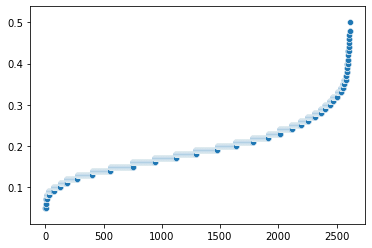

In [ ]:
sns.scatterplot(x=range(len(tau_exp_data)), y=np.sort(np.array(list(tau_exp_data.values()))))

In [ ]:
tau_vs_std = {}
for x in tau_exp_data.keys():
    tau_vs_std[x] = [tau_exp_data_combat[x], tau_exp_data_quant[x], tau_exp_data[x],combat_std[x], quantile_std[x], nsaf_std[x]]

In [ ]:
tau_vs_std = pd.DataFrame(tau_vs_std, index="TauCombat TauQuant TauNSAF ComBat Quantile NSAF".split())

In [ ]:
tau_vs_std = tau_vs_std.T

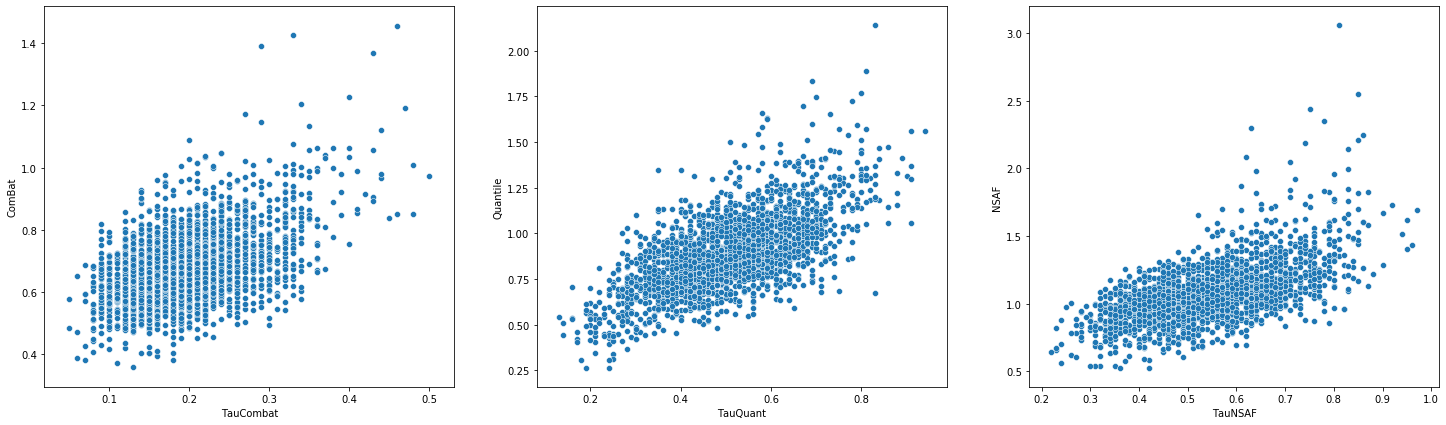

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(25,7))
for i,x in enumerate(ax):
    sns.scatterplot(data=tau_vs_std, x="TauCombat TauQuant TauNSAF".split()[i], y="ComBat Quantile NSAF".split()[i], ax=x)

Most protein seem to not be that group specific. Interestingly, standard deviation across the complete dataset seems to have a linear relationship with group specificity, suggesting more variance means more group-specific

---